In [15]:
from deepxde.nn.pytorch.deeponet import DeepONet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

r = 64
model = DeepONet(
    layer_sizes_branch=[2, 128, 128, r],
    layer_sizes_trunk=[2, 128, 128, r],
    activation="sin",
    kernel_initializer=torch.nn.init.xavier_uniform_,
).to(device)

# initialize weights
def init_fn(module):
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.0)

model.apply(init_fn)

optimizer = optim.LBFGS(model.parameters(), line_search_fn="strong_wolfe")

progress_bar = tqdm(range(500))


# 2. data generator that yields batches of (q,p,m,l)
def sample_batch(batch_size, q_range, p_range, m_range, l_range):
    # sample parameters
    m_batch = torch.empty(batch_size,1).uniform_( *m_range )
    l_batch = torch.empty(batch_size,1).uniform_( *l_range )
    # sample points
    q_batch = torch.empty(batch_size,1).uniform_( *q_range )
    p_batch = torch.empty(batch_size,1).uniform_( *p_range )
    # send to device
    for t in (m_batch, l_batch, q_batch, p_batch):
        t.to(device)
    # require gradients for branch inputs
    q_batch.requires_grad_(True)
    p_batch.requires_grad_(True)
    return m_batch, l_batch, q_batch, p_batch

def closure():
    optimizer.zero_grad()

    m_b, l_b, q_b, p_b = sample_batch(
        batch_size=4096,
        q_range=(-torch.pi/2,torch.pi/2),
        p_range=(-2,2),
        m_range=(0.5,4.0),
        l_range=(0.5,4.0),
    )
    omega_b = torch.sqrt(9.81 / l_b)  # omega = sqrt(g/l)

    # stack branch and trunk inputs
    branch_in = torch.cat((q_b, p_b), dim=1)       # [B,2]
    trunk_in  = torch.cat((m_b, l_b), dim=1)       # [B,2]

    H = model((branch_in, trunk_in))               # [B,1]

    grad_outputs = torch.ones_like(H)
    dH_dq, dH_dp = torch.autograd.grad(
        outputs=H,
        inputs=(q_b, p_b),
        grad_outputs=(grad_outputs, grad_outputs),
        create_graph=True
    )

    # physics losses
    loss_mom   = torch.mean((dH_dp - (p_b/(m_b*l_b**2)))**2)
    loss_torque = torch.mean((dH_dq - (m_b*(l_b**2)*(omega_b**2)*torch.sin(q_b)))**2)
    
    dqdt = dH_dp
    dpdt = -dH_dq
    dH_dt = dH_dq * dqdt + dH_dp * dpdt
    loss_cons  = torch.mean(dH_dt**2)

    
    # Enforce Hamiltonian is the same at all test points
    loss = loss_mom + loss_torque + loss_cons
    loss.backward()
    
    print(f"Loss: {loss.item():.4f}, "
          f"Loss_momentum: {loss_mom.item():.4f}, "
          f"Loss_torque: {loss_torque.item():.4f}, "
          f"Loss_consistency: {loss_cons.item():.4f}")

    return loss

loss_track = []

# training loop
for epoch in progress_bar:
    optimizer.step(closure)
    current = closure().item()
    loss_track.append(current)
    progress_bar.set_postfix(Loss=current)


  0%|          | 0/500 [00:00<?, ?it/s, Loss=1.82e+3]

Loss: 1864.3416, Loss_momentum: 0.7878, Loss_torque: 1863.5537, Loss_consistency: 0.0000
Loss: 1738.6353, Loss_momentum: 0.6817, Loss_torque: 1737.9536, Loss_consistency: 0.0000
Loss: 1809.4017, Loss_momentum: 0.6720, Loss_torque: 1808.7297, Loss_consistency: 0.0000
Loss: 1770.9708, Loss_momentum: 0.7341, Loss_torque: 1770.2368, Loss_consistency: 0.0000
Loss: 1887.4613, Loss_momentum: 0.6304, Loss_torque: 1886.8308, Loss_consistency: 0.0000
Loss: 1773.2722, Loss_momentum: 0.7596, Loss_torque: 1772.5127, Loss_consistency: 0.0000
Loss: 1772.8224, Loss_momentum: 3.5082, Loss_torque: 1769.3142, Loss_consistency: 0.0000
Loss: 1819.8240, Loss_momentum: 3.5066, Loss_torque: 1816.3174, Loss_consistency: 0.0000
Loss: 1820.8936, Loss_momentum: 6.9462, Loss_torque: 1813.9473, Loss_consistency: 0.0000
Loss: 1736.8307, Loss_momentum: 0.5350, Loss_torque: 1736.2957, Loss_consistency: 0.0000
Loss: 1799.1199, Loss_momentum: 0.5687, Loss_torque: 1798.5513, Loss_consistency: 0.0000
Loss: 1786.5637, Loss

  0%|          | 2/500 [00:00<01:00,  8.24it/s, Loss=1.76e+3]

Loss: 1784.1176, Loss_momentum: 1.1236, Loss_torque: 1782.9939, Loss_consistency: 0.0000
Loss: 1777.4974, Loss_momentum: 1.1063, Loss_torque: 1776.3911, Loss_consistency: 0.0000
Loss: 1800.0321, Loss_momentum: 1.6243, Loss_torque: 1798.4078, Loss_consistency: 0.0000
Loss: 1815.6718, Loss_momentum: 1.1352, Loss_torque: 1814.5366, Loss_consistency: 0.0000
Loss: 1808.6388, Loss_momentum: 0.9869, Loss_torque: 1807.6519, Loss_consistency: 0.0000
Loss: 1799.8453, Loss_momentum: 1.0904, Loss_torque: 1798.7549, Loss_consistency: 0.0000
Loss: 1866.9877, Loss_momentum: 1.1264, Loss_torque: 1865.8613, Loss_consistency: 0.0000
Loss: 1750.1112, Loss_momentum: 1.0650, Loss_torque: 1749.0463, Loss_consistency: 0.0000
Loss: 1698.2568, Loss_momentum: 1.5759, Loss_torque: 1696.6809, Loss_consistency: 0.0000
Loss: 1778.6285, Loss_momentum: 1.6530, Loss_torque: 1776.9756, Loss_consistency: 0.0000
Loss: 1752.4058, Loss_momentum: 1.5321, Loss_torque: 1750.8737, Loss_consistency: 0.0000
Loss: 1788.0308, Loss

  1%|          | 4/500 [00:00<01:01,  8.12it/s, Loss=1.74e+3]

Loss: 1872.7124, Loss_momentum: 2.4688, Loss_torque: 1870.2435, Loss_consistency: 0.0000
Loss: 1706.1021, Loss_momentum: 2.5192, Loss_torque: 1703.5828, Loss_consistency: 0.0000
Loss: 1681.4332, Loss_momentum: 2.5018, Loss_torque: 1678.9314, Loss_consistency: 0.0000
Loss: 1819.5422, Loss_momentum: 2.5059, Loss_torque: 1817.0364, Loss_consistency: 0.0000
Loss: 1810.0553, Loss_momentum: 2.4520, Loss_torque: 1807.6033, Loss_consistency: 0.0000
Loss: 1750.9850, Loss_momentum: 3.5692, Loss_torque: 1747.4158, Loss_consistency: 0.0000
Loss: 1671.6493, Loss_momentum: 2.4650, Loss_torque: 1669.1843, Loss_consistency: 0.0000
Loss: 1694.9775, Loss_momentum: 2.6099, Loss_torque: 1692.3677, Loss_consistency: 0.0000
Loss: 1801.0177, Loss_momentum: 2.6178, Loss_torque: 1798.3999, Loss_consistency: 0.0000
Loss: 1707.5928, Loss_momentum: 2.5901, Loss_torque: 1705.0027, Loss_consistency: 0.0000
Loss: 1721.1359, Loss_momentum: 2.5308, Loss_torque: 1718.6050, Loss_consistency: 0.0000
Loss: 1815.3132, Loss

  1%|          | 5/500 [00:00<01:05,  7.53it/s, Loss=1.8e+3] 

Loss: 1756.4291, Loss_momentum: 4.9271, Loss_torque: 1751.5020, Loss_consistency: 0.0000
Loss: 1790.7863, Loss_momentum: 6.5624, Loss_torque: 1784.2239, Loss_consistency: 0.0000
Loss: 1708.4601, Loss_momentum: 5.0333, Loss_torque: 1703.4268, Loss_consistency: 0.0000
Loss: 1765.7683, Loss_momentum: 4.9684, Loss_torque: 1760.7999, Loss_consistency: 0.0000
Loss: 1701.7198, Loss_momentum: 4.9862, Loss_torque: 1696.7336, Loss_consistency: 0.0000
Loss: 1735.3007, Loss_momentum: 4.9366, Loss_torque: 1730.3640, Loss_consistency: 0.0000
Loss: 1780.0120, Loss_momentum: 5.0309, Loss_torque: 1774.9811, Loss_consistency: 0.0000
Loss: 1810.5692, Loss_momentum: 5.2026, Loss_torque: 1805.3666, Loss_consistency: 0.0000
Loss: 1698.0936, Loss_momentum: 6.5063, Loss_torque: 1691.5874, Loss_consistency: 0.0000
Loss: 1770.3083, Loss_momentum: 6.6120, Loss_torque: 1763.6963, Loss_consistency: 0.0000
Loss: 1596.9922, Loss_momentum: 6.6281, Loss_torque: 1590.3640, Loss_consistency: 0.0000
Loss: 1675.7662, Loss

  2%|▏         | 8/500 [00:00<00:59,  8.31it/s, Loss=716]    

Loss: 1675.2394, Loss_momentum: 8.1269, Loss_torque: 1667.1124, Loss_consistency: 0.0000
Loss: 1689.7075, Loss_momentum: 8.2015, Loss_torque: 1681.5061, Loss_consistency: 0.0000
Loss: 1735.2760, Loss_momentum: 8.0765, Loss_torque: 1727.1995, Loss_consistency: 0.0000
Loss: 1687.9380, Loss_momentum: 8.0768, Loss_torque: 1679.8612, Loss_consistency: 0.0000
Loss: 1778.7976, Loss_momentum: 8.1176, Loss_torque: 1770.6799, Loss_consistency: 0.0000
Loss: 1770.0502, Loss_momentum: 8.0609, Loss_torque: 1761.9893, Loss_consistency: 0.0000
Loss: 1720.0923, Loss_momentum: 8.4792, Loss_torque: 1711.6130, Loss_consistency: 0.0000
Loss: 2004.3450, Loss_momentum: 1.6094, Loss_torque: 2002.7356, Loss_consistency: 0.0000
Loss: 1654.5449, Loss_momentum: 7.3537, Loss_torque: 1647.1912, Loss_consistency: 0.0000
Loss: 2220.5193, Loss_momentum: 1.6423, Loss_torque: 2218.8770, Loss_consistency: 0.0000
Loss: 1648.2465, Loss_momentum: 5.5636, Loss_torque: 1642.6829, Loss_consistency: 0.0000
Loss: 1549.0593, Loss

  2%|▏         | 9/500 [00:01<01:08,  7.21it/s, Loss=17.2]

Loss: 171.0544, Loss_momentum: 4.3852, Loss_torque: 166.6692, Loss_consistency: 0.0000
Loss: 137.2849, Loss_momentum: 2.4594, Loss_torque: 134.8255, Loss_consistency: 0.0000
Loss: 109.0944, Loss_momentum: 3.3250, Loss_torque: 105.7694, Loss_consistency: 0.0000
Loss: 98.3335, Loss_momentum: 2.6231, Loss_torque: 95.7104, Loss_consistency: 0.0000
Loss: 96.1290, Loss_momentum: 2.2098, Loss_torque: 93.9192, Loss_consistency: 0.0000
Loss: 85.3161, Loss_momentum: 1.6303, Loss_torque: 83.6859, Loss_consistency: 0.0000
Loss: 74.4032, Loss_momentum: 1.2132, Loss_torque: 73.1900, Loss_consistency: 0.0000
Loss: 50.1437, Loss_momentum: 0.9428, Loss_torque: 49.2009, Loss_consistency: 0.0000
Loss: 54.6264, Loss_momentum: 0.9040, Loss_torque: 53.7224, Loss_consistency: 0.0000
Loss: 48.3176, Loss_momentum: 0.9448, Loss_torque: 47.3728, Loss_consistency: 0.0000
Loss: 42.2390, Loss_momentum: 0.7926, Loss_torque: 41.4464, Loss_consistency: 0.0000
Loss: 31.4014, Loss_momentum: 0.7591, Loss_torque: 30.6423,

  2%|▏         | 11/500 [00:01<00:53,  9.18it/s, Loss=10.8]

Loss: 11.1310, Loss_momentum: 0.7417, Loss_torque: 10.3893, Loss_consistency: 0.0000
Loss: 10.8539, Loss_momentum: 0.6199, Loss_torque: 10.2340, Loss_consistency: 0.0000
Loss: 11.0450, Loss_momentum: 0.6369, Loss_torque: 10.4081, Loss_consistency: 0.0000
Loss: 11.8632, Loss_momentum: 0.6075, Loss_torque: 11.2557, Loss_consistency: 0.0000
Loss: 11.1677, Loss_momentum: 0.5430, Loss_torque: 10.6246, Loss_consistency: 0.0000
Loss: 10.9904, Loss_momentum: 0.6398, Loss_torque: 10.3506, Loss_consistency: 0.0000
Loss: 9.9693, Loss_momentum: 0.6491, Loss_torque: 9.3202, Loss_consistency: 0.0000
Loss: 10.7514, Loss_momentum: 0.5615, Loss_torque: 10.1899, Loss_consistency: 0.0000
Loss: 10.4343, Loss_momentum: 0.5806, Loss_torque: 9.8536, Loss_consistency: 0.0000
Loss: 10.7049, Loss_momentum: 0.5946, Loss_torque: 10.1104, Loss_consistency: 0.0000
Loss: 10.6935, Loss_momentum: 0.5359, Loss_torque: 10.1575, Loss_consistency: 0.0000
Loss: 10.0148, Loss_momentum: 0.6332, Loss_torque: 9.3816, Loss_cons

  2%|▏         | 12/500 [00:01<01:03,  7.72it/s, Loss=2.65]

Loss: 3.0498, Loss_momentum: 0.4195, Loss_torque: 2.6303, Loss_consistency: 0.0000
Loss: 3.2042, Loss_momentum: 0.3903, Loss_torque: 2.8140, Loss_consistency: 0.0000
Loss: 2.8785, Loss_momentum: 0.4134, Loss_torque: 2.4651, Loss_consistency: 0.0000
Loss: 3.1649, Loss_momentum: 0.5084, Loss_torque: 2.6565, Loss_consistency: 0.0000
Loss: 3.0463, Loss_momentum: 0.4272, Loss_torque: 2.6190, Loss_consistency: 0.0000
Loss: 3.3247, Loss_momentum: 0.5016, Loss_torque: 2.8231, Loss_consistency: 0.0000
Loss: 2.8866, Loss_momentum: 0.4179, Loss_torque: 2.4687, Loss_consistency: 0.0000
Loss: 3.2750, Loss_momentum: 0.4390, Loss_torque: 2.8361, Loss_consistency: 0.0000
Loss: 3.1834, Loss_momentum: 0.4593, Loss_torque: 2.7242, Loss_consistency: 0.0000
Loss: 3.0301, Loss_momentum: 0.4328, Loss_torque: 2.5973, Loss_consistency: 0.0000
Loss: 3.2165, Loss_momentum: 0.4130, Loss_torque: 2.8035, Loss_consistency: 0.0000
Loss: 3.0882, Loss_momentum: 0.4411, Loss_torque: 2.6471, Loss_consistency: 0.0000
Loss

  3%|▎         | 14/500 [00:01<01:10,  6.91it/s, Loss=1.38]

Loss: 2.2723, Loss_momentum: 0.4899, Loss_torque: 1.7823, Loss_consistency: 0.0000
Loss: 2.0395, Loss_momentum: 0.4600, Loss_torque: 1.5795, Loss_consistency: 0.0000
Loss: 1.9320, Loss_momentum: 0.5230, Loss_torque: 1.4090, Loss_consistency: 0.0000
Loss: 1.7859, Loss_momentum: 0.4844, Loss_torque: 1.3015, Loss_consistency: 0.0000
Loss: 1.7115, Loss_momentum: 0.3950, Loss_torque: 1.3165, Loss_consistency: 0.0000
Loss: 1.5912, Loss_momentum: 0.3964, Loss_torque: 1.1948, Loss_consistency: 0.0000
Loss: 1.4926, Loss_momentum: 0.3613, Loss_torque: 1.1313, Loss_consistency: 0.0000
Loss: 1.4354, Loss_momentum: 0.3783, Loss_torque: 1.0571, Loss_consistency: 0.0000
Loss: 1.4625, Loss_momentum: 0.4919, Loss_torque: 0.9706, Loss_consistency: 0.0000
Loss: 1.4516, Loss_momentum: 0.4669, Loss_torque: 0.9847, Loss_consistency: 0.0000
Loss: 1.4990, Loss_momentum: 0.4814, Loss_torque: 1.0176, Loss_consistency: 0.0000
Loss: 1.5002, Loss_momentum: 0.3384, Loss_torque: 1.1618, Loss_consistency: 0.0000
Loss

  3%|▎         | 16/500 [00:02<00:56,  8.53it/s, Loss=1.48]

Loss: 1.2197, Loss_momentum: 0.3300, Loss_torque: 0.8897, Loss_consistency: 0.0000
Loss: 1.3937, Loss_momentum: 0.4543, Loss_torque: 0.9394, Loss_consistency: 0.0000
Loss: 1.5146, Loss_momentum: 0.4809, Loss_torque: 1.0337, Loss_consistency: 0.0000
Loss: 1.3739, Loss_momentum: 0.4379, Loss_torque: 0.9360, Loss_consistency: 0.0000
Loss: 1.5679, Loss_momentum: 0.4908, Loss_torque: 1.0771, Loss_consistency: 0.0000
Loss: 1.2773, Loss_momentum: 0.3603, Loss_torque: 0.9170, Loss_consistency: 0.0000
Loss: 1.4814, Loss_momentum: 0.4723, Loss_torque: 1.0091, Loss_consistency: 0.0000
Loss: 1.4935, Loss_momentum: 0.4289, Loss_torque: 1.0647, Loss_consistency: 0.0000
Loss: 1.4738, Loss_momentum: 0.4409, Loss_torque: 1.0329, Loss_consistency: 0.0000
Loss: 1.2222, Loss_momentum: 0.3999, Loss_torque: 0.8223, Loss_consistency: 0.0000
Loss: 1.5404, Loss_momentum: 0.5162, Loss_torque: 1.0242, Loss_consistency: 0.0000
Loss: 1.3664, Loss_momentum: 0.5641, Loss_torque: 0.8023, Loss_consistency: 0.0000
Loss

  4%|▍         | 20/500 [00:02<00:42, 11.28it/s, Loss=1.24]

Loss: 1.3068, Loss_momentum: 0.4638, Loss_torque: 0.8430, Loss_consistency: 0.0000
Loss: 1.1523, Loss_momentum: 0.3728, Loss_torque: 0.7795, Loss_consistency: 0.0000
Loss: 1.5235, Loss_momentum: 0.5229, Loss_torque: 1.0006, Loss_consistency: 0.0000
Loss: 1.3363, Loss_momentum: 0.5108, Loss_torque: 0.8254, Loss_consistency: 0.0000
Loss: 1.2395, Loss_momentum: 0.3994, Loss_torque: 0.8402, Loss_consistency: 0.0000
Loss: 1.2862, Loss_momentum: 0.4443, Loss_torque: 0.8419, Loss_consistency: 0.0000
Loss: 1.2442, Loss_momentum: 0.4568, Loss_torque: 0.7874, Loss_consistency: 0.0000
Loss: 1.1470, Loss_momentum: 0.3682, Loss_torque: 0.7788, Loss_consistency: 0.0000
Loss: 1.1679, Loss_momentum: 0.4089, Loss_torque: 0.7590, Loss_consistency: 0.0000
Loss: 1.3495, Loss_momentum: 0.4668, Loss_torque: 0.8827, Loss_consistency: 0.0000
Loss: 1.2512, Loss_momentum: 0.4235, Loss_torque: 0.8277, Loss_consistency: 0.0000
Loss: 1.2252, Loss_momentum: 0.4050, Loss_torque: 0.8201, Loss_consistency: 0.0000
Loss

  4%|▍         | 22/500 [00:02<00:41, 11.53it/s, Loss=1.08]

Loss: 1.2380, Loss_momentum: 0.5200, Loss_torque: 0.7180, Loss_consistency: 0.0000
Loss: 1.2830, Loss_momentum: 0.4718, Loss_torque: 0.8112, Loss_consistency: 0.0000
Loss: 1.1077, Loss_momentum: 0.4080, Loss_torque: 0.6997, Loss_consistency: 0.0000
Loss: 2.0985, Loss_momentum: 0.4053, Loss_torque: 1.6932, Loss_consistency: 0.0000
Loss: 1.2912, Loss_momentum: 0.4370, Loss_torque: 0.8542, Loss_consistency: 0.0000
Loss: 1.2578, Loss_momentum: 0.4432, Loss_torque: 0.8146, Loss_consistency: 0.0000
Loss: 1.3301, Loss_momentum: 0.4079, Loss_torque: 0.9222, Loss_consistency: 0.0000
Loss: 1.1838, Loss_momentum: 0.3983, Loss_torque: 0.7855, Loss_consistency: 0.0000
Loss: 1.2605, Loss_momentum: 0.3897, Loss_torque: 0.8708, Loss_consistency: 0.0000
Loss: 1.2950, Loss_momentum: 0.5323, Loss_torque: 0.7627, Loss_consistency: 0.0000
Loss: 1.0924, Loss_momentum: 0.3597, Loss_torque: 0.7327, Loss_consistency: 0.0000
Loss: 1.2046, Loss_momentum: 0.4065, Loss_torque: 0.7981, Loss_consistency: 0.0000
Loss

  5%|▍         | 24/500 [00:02<00:45, 10.46it/s, Loss=1.16]

Loss: 1.0577, Loss_momentum: 0.3854, Loss_torque: 0.6723, Loss_consistency: 0.0000
Loss: 1.1157, Loss_momentum: 0.4436, Loss_torque: 0.6721, Loss_consistency: 0.0000
Loss: 1.0889, Loss_momentum: 0.4330, Loss_torque: 0.6559, Loss_consistency: 0.0000
Loss: 1.1798, Loss_momentum: 0.4461, Loss_torque: 0.7337, Loss_consistency: 0.0000
Loss: 1.1315, Loss_momentum: 0.3595, Loss_torque: 0.7721, Loss_consistency: 0.0000
Loss: 1.0862, Loss_momentum: 0.4268, Loss_torque: 0.6594, Loss_consistency: 0.0000
Loss: 1.2525, Loss_momentum: 0.4519, Loss_torque: 0.8006, Loss_consistency: 0.0000
Loss: 1.2693, Loss_momentum: 0.5514, Loss_torque: 0.7179, Loss_consistency: 0.0000
Loss: 1.2045, Loss_momentum: 0.4298, Loss_torque: 0.7748, Loss_consistency: 0.0000
Loss: 1.1179, Loss_momentum: 0.3842, Loss_torque: 0.7337, Loss_consistency: 0.0000
Loss: 2.0068, Loss_momentum: 0.3755, Loss_torque: 1.6313, Loss_consistency: 0.0000
Loss: 1.2236, Loss_momentum: 0.4255, Loss_torque: 0.7981, Loss_consistency: 0.0000
Loss

  5%|▌         | 26/500 [00:02<00:48,  9.83it/s, Loss=1.25]

Loss: 1.3045, Loss_momentum: 0.4635, Loss_torque: 0.8410, Loss_consistency: 0.0000
Loss: 1.1089, Loss_momentum: 0.4514, Loss_torque: 0.6574, Loss_consistency: 0.0000
Loss: 1.2834, Loss_momentum: 0.5398, Loss_torque: 0.7436, Loss_consistency: 0.0000
Loss: 1.0870, Loss_momentum: 0.4110, Loss_torque: 0.6761, Loss_consistency: 0.0000
Loss: 1.1503, Loss_momentum: 0.4490, Loss_torque: 0.7013, Loss_consistency: 0.0000
Loss: 1.1457, Loss_momentum: 0.3827, Loss_torque: 0.7630, Loss_consistency: 0.0000
Loss: 1.2719, Loss_momentum: 0.4493, Loss_torque: 0.8226, Loss_consistency: 0.0000
Loss: 1.1400, Loss_momentum: 0.3769, Loss_torque: 0.7632, Loss_consistency: 0.0000
Loss: 1.1778, Loss_momentum: 0.4761, Loss_torque: 0.7017, Loss_consistency: 0.0000
Loss: 1.0958, Loss_momentum: 0.3479, Loss_torque: 0.7479, Loss_consistency: 0.0000
Loss: 1.2150, Loss_momentum: 0.5310, Loss_torque: 0.6840, Loss_consistency: 0.0000
Loss: 1.1673, Loss_momentum: 0.4153, Loss_torque: 0.7520, Loss_consistency: 0.0000
Loss

  6%|▌         | 28/500 [00:03<00:47,  9.94it/s, Loss=1.28]

Loss: 1.1445, Loss_momentum: 0.4200, Loss_torque: 0.7245, Loss_consistency: 0.0000
Loss: 1.1222, Loss_momentum: 0.3841, Loss_torque: 0.7382, Loss_consistency: 0.0000
Loss: 1.0029, Loss_momentum: 0.3525, Loss_torque: 0.6504, Loss_consistency: 0.0000
Loss: 1.1945, Loss_momentum: 0.4702, Loss_torque: 0.7243, Loss_consistency: 0.0000
Loss: 1.1638, Loss_momentum: 0.4582, Loss_torque: 0.7056, Loss_consistency: 0.0000
Loss: 1.1227, Loss_momentum: 0.4415, Loss_torque: 0.6812, Loss_consistency: 0.0000
Loss: 0.9654, Loss_momentum: 0.3397, Loss_torque: 0.6257, Loss_consistency: 0.0000
Loss: 1.1064, Loss_momentum: 0.3688, Loss_torque: 0.7376, Loss_consistency: 0.0000
Loss: 1.0815, Loss_momentum: 0.3743, Loss_torque: 0.7072, Loss_consistency: 0.0000
Loss: 1.0826, Loss_momentum: 0.3783, Loss_torque: 0.7043, Loss_consistency: 0.0000
Loss: 1.1866, Loss_momentum: 0.4568, Loss_torque: 0.7298, Loss_consistency: 0.0000
Loss: 1.1247, Loss_momentum: 0.4077, Loss_torque: 0.7170, Loss_consistency: 0.0000
Loss

  6%|▌         | 28/500 [00:03<00:47,  9.94it/s, Loss=1.21]

Loss: 1.2355, Loss_momentum: 0.4414, Loss_torque: 0.7942, Loss_consistency: 0.0000
Loss: 1.1034, Loss_momentum: 0.3926, Loss_torque: 0.7109, Loss_consistency: 0.0000
Loss: 1.0288, Loss_momentum: 0.3554, Loss_torque: 0.6734, Loss_consistency: 0.0000
Loss: 1.1231, Loss_momentum: 0.4776, Loss_torque: 0.6455, Loss_consistency: 0.0000
Loss: 1.1776, Loss_momentum: 0.4417, Loss_torque: 0.7359, Loss_consistency: 0.0000
Loss: 1.1499, Loss_momentum: 0.3918, Loss_torque: 0.7581, Loss_consistency: 0.0000
Loss: 0.9696, Loss_momentum: 0.3658, Loss_torque: 0.6038, Loss_consistency: 0.0000
Loss: 4.8934, Loss_momentum: 0.5271, Loss_torque: 4.3663, Loss_consistency: 0.0000
Loss: 1.1466, Loss_momentum: 0.4258, Loss_torque: 0.7208, Loss_consistency: 0.0000
Loss: 1.1787, Loss_momentum: 0.4758, Loss_torque: 0.7029, Loss_consistency: 0.0000
Loss: 1.1281, Loss_momentum: 0.4144, Loss_torque: 0.7137, Loss_consistency: 0.0000
Loss: 1.0690, Loss_momentum: 0.3740, Loss_torque: 0.6950, Loss_consistency: 0.0000
Loss

  6%|▌         | 30/500 [00:03<01:01,  7.69it/s, Loss=0.919]

Loss: 0.9218, Loss_momentum: 0.4311, Loss_torque: 0.4907, Loss_consistency: 0.0000
Loss: 0.9270, Loss_momentum: 0.4296, Loss_torque: 0.4974, Loss_consistency: 0.0000
Loss: 1.0276, Loss_momentum: 0.4468, Loss_torque: 0.5808, Loss_consistency: 0.0000
Loss: 0.8454, Loss_momentum: 0.3220, Loss_torque: 0.5234, Loss_consistency: 0.0000
Loss: 0.8255, Loss_momentum: 0.3543, Loss_torque: 0.4712, Loss_consistency: 0.0000
Loss: 0.8780, Loss_momentum: 0.3610, Loss_torque: 0.5170, Loss_consistency: 0.0000
Loss: 0.9454, Loss_momentum: 0.4156, Loss_torque: 0.5297, Loss_consistency: 0.0000
Loss: 0.9259, Loss_momentum: 0.3926, Loss_torque: 0.5333, Loss_consistency: 0.0000
Loss: 0.7859, Loss_momentum: 0.3505, Loss_torque: 0.4354, Loss_consistency: 0.0000
Loss: 0.9138, Loss_momentum: 0.4224, Loss_torque: 0.4914, Loss_consistency: 0.0000
Loss: 1.4063, Loss_momentum: 0.4805, Loss_torque: 0.9258, Loss_consistency: 0.0000
Loss: 0.7981, Loss_momentum: 0.3383, Loss_torque: 0.4598, Loss_consistency: 0.0000
Loss

  6%|▋         | 32/500 [00:03<00:50,  9.28it/s, Loss=0.934]

Loss: 1.3727, Loss_momentum: 0.3663, Loss_torque: 1.0064, Loss_consistency: 0.0000
Loss: 0.7941, Loss_momentum: 0.3248, Loss_torque: 0.4693, Loss_consistency: 0.0000
Loss: 0.8689, Loss_momentum: 0.4460, Loss_torque: 0.4229, Loss_consistency: 0.0000
Loss: 0.8007, Loss_momentum: 0.2942, Loss_torque: 0.5066, Loss_consistency: 0.0000
Loss: 0.9432, Loss_momentum: 0.3952, Loss_torque: 0.5481, Loss_consistency: 0.0000
Loss: 1.0097, Loss_momentum: 0.4607, Loss_torque: 0.5490, Loss_consistency: 0.0000
Loss: 0.9339, Loss_momentum: 0.4101, Loss_torque: 0.5238, Loss_consistency: 0.0000
Loss: 0.9863, Loss_momentum: 0.4443, Loss_torque: 0.5420, Loss_consistency: 0.0000
Loss: 1.6100, Loss_momentum: 0.4352, Loss_torque: 1.1748, Loss_consistency: 0.0000
Loss: 0.9094, Loss_momentum: 0.4304, Loss_torque: 0.4790, Loss_consistency: 0.0000
Loss: 0.7636, Loss_momentum: 0.2820, Loss_torque: 0.4816, Loss_consistency: 0.0000
Loss: 0.8669, Loss_momentum: 0.3898, Loss_torque: 0.4771, Loss_consistency: 0.0000
Loss

  7%|▋         | 34/500 [00:03<00:55,  8.38it/s, Loss=0.928]

Loss: 1.2023, Loss_momentum: 0.3357, Loss_torque: 0.8665, Loss_consistency: 0.0000
Loss: 0.7622, Loss_momentum: 0.3213, Loss_torque: 0.4409, Loss_consistency: 0.0000
Loss: 0.9224, Loss_momentum: 0.4383, Loss_torque: 0.4841, Loss_consistency: 0.0000
Loss: 0.6427, Loss_momentum: 0.2425, Loss_torque: 0.4001, Loss_consistency: 0.0000
Loss: 0.7924, Loss_momentum: 0.2767, Loss_torque: 0.5158, Loss_consistency: 0.0000
Loss: 0.8278, Loss_momentum: 0.4014, Loss_torque: 0.4264, Loss_consistency: 0.0000
Loss: 0.7552, Loss_momentum: 0.3362, Loss_torque: 0.4190, Loss_consistency: 0.0000
Loss: 0.9030, Loss_momentum: 0.3734, Loss_torque: 0.5297, Loss_consistency: 0.0000
Loss: 0.8204, Loss_momentum: 0.3912, Loss_torque: 0.4292, Loss_consistency: 0.0000
Loss: 1.0775, Loss_momentum: 0.4945, Loss_torque: 0.5830, Loss_consistency: 0.0000
Loss: 0.7200, Loss_momentum: 0.2951, Loss_torque: 0.4249, Loss_consistency: 0.0000
Loss: 0.8372, Loss_momentum: 0.3845, Loss_torque: 0.4526, Loss_consistency: 0.0000
Loss

  7%|▋         | 36/500 [00:04<00:55,  8.35it/s, Loss=0.765]

Loss: 0.8827, Loss_momentum: 0.4233, Loss_torque: 0.4593, Loss_consistency: 0.0000
Loss: 0.7936, Loss_momentum: 0.3819, Loss_torque: 0.4117, Loss_consistency: 0.0000
Loss: 0.8391, Loss_momentum: 0.3877, Loss_torque: 0.4513, Loss_consistency: 0.0000
Loss: 0.8034, Loss_momentum: 0.3955, Loss_torque: 0.4080, Loss_consistency: 0.0000
Loss: 0.7714, Loss_momentum: 0.3898, Loss_torque: 0.3816, Loss_consistency: 0.0000
Loss: 0.8272, Loss_momentum: 0.4069, Loss_torque: 0.4203, Loss_consistency: 0.0000
Loss: 0.8635, Loss_momentum: 0.3991, Loss_torque: 0.4644, Loss_consistency: 0.0000
Loss: 0.6764, Loss_momentum: 0.2891, Loss_torque: 0.3873, Loss_consistency: 0.0000
Loss: 0.7827, Loss_momentum: 0.3845, Loss_torque: 0.3982, Loss_consistency: 0.0000
Loss: 0.7414, Loss_momentum: 0.3415, Loss_torque: 0.4000, Loss_consistency: 0.0000
Loss: 0.6809, Loss_momentum: 0.3187, Loss_torque: 0.3622, Loss_consistency: 0.0000
Loss: 0.7843, Loss_momentum: 0.3866, Loss_torque: 0.3978, Loss_consistency: 0.0000
Loss

  8%|▊         | 38/500 [00:04<00:55,  8.37it/s, Loss=0.726]

Loss: 0.8840, Loss_momentum: 0.4034, Loss_torque: 0.4806, Loss_consistency: 0.0000
Loss: 0.6777, Loss_momentum: 0.2812, Loss_torque: 0.3965, Loss_consistency: 0.0000
Loss: 0.7485, Loss_momentum: 0.3249, Loss_torque: 0.4236, Loss_consistency: 0.0000
Loss: 0.7688, Loss_momentum: 0.3380, Loss_torque: 0.4307, Loss_consistency: 0.0000
Loss: 0.6104, Loss_momentum: 0.2534, Loss_torque: 0.3570, Loss_consistency: 0.0000
Loss: 0.7125, Loss_momentum: 0.3242, Loss_torque: 0.3882, Loss_consistency: 0.0000
Loss: 0.8305, Loss_momentum: 0.3662, Loss_torque: 0.4643, Loss_consistency: 0.0000
Loss: 0.7624, Loss_momentum: 0.3518, Loss_torque: 0.4106, Loss_consistency: 0.0000
Loss: 0.7810, Loss_momentum: 0.2986, Loss_torque: 0.4824, Loss_consistency: 0.0000
Loss: 0.8274, Loss_momentum: 0.3608, Loss_torque: 0.4667, Loss_consistency: 0.0000
Loss: 0.8531, Loss_momentum: 0.4079, Loss_torque: 0.4452, Loss_consistency: 0.0000
Loss: 0.9092, Loss_momentum: 0.4076, Loss_torque: 0.5017, Loss_consistency: 0.0000
Loss

  8%|▊         | 40/500 [00:04<00:46,  9.97it/s, Loss=0.621]

Loss: 0.8043, Loss_momentum: 0.4360, Loss_torque: 0.3684, Loss_consistency: 0.0000
Loss: 0.7423, Loss_momentum: 0.3364, Loss_torque: 0.4059, Loss_consistency: 0.0000
Loss: 0.8243, Loss_momentum: 0.4185, Loss_torque: 0.4057, Loss_consistency: 0.0000
Loss: 0.8096, Loss_momentum: 0.4123, Loss_torque: 0.3973, Loss_consistency: 0.0000
Loss: 0.7615, Loss_momentum: 0.3291, Loss_torque: 0.4324, Loss_consistency: 0.0000
Loss: 0.7111, Loss_momentum: 0.3876, Loss_torque: 0.3234, Loss_consistency: 0.0000
Loss: 0.6195, Loss_momentum: 0.2951, Loss_torque: 0.3244, Loss_consistency: 0.0000
Loss: 0.7071, Loss_momentum: 0.3264, Loss_torque: 0.3807, Loss_consistency: 0.0000
Loss: 0.6481, Loss_momentum: 0.3126, Loss_torque: 0.3355, Loss_consistency: 0.0000
Loss: 0.8547, Loss_momentum: 0.4471, Loss_torque: 0.4076, Loss_consistency: 0.0000
Loss: 0.7939, Loss_momentum: 0.3733, Loss_torque: 0.4206, Loss_consistency: 0.0000
Loss: 0.7631, Loss_momentum: 0.4145, Loss_torque: 0.3486, Loss_consistency: 0.0000
Loss

  8%|▊         | 42/500 [00:04<00:40, 11.33it/s, Loss=0.781]

Loss: 0.7756, Loss_momentum: 0.3839, Loss_torque: 0.3917, Loss_consistency: 0.0000
Loss: 0.7409, Loss_momentum: 0.3556, Loss_torque: 0.3852, Loss_consistency: 0.0000
Loss: 0.7602, Loss_momentum: 0.3688, Loss_torque: 0.3914, Loss_consistency: 0.0000
Loss: 0.7360, Loss_momentum: 0.3940, Loss_torque: 0.3421, Loss_consistency: 0.0000
Loss: 0.7364, Loss_momentum: 0.3541, Loss_torque: 0.3823, Loss_consistency: 0.0000
Loss: 0.8207, Loss_momentum: 0.4401, Loss_torque: 0.3806, Loss_consistency: 0.0000
Loss: 0.7237, Loss_momentum: 0.3486, Loss_torque: 0.3751, Loss_consistency: 0.0000
Loss: 0.6539, Loss_momentum: 0.3073, Loss_torque: 0.3466, Loss_consistency: 0.0000
Loss: 0.6394, Loss_momentum: 0.3300, Loss_torque: 0.3094, Loss_consistency: 0.0000
Loss: 0.7210, Loss_momentum: 0.3342, Loss_torque: 0.3869, Loss_consistency: 0.0000
Loss: 0.6714, Loss_momentum: 0.3142, Loss_torque: 0.3572, Loss_consistency: 0.0000
Loss: 0.7946, Loss_momentum: 0.4030, Loss_torque: 0.3916, Loss_consistency: 0.0000
Loss

  9%|▉         | 44/500 [00:04<00:49,  9.15it/s, Loss=0.692]

Loss: 0.6996, Loss_momentum: 0.3420, Loss_torque: 0.3577, Loss_consistency: 0.0000
Loss: 1.0998, Loss_momentum: 0.4569, Loss_torque: 0.6430, Loss_consistency: 0.0000
Loss: 0.8148, Loss_momentum: 0.4335, Loss_torque: 0.3813, Loss_consistency: 0.0000
Loss: 0.6702, Loss_momentum: 0.3696, Loss_torque: 0.3006, Loss_consistency: 0.0000
Loss: 0.7417, Loss_momentum: 0.3724, Loss_torque: 0.3693, Loss_consistency: 0.0000
Loss: 0.6901, Loss_momentum: 0.3517, Loss_torque: 0.3385, Loss_consistency: 0.0000
Loss: 0.6732, Loss_momentum: 0.3313, Loss_torque: 0.3419, Loss_consistency: 0.0000
Loss: 0.7524, Loss_momentum: 0.3664, Loss_torque: 0.3860, Loss_consistency: 0.0000
Loss: 1.7069, Loss_momentum: 0.6131, Loss_torque: 1.0937, Loss_consistency: 0.0000
Loss: 0.6714, Loss_momentum: 0.3979, Loss_torque: 0.2735, Loss_consistency: 0.0000
Loss: 0.6836, Loss_momentum: 0.3658, Loss_torque: 0.3178, Loss_consistency: 0.0000
Loss: 0.7601, Loss_momentum: 0.3847, Loss_torque: 0.3754, Loss_consistency: 0.0000
Loss

  9%|▉         | 46/500 [00:05<00:46,  9.70it/s, Loss=0.613]

Loss: 0.7002, Loss_momentum: 0.3482, Loss_torque: 0.3520, Loss_consistency: 0.0000
Loss: 0.6385, Loss_momentum: 0.3267, Loss_torque: 0.3118, Loss_consistency: 0.0000
Loss: 0.6526, Loss_momentum: 0.3199, Loss_torque: 0.3327, Loss_consistency: 0.0000
Loss: 0.7151, Loss_momentum: 0.3769, Loss_torque: 0.3381, Loss_consistency: 0.0000
Loss: 0.6862, Loss_momentum: 0.3304, Loss_torque: 0.3558, Loss_consistency: 0.0000
Loss: 0.6118, Loss_momentum: 0.2459, Loss_torque: 0.3660, Loss_consistency: 0.0000
Loss: 0.6139, Loss_momentum: 0.2794, Loss_torque: 0.3345, Loss_consistency: 0.0000
Loss: 0.7596, Loss_momentum: 0.4245, Loss_torque: 0.3351, Loss_consistency: 0.0000
Loss: 0.6773, Loss_momentum: 0.3325, Loss_torque: 0.3449, Loss_consistency: 0.0000
Loss: 0.8047, Loss_momentum: 0.4480, Loss_torque: 0.3566, Loss_consistency: 0.0000
Loss: 0.7043, Loss_momentum: 0.4062, Loss_torque: 0.2980, Loss_consistency: 0.0000
Loss: 0.7246, Loss_momentum: 0.3804, Loss_torque: 0.3442, Loss_consistency: 0.0000
Loss

 10%|▉         | 48/500 [00:05<00:43, 10.44it/s, Loss=0.744]

Loss: 0.5713, Loss_momentum: 0.2912, Loss_torque: 0.2801, Loss_consistency: 0.0000
Loss: 0.6640, Loss_momentum: 0.3571, Loss_torque: 0.3069, Loss_consistency: 0.0000
Loss: 0.7579, Loss_momentum: 0.3652, Loss_torque: 0.3927, Loss_consistency: 0.0000
Loss: 0.6578, Loss_momentum: 0.3582, Loss_torque: 0.2997, Loss_consistency: 0.0000
Loss: 0.6836, Loss_momentum: 0.3375, Loss_torque: 0.3461, Loss_consistency: 0.0000
Loss: 0.7530, Loss_momentum: 0.4028, Loss_torque: 0.3502, Loss_consistency: 0.0000
Loss: 0.6481, Loss_momentum: 0.3313, Loss_torque: 0.3168, Loss_consistency: 0.0000
Loss: 0.6373, Loss_momentum: 0.2807, Loss_torque: 0.3566, Loss_consistency: 0.0000
Loss: 0.7137, Loss_momentum: 0.4074, Loss_torque: 0.3063, Loss_consistency: 0.0000
Loss: 0.5503, Loss_momentum: 0.2512, Loss_torque: 0.2992, Loss_consistency: 0.0000
Loss: 0.7738, Loss_momentum: 0.3993, Loss_torque: 0.3745, Loss_consistency: 0.0000
Loss: 0.7417, Loss_momentum: 0.3606, Loss_torque: 0.3811, Loss_consistency: 0.0000
Loss

 10%|█         | 52/500 [00:05<00:39, 11.26it/s, Loss=0.607]

Loss: 0.6545, Loss_momentum: 0.3318, Loss_torque: 0.3226, Loss_consistency: 0.0000
Loss: 0.7504, Loss_momentum: 0.4158, Loss_torque: 0.3346, Loss_consistency: 0.0000
Loss: 0.6341, Loss_momentum: 0.3684, Loss_torque: 0.2657, Loss_consistency: 0.0000
Loss: 0.7057, Loss_momentum: 0.3716, Loss_torque: 0.3341, Loss_consistency: 0.0000
Loss: 0.6043, Loss_momentum: 0.2653, Loss_torque: 0.3390, Loss_consistency: 0.0000
Loss: 0.5577, Loss_momentum: 0.2702, Loss_torque: 0.2875, Loss_consistency: 0.0000
Loss: 0.6135, Loss_momentum: 0.3090, Loss_torque: 0.3045, Loss_consistency: 0.0000
Loss: 0.5923, Loss_momentum: 0.2677, Loss_torque: 0.3246, Loss_consistency: 0.0000
Loss: 0.7286, Loss_momentum: 0.4026, Loss_torque: 0.3260, Loss_consistency: 0.0000
Loss: 0.9373, Loss_momentum: 0.5600, Loss_torque: 0.3773, Loss_consistency: 0.0000
Loss: 0.7164, Loss_momentum: 0.3687, Loss_torque: 0.3477, Loss_consistency: 0.0000
Loss: 0.6226, Loss_momentum: 0.3389, Loss_torque: 0.2837, Loss_consistency: 0.0000
Loss

 11%|█         | 54/500 [00:05<00:36, 12.17it/s, Loss=0.639]

Loss: 0.6535, Loss_momentum: 0.3133, Loss_torque: 0.3402, Loss_consistency: 0.0000
Loss: 0.6556, Loss_momentum: 0.3450, Loss_torque: 0.3105, Loss_consistency: 0.0000
Loss: 0.6772, Loss_momentum: 0.3437, Loss_torque: 0.3335, Loss_consistency: 0.0000
Loss: 0.7571, Loss_momentum: 0.3921, Loss_torque: 0.3651, Loss_consistency: 0.0000
Loss: 0.6251, Loss_momentum: 0.3256, Loss_torque: 0.2995, Loss_consistency: 0.0000
Loss: 0.6379, Loss_momentum: 0.3201, Loss_torque: 0.3178, Loss_consistency: 0.0000
Loss: 0.7080, Loss_momentum: 0.4065, Loss_torque: 0.3015, Loss_consistency: 0.0000
Loss: 0.5691, Loss_momentum: 0.2836, Loss_torque: 0.2855, Loss_consistency: 0.0000
Loss: 0.7713, Loss_momentum: 0.3650, Loss_torque: 0.4063, Loss_consistency: 0.0000
Loss: 0.6489, Loss_momentum: 0.3476, Loss_torque: 0.3013, Loss_consistency: 0.0000
Loss: 0.5385, Loss_momentum: 0.2767, Loss_torque: 0.2617, Loss_consistency: 0.0000
Loss: 0.6102, Loss_momentum: 0.3317, Loss_torque: 0.2785, Loss_consistency: 0.0000
Loss

 11%|█         | 56/500 [00:05<00:39, 11.11it/s, Loss=0.708]

Loss: 0.6825, Loss_momentum: 0.3970, Loss_torque: 0.2855, Loss_consistency: 0.0000
Loss: 0.5583, Loss_momentum: 0.2429, Loss_torque: 0.3154, Loss_consistency: 0.0000
Loss: 0.6694, Loss_momentum: 0.3632, Loss_torque: 0.3062, Loss_consistency: 0.0000
Loss: 0.6080, Loss_momentum: 0.3221, Loss_torque: 0.2859, Loss_consistency: 0.0000
Loss: 0.5395, Loss_momentum: 0.2656, Loss_torque: 0.2740, Loss_consistency: 0.0000
Loss: 0.6137, Loss_momentum: 0.2906, Loss_torque: 0.3231, Loss_consistency: 0.0000
Loss: 0.7288, Loss_momentum: 0.3647, Loss_torque: 0.3641, Loss_consistency: 0.0000
Loss: 0.6277, Loss_momentum: 0.3077, Loss_torque: 0.3199, Loss_consistency: 0.0000
Loss: 0.6880, Loss_momentum: 0.3838, Loss_torque: 0.3042, Loss_consistency: 0.0000
Loss: 0.6754, Loss_momentum: 0.3578, Loss_torque: 0.3175, Loss_consistency: 0.0000
Loss: 0.6197, Loss_momentum: 0.3061, Loss_torque: 0.3136, Loss_consistency: 0.0000
Loss: 0.7009, Loss_momentum: 0.3425, Loss_torque: 0.3584, Loss_consistency: 0.0000
Loss

 12%|█▏        | 58/500 [00:06<00:46,  9.52it/s, Loss=0.662]

Loss: 0.6985, Loss_momentum: 0.3776, Loss_torque: 0.3209, Loss_consistency: 0.0000
Loss: 0.7046, Loss_momentum: 0.3803, Loss_torque: 0.3243, Loss_consistency: 0.0000
Loss: 0.6690, Loss_momentum: 0.3582, Loss_torque: 0.3107, Loss_consistency: 0.0000
Loss: 0.5533, Loss_momentum: 0.2537, Loss_torque: 0.2996, Loss_consistency: 0.0000
Loss: 0.6957, Loss_momentum: 0.4049, Loss_torque: 0.2908, Loss_consistency: 0.0000
Loss: 0.6742, Loss_momentum: 0.3374, Loss_torque: 0.3368, Loss_consistency: 0.0000
Loss: 0.6539, Loss_momentum: 0.3485, Loss_torque: 0.3054, Loss_consistency: 0.0000
Loss: 0.6663, Loss_momentum: 0.3790, Loss_torque: 0.2873, Loss_consistency: 0.0000
Loss: 0.6637, Loss_momentum: 0.3484, Loss_torque: 0.3153, Loss_consistency: 0.0000
Loss: 0.7940, Loss_momentum: 0.4401, Loss_torque: 0.3540, Loss_consistency: 0.0000
Loss: 0.6265, Loss_momentum: 0.2851, Loss_torque: 0.3414, Loss_consistency: 0.0000
Loss: 0.8157, Loss_momentum: 0.4341, Loss_torque: 0.3816, Loss_consistency: 0.0000
Loss

 12%|█▏        | 60/500 [00:06<00:46,  9.52it/s, Loss=0.603]

Loss: 0.6347, Loss_momentum: 0.3643, Loss_torque: 0.2704, Loss_consistency: 0.0000
Loss: 0.7192, Loss_momentum: 0.3880, Loss_torque: 0.3312, Loss_consistency: 0.0000
Loss: 0.6600, Loss_momentum: 0.3777, Loss_torque: 0.2823, Loss_consistency: 0.0000
Loss: 0.6293, Loss_momentum: 0.3122, Loss_torque: 0.3171, Loss_consistency: 0.0000
Loss: 0.9535, Loss_momentum: 0.3249, Loss_torque: 0.6286, Loss_consistency: 0.0000
Loss: 0.6413, Loss_momentum: 0.3332, Loss_torque: 0.3081, Loss_consistency: 0.0000
Loss: 0.6210, Loss_momentum: 0.3417, Loss_torque: 0.2794, Loss_consistency: 0.0000
Loss: 0.7356, Loss_momentum: 0.4362, Loss_torque: 0.2994, Loss_consistency: 0.0000
Loss: 0.6585, Loss_momentum: 0.3721, Loss_torque: 0.2864, Loss_consistency: 0.0000
Loss: 0.6015, Loss_momentum: 0.3585, Loss_torque: 0.2430, Loss_consistency: 0.0000
Loss: 0.6925, Loss_momentum: 0.3800, Loss_torque: 0.3125, Loss_consistency: 0.0000
Loss: 0.6741, Loss_momentum: 0.3502, Loss_torque: 0.3239, Loss_consistency: 0.0000
Loss

 12%|█▏        | 62/500 [00:06<00:42, 10.28it/s, Loss=0.739]

Loss: 0.5763, Loss_momentum: 0.2673, Loss_torque: 0.3090, Loss_consistency: 0.0000
Loss: 0.6225, Loss_momentum: 0.3398, Loss_torque: 0.2827, Loss_consistency: 0.0000
Loss: 0.5413, Loss_momentum: 0.2851, Loss_torque: 0.2563, Loss_consistency: 0.0000
Loss: 0.6729, Loss_momentum: 0.3638, Loss_torque: 0.3092, Loss_consistency: 0.0000
Loss: 0.5613, Loss_momentum: 0.3238, Loss_torque: 0.2375, Loss_consistency: 0.0000
Loss: 0.5528, Loss_momentum: 0.2955, Loss_torque: 0.2573, Loss_consistency: 0.0000
Loss: 0.6272, Loss_momentum: 0.3483, Loss_torque: 0.2789, Loss_consistency: 0.0000
Loss: 0.6266, Loss_momentum: 0.3255, Loss_torque: 0.3011, Loss_consistency: 0.0000
Loss: 0.7131, Loss_momentum: 0.3794, Loss_torque: 0.3337, Loss_consistency: 0.0000
Loss: 0.5564, Loss_momentum: 0.2968, Loss_torque: 0.2596, Loss_consistency: 0.0000
Loss: 0.6254, Loss_momentum: 0.2926, Loss_torque: 0.3328, Loss_consistency: 0.0000
Loss: 0.6611, Loss_momentum: 0.3452, Loss_torque: 0.3160, Loss_consistency: 0.0000
Loss

 13%|█▎        | 64/500 [00:06<00:44,  9.75it/s, Loss=0.636]

Loss: 0.6245, Loss_momentum: 0.3452, Loss_torque: 0.2793, Loss_consistency: 0.0000
Loss: 0.6272, Loss_momentum: 0.3716, Loss_torque: 0.2556, Loss_consistency: 0.0000
Loss: 0.6554, Loss_momentum: 0.3652, Loss_torque: 0.2902, Loss_consistency: 0.0000
Loss: 0.6944, Loss_momentum: 0.3665, Loss_torque: 0.3279, Loss_consistency: 0.0000
Loss: 0.5968, Loss_momentum: 0.3232, Loss_torque: 0.2736, Loss_consistency: 0.0000
Loss: 0.6859, Loss_momentum: 0.3996, Loss_torque: 0.2863, Loss_consistency: 0.0000
Loss: 0.6637, Loss_momentum: 0.3346, Loss_torque: 0.3291, Loss_consistency: 0.0000
Loss: 0.5947, Loss_momentum: 0.2995, Loss_torque: 0.2952, Loss_consistency: 0.0000
Loss: 0.5625, Loss_momentum: 0.2866, Loss_torque: 0.2758, Loss_consistency: 0.0000
Loss: 0.6330, Loss_momentum: 0.3619, Loss_torque: 0.2711, Loss_consistency: 0.0000
Loss: 0.6144, Loss_momentum: 0.3049, Loss_torque: 0.3095, Loss_consistency: 0.0000
Loss: 0.5381, Loss_momentum: 0.2588, Loss_torque: 0.2793, Loss_consistency: 0.0000
Loss

 13%|█▎        | 66/500 [00:07<00:45,  9.60it/s, Loss=0.637]

Loss: 0.6338, Loss_momentum: 0.3345, Loss_torque: 0.2992, Loss_consistency: 0.0000
Loss: 0.6328, Loss_momentum: 0.3462, Loss_torque: 0.2865, Loss_consistency: 0.0000
Loss: 0.6650, Loss_momentum: 0.3151, Loss_torque: 0.3500, Loss_consistency: 0.0000
Loss: 0.6191, Loss_momentum: 0.3030, Loss_torque: 0.3161, Loss_consistency: 0.0000
Loss: 0.5252, Loss_momentum: 0.2504, Loss_torque: 0.2747, Loss_consistency: 0.0000
Loss: 0.7848, Loss_momentum: 0.4720, Loss_torque: 0.3127, Loss_consistency: 0.0000
Loss: 0.6171, Loss_momentum: 0.3401, Loss_torque: 0.2770, Loss_consistency: 0.0000
Loss: 0.6308, Loss_momentum: 0.3496, Loss_torque: 0.2813, Loss_consistency: 0.0000
Loss: 0.6779, Loss_momentum: 0.3780, Loss_torque: 0.2999, Loss_consistency: 0.0000
Loss: 0.6438, Loss_momentum: 0.3459, Loss_torque: 0.2979, Loss_consistency: 0.0000
Loss: 0.6517, Loss_momentum: 0.3364, Loss_torque: 0.3153, Loss_consistency: 0.0000
Loss: 0.6332, Loss_momentum: 0.3102, Loss_torque: 0.3230, Loss_consistency: 0.0000
Loss

 13%|█▎        | 67/500 [00:07<00:45,  9.56it/s, Loss=0.584]

Loss: 0.5371, Loss_momentum: 0.2596, Loss_torque: 0.2776, Loss_consistency: 0.0000
Loss: 0.6980, Loss_momentum: 0.4020, Loss_torque: 0.2960, Loss_consistency: 0.0000
Loss: 0.6035, Loss_momentum: 0.2921, Loss_torque: 0.3114, Loss_consistency: 0.0000
Loss: 0.6603, Loss_momentum: 0.3711, Loss_torque: 0.2892, Loss_consistency: 0.0000
Loss: 0.6286, Loss_momentum: 0.3766, Loss_torque: 0.2519, Loss_consistency: 0.0000
Loss: 0.6338, Loss_momentum: 0.3453, Loss_torque: 0.2885, Loss_consistency: 0.0000
Loss: 0.7226, Loss_momentum: 0.3863, Loss_torque: 0.3363, Loss_consistency: 0.0000
Loss: 0.6331, Loss_momentum: 0.3357, Loss_torque: 0.2974, Loss_consistency: 0.0000
Loss: 0.5839, Loss_momentum: 0.2906, Loss_torque: 0.2933, Loss_consistency: 0.0000
Loss: 0.6062, Loss_momentum: 0.3387, Loss_torque: 0.2675, Loss_consistency: 0.0000
Loss: 0.6710, Loss_momentum: 0.3526, Loss_torque: 0.3184, Loss_consistency: 0.0000
Loss: 0.5512, Loss_momentum: 0.2898, Loss_torque: 0.2614, Loss_consistency: 0.0000
Loss

 14%|█▎        | 68/500 [00:07<00:50,  8.61it/s, Loss=0.567]

Loss: 0.6336, Loss_momentum: 0.3631, Loss_torque: 0.2705, Loss_consistency: 0.0000
Loss: 0.5460, Loss_momentum: 0.3000, Loss_torque: 0.2459, Loss_consistency: 0.0000
Loss: 0.5668, Loss_momentum: 0.2572, Loss_torque: 0.3096, Loss_consistency: 0.0000
Loss: 0.5671, Loss_momentum: 0.3345, Loss_torque: 0.2326, Loss_consistency: 0.0000
Loss: 0.6441, Loss_momentum: 0.3660, Loss_torque: 0.2781, Loss_consistency: 0.0000
Loss: 1.0074, Loss_momentum: 0.3774, Loss_torque: 0.6300, Loss_consistency: 0.0000
Loss: 0.7251, Loss_momentum: 0.4021, Loss_torque: 0.3230, Loss_consistency: 0.0000
Loss: 0.7951, Loss_momentum: 0.4129, Loss_torque: 0.3822, Loss_consistency: 0.0000
Loss: 0.6154, Loss_momentum: 0.2718, Loss_torque: 0.3436, Loss_consistency: 0.0000
Loss: 0.6205, Loss_momentum: 0.3394, Loss_torque: 0.2811, Loss_consistency: 0.0000
Loss: 0.6567, Loss_momentum: 0.3668, Loss_torque: 0.2900, Loss_consistency: 0.0000
Loss: 0.7150, Loss_momentum: 0.3857, Loss_torque: 0.3293, Loss_consistency: 0.0000
Loss

 14%|█▍        | 69/500 [00:07<01:00,  7.13it/s, Loss=0.639]

Loss: 0.6354, Loss_momentum: 0.3324, Loss_torque: 0.3029, Loss_consistency: 0.0000
Loss: 0.5958, Loss_momentum: 0.3395, Loss_torque: 0.2563, Loss_consistency: 0.0000
Loss: 0.6900, Loss_momentum: 0.3291, Loss_torque: 0.3610, Loss_consistency: 0.0000
Loss: 0.6394, Loss_momentum: 0.3355, Loss_torque: 0.3038, Loss_consistency: 0.0000
Loss: 0.6389, Loss_momentum: 0.3887, Loss_torque: 0.2502, Loss_consistency: 0.0000
Loss: 0.6618, Loss_momentum: 0.3936, Loss_torque: 0.2682, Loss_consistency: 0.0000
Loss: 0.6176, Loss_momentum: 0.3399, Loss_torque: 0.2778, Loss_consistency: 0.0000
Loss: 0.6050, Loss_momentum: 0.3415, Loss_torque: 0.2635, Loss_consistency: 0.0000
Loss: 0.5768, Loss_momentum: 0.2987, Loss_torque: 0.2781, Loss_consistency: 0.0000
Loss: 0.6638, Loss_momentum: 0.3795, Loss_torque: 0.2843, Loss_consistency: 0.0000
Loss: 0.6346, Loss_momentum: 0.3267, Loss_torque: 0.3079, Loss_consistency: 0.0000
Loss: 0.5745, Loss_momentum: 0.3489, Loss_torque: 0.2256, Loss_consistency: 0.0000
Loss

 14%|█▍        | 71/500 [00:07<01:05,  6.54it/s, Loss=0.574]

Loss: 0.6588, Loss_momentum: 0.3954, Loss_torque: 0.2634, Loss_consistency: 0.0000
Loss: 0.5785, Loss_momentum: 0.3544, Loss_torque: 0.2241, Loss_consistency: 0.0000
Loss: 0.5695, Loss_momentum: 0.2703, Loss_torque: 0.2992, Loss_consistency: 0.0000
Loss: 0.6028, Loss_momentum: 0.3275, Loss_torque: 0.2753, Loss_consistency: 0.0000
Loss: 0.5802, Loss_momentum: 0.2926, Loss_torque: 0.2877, Loss_consistency: 0.0000
Loss: 0.6814, Loss_momentum: 0.3850, Loss_torque: 0.2964, Loss_consistency: 0.0000
Loss: 0.7121, Loss_momentum: 0.3755, Loss_torque: 0.3367, Loss_consistency: 0.0000
Loss: 0.6540, Loss_momentum: 0.3934, Loss_torque: 0.2606, Loss_consistency: 0.0000
Loss: 0.7677, Loss_momentum: 0.4440, Loss_torque: 0.3237, Loss_consistency: 0.0000
Loss: 0.6362, Loss_momentum: 0.3407, Loss_torque: 0.2956, Loss_consistency: 0.0000
Loss: 0.5149, Loss_momentum: 0.2549, Loss_torque: 0.2599, Loss_consistency: 0.0000
Loss: 0.6194, Loss_momentum: 0.3116, Loss_torque: 0.3078, Loss_consistency: 0.0000
Loss

 15%|█▍        | 73/500 [00:08<00:49,  8.55it/s, Loss=0.71] 

Loss: 0.6612, Loss_momentum: 0.3801, Loss_torque: 0.2811, Loss_consistency: 0.0000
Loss: 0.6629, Loss_momentum: 0.3449, Loss_torque: 0.3180, Loss_consistency: 0.0000
Loss: 0.6384, Loss_momentum: 0.3329, Loss_torque: 0.3055, Loss_consistency: 0.0000
Loss: 0.5377, Loss_momentum: 0.2871, Loss_torque: 0.2505, Loss_consistency: 0.0000
Loss: 0.6633, Loss_momentum: 0.3796, Loss_torque: 0.2838, Loss_consistency: 0.0000
Loss: 0.6208, Loss_momentum: 0.3403, Loss_torque: 0.2805, Loss_consistency: 0.0000
Loss: 0.5454, Loss_momentum: 0.2763, Loss_torque: 0.2691, Loss_consistency: 0.0000
Loss: 0.7471, Loss_momentum: 0.4072, Loss_torque: 0.3399, Loss_consistency: 0.0000
Loss: 0.5967, Loss_momentum: 0.3114, Loss_torque: 0.2854, Loss_consistency: 0.0000
Loss: 0.5625, Loss_momentum: 0.2941, Loss_torque: 0.2685, Loss_consistency: 0.0000
Loss: 0.7221, Loss_momentum: 0.4063, Loss_torque: 0.3157, Loss_consistency: 0.0000
Loss: 0.6046, Loss_momentum: 0.3351, Loss_torque: 0.2695, Loss_consistency: 0.0000
Loss

 15%|█▌        | 75/500 [00:08<00:40, 10.57it/s, Loss=0.615]

Loss: 0.5477, Loss_momentum: 0.2627, Loss_torque: 0.2850, Loss_consistency: 0.0000
Loss: 0.6170, Loss_momentum: 0.3388, Loss_torque: 0.2782, Loss_consistency: 0.0000
Loss: 0.5986, Loss_momentum: 0.3117, Loss_torque: 0.2869, Loss_consistency: 0.0000
Loss: 0.5370, Loss_momentum: 0.2695, Loss_torque: 0.2675, Loss_consistency: 0.0000
Loss: 0.5743, Loss_momentum: 0.2819, Loss_torque: 0.2924, Loss_consistency: 0.0000
Loss: 0.5747, Loss_momentum: 0.2990, Loss_torque: 0.2757, Loss_consistency: 0.0000
Loss: 0.6293, Loss_momentum: 0.3631, Loss_torque: 0.2662, Loss_consistency: 0.0000
Loss: 0.5866, Loss_momentum: 0.3243, Loss_torque: 0.2623, Loss_consistency: 0.0000
Loss: 0.7027, Loss_momentum: 0.4085, Loss_torque: 0.2942, Loss_consistency: 0.0000
Loss: 0.6149, Loss_momentum: 0.3088, Loss_torque: 0.3061, Loss_consistency: 0.0000
Loss: 0.6326, Loss_momentum: 0.3215, Loss_torque: 0.3110, Loss_consistency: 0.0000
Loss: 0.6951, Loss_momentum: 0.3793, Loss_torque: 0.3158, Loss_consistency: 0.0000
Loss

 15%|█▌        | 77/500 [00:08<00:42, 10.01it/s, Loss=0.662]

Loss: 0.5695, Loss_momentum: 0.3006, Loss_torque: 0.2689, Loss_consistency: 0.0000
Loss: 0.6194, Loss_momentum: 0.3155, Loss_torque: 0.3039, Loss_consistency: 0.0000
Loss: 0.5586, Loss_momentum: 0.2801, Loss_torque: 0.2785, Loss_consistency: 0.0000
Loss: 0.5766, Loss_momentum: 0.2586, Loss_torque: 0.3179, Loss_consistency: 0.0000
Loss: 0.5994, Loss_momentum: 0.3414, Loss_torque: 0.2580, Loss_consistency: 0.0000
Loss: 0.6730, Loss_momentum: 0.3857, Loss_torque: 0.2873, Loss_consistency: 0.0000
Loss: 0.4898, Loss_momentum: 0.2650, Loss_torque: 0.2248, Loss_consistency: 0.0000
Loss: 0.6936, Loss_momentum: 0.3424, Loss_torque: 0.3512, Loss_consistency: 0.0000
Loss: 0.5756, Loss_momentum: 0.3032, Loss_torque: 0.2724, Loss_consistency: 0.0000
Loss: 0.5547, Loss_momentum: 0.3029, Loss_torque: 0.2519, Loss_consistency: 0.0000
Loss: 0.6593, Loss_momentum: 0.3837, Loss_torque: 0.2756, Loss_consistency: 0.0000
Loss: 0.5903, Loss_momentum: 0.3186, Loss_torque: 0.2718, Loss_consistency: 0.0000
Loss

 16%|█▌        | 79/500 [00:08<00:47,  8.95it/s, Loss=0.5]  

Loss: 0.5762, Loss_momentum: 0.3171, Loss_torque: 0.2591, Loss_consistency: 0.0000
Loss: 0.5506, Loss_momentum: 0.2999, Loss_torque: 0.2507, Loss_consistency: 0.0000
Loss: 0.6685, Loss_momentum: 0.3324, Loss_torque: 0.3361, Loss_consistency: 0.0000
Loss: 0.6660, Loss_momentum: 0.3373, Loss_torque: 0.3287, Loss_consistency: 0.0000
Loss: 0.7400, Loss_momentum: 0.4018, Loss_torque: 0.3382, Loss_consistency: 0.0000
Loss: 0.5881, Loss_momentum: 0.3233, Loss_torque: 0.2648, Loss_consistency: 0.0000
Loss: 0.7705, Loss_momentum: 0.3785, Loss_torque: 0.3920, Loss_consistency: 0.0000
Loss: 0.5904, Loss_momentum: 0.3099, Loss_torque: 0.2805, Loss_consistency: 0.0000
Loss: 0.6654, Loss_momentum: 0.3416, Loss_torque: 0.3238, Loss_consistency: 0.0000
Loss: 0.6786, Loss_momentum: 0.4191, Loss_torque: 0.2595, Loss_consistency: 0.0000
Loss: 0.6521, Loss_momentum: 0.3330, Loss_torque: 0.3191, Loss_consistency: 0.0000
Loss: 0.5974, Loss_momentum: 0.2525, Loss_torque: 0.3449, Loss_consistency: 0.0000
Loss

 17%|█▋        | 83/500 [00:08<00:39, 10.57it/s, Loss=0.569]

Loss: 0.6390, Loss_momentum: 0.3175, Loss_torque: 0.3215, Loss_consistency: 0.0000
Loss: 0.5998, Loss_momentum: 0.2884, Loss_torque: 0.3114, Loss_consistency: 0.0000
Loss: 0.6046, Loss_momentum: 0.3300, Loss_torque: 0.2747, Loss_consistency: 0.0000
Loss: 0.5923, Loss_momentum: 0.2730, Loss_torque: 0.3193, Loss_consistency: 0.0000
Loss: 0.7087, Loss_momentum: 0.4250, Loss_torque: 0.2837, Loss_consistency: 0.0000
Loss: 0.6356, Loss_momentum: 0.3810, Loss_torque: 0.2546, Loss_consistency: 0.0000
Loss: 0.6069, Loss_momentum: 0.3500, Loss_torque: 0.2570, Loss_consistency: 0.0000
Loss: 0.5688, Loss_momentum: 0.3141, Loss_torque: 0.2547, Loss_consistency: 0.0000
Loss: 0.6691, Loss_momentum: 0.3818, Loss_torque: 0.2874, Loss_consistency: 0.0000
Loss: 0.5838, Loss_momentum: 0.2916, Loss_torque: 0.2922, Loss_consistency: 0.0000
Loss: 0.7064, Loss_momentum: 0.3869, Loss_torque: 0.3195, Loss_consistency: 0.0000
Loss: 0.6579, Loss_momentum: 0.3530, Loss_torque: 0.3049, Loss_consistency: 0.0000
Loss

 17%|█▋        | 85/500 [00:09<00:41, 10.01it/s, Loss=0.632]

Loss: 0.6228, Loss_momentum: 0.3575, Loss_torque: 0.2653, Loss_consistency: 0.0000
Loss: 0.5470, Loss_momentum: 0.2945, Loss_torque: 0.2525, Loss_consistency: 0.0000
Loss: 0.6879, Loss_momentum: 0.3415, Loss_torque: 0.3465, Loss_consistency: 0.0000
Loss: 0.6405, Loss_momentum: 0.3496, Loss_torque: 0.2909, Loss_consistency: 0.0000
Loss: 0.7602, Loss_momentum: 0.4034, Loss_torque: 0.3568, Loss_consistency: 0.0000
Loss: 0.7383, Loss_momentum: 0.4208, Loss_torque: 0.3175, Loss_consistency: 0.0000
Loss: 0.6577, Loss_momentum: 0.3179, Loss_torque: 0.3398, Loss_consistency: 0.0000
Loss: 0.5798, Loss_momentum: 0.3252, Loss_torque: 0.2546, Loss_consistency: 0.0000
Loss: 0.6470, Loss_momentum: 0.3268, Loss_torque: 0.3202, Loss_consistency: 0.0000
Loss: 0.5435, Loss_momentum: 0.2923, Loss_torque: 0.2513, Loss_consistency: 0.0000
Loss: 0.6057, Loss_momentum: 0.3162, Loss_torque: 0.2895, Loss_consistency: 0.0000
Loss: 0.7043, Loss_momentum: 0.3763, Loss_torque: 0.3280, Loss_consistency: 0.0000
Loss

 17%|█▋        | 85/500 [00:09<00:41, 10.01it/s, Loss=0.603]

Loss: 0.6612, Loss_momentum: 0.3439, Loss_torque: 0.3172, Loss_consistency: 0.0000
Loss: 0.6296, Loss_momentum: 0.3586, Loss_torque: 0.2710, Loss_consistency: 0.0000
Loss: 0.5013, Loss_momentum: 0.2591, Loss_torque: 0.2421, Loss_consistency: 0.0000
Loss: 0.5986, Loss_momentum: 0.3285, Loss_torque: 0.2701, Loss_consistency: 0.0000
Loss: 0.5354, Loss_momentum: 0.3005, Loss_torque: 0.2349, Loss_consistency: 0.0000
Loss: 0.6456, Loss_momentum: 0.3552, Loss_torque: 0.2904, Loss_consistency: 0.0000
Loss: 0.6511, Loss_momentum: 0.3150, Loss_torque: 0.3361, Loss_consistency: 0.0000
Loss: 0.6027, Loss_momentum: 0.3140, Loss_torque: 0.2887, Loss_consistency: 0.0000
Loss: 0.5987, Loss_momentum: 0.3130, Loss_torque: 0.2857, Loss_consistency: 0.0000
Loss: 0.6233, Loss_momentum: 0.3121, Loss_torque: 0.3112, Loss_consistency: 0.0000
Loss: 0.5700, Loss_momentum: 0.3044, Loss_torque: 0.2656, Loss_consistency: 0.0000
Loss: 0.6389, Loss_momentum: 0.3427, Loss_torque: 0.2962, Loss_consistency: 0.0000
Loss

 18%|█▊        | 89/500 [00:09<00:39, 10.45it/s, Loss=0.672]

Loss: 0.7869, Loss_momentum: 0.4697, Loss_torque: 0.3172, Loss_consistency: 0.0000
Loss: 0.5930, Loss_momentum: 0.3015, Loss_torque: 0.2916, Loss_consistency: 0.0000
Loss: 0.6184, Loss_momentum: 0.3396, Loss_torque: 0.2788, Loss_consistency: 0.0000
Loss: 0.4918, Loss_momentum: 0.2743, Loss_torque: 0.2176, Loss_consistency: 0.0000
Loss: 0.5628, Loss_momentum: 0.2810, Loss_torque: 0.2818, Loss_consistency: 0.0000
Loss: 0.5608, Loss_momentum: 0.2870, Loss_torque: 0.2737, Loss_consistency: 0.0000
Loss: 0.6779, Loss_momentum: 0.3915, Loss_torque: 0.2864, Loss_consistency: 0.0000
Loss: 0.6803, Loss_momentum: 0.4135, Loss_torque: 0.2668, Loss_consistency: 0.0000
Loss: 0.6566, Loss_momentum: 0.3583, Loss_torque: 0.2984, Loss_consistency: 0.0000
Loss: 0.6004, Loss_momentum: 0.2680, Loss_torque: 0.3325, Loss_consistency: 0.0000
Loss: 0.6317, Loss_momentum: 0.3590, Loss_torque: 0.2727, Loss_consistency: 0.0000
Loss: 0.5824, Loss_momentum: 0.2902, Loss_torque: 0.2922, Loss_consistency: 0.0000
Loss

 18%|█▊        | 91/500 [00:09<00:35, 11.50it/s, Loss=0.588]

Loss: 0.5357, Loss_momentum: 0.2522, Loss_torque: 0.2835, Loss_consistency: 0.0000
Loss: 0.5891, Loss_momentum: 0.3273, Loss_torque: 0.2618, Loss_consistency: 0.0000
Loss: 0.5832, Loss_momentum: 0.2861, Loss_torque: 0.2971, Loss_consistency: 0.0000
Loss: 0.5537, Loss_momentum: 0.2988, Loss_torque: 0.2550, Loss_consistency: 0.0000
Loss: 0.4747, Loss_momentum: 0.2542, Loss_torque: 0.2205, Loss_consistency: 0.0000
Loss: 0.6161, Loss_momentum: 0.3456, Loss_torque: 0.2705, Loss_consistency: 0.0000
Loss: 0.6595, Loss_momentum: 0.3492, Loss_torque: 0.3103, Loss_consistency: 0.0000
Loss: 0.5833, Loss_momentum: 0.2838, Loss_torque: 0.2995, Loss_consistency: 0.0000
Loss: 0.6197, Loss_momentum: 0.3335, Loss_torque: 0.2862, Loss_consistency: 0.0000
Loss: 0.6100, Loss_momentum: 0.3271, Loss_torque: 0.2829, Loss_consistency: 0.0000
Loss: 0.6229, Loss_momentum: 0.3037, Loss_torque: 0.3192, Loss_consistency: 0.0000
Loss: 0.6288, Loss_momentum: 0.2884, Loss_torque: 0.3404, Loss_consistency: 0.0000
Loss

 19%|█▉        | 95/500 [00:09<00:30, 13.44it/s, Loss=0.55] 

Loss: 0.6820, Loss_momentum: 0.3732, Loss_torque: 0.3088, Loss_consistency: 0.0000
Loss: 0.6254, Loss_momentum: 0.3281, Loss_torque: 0.2973, Loss_consistency: 0.0000
Loss: 0.7289, Loss_momentum: 0.3982, Loss_torque: 0.3308, Loss_consistency: 0.0000
Loss: 0.5543, Loss_momentum: 0.2791, Loss_torque: 0.2752, Loss_consistency: 0.0000
Loss: 0.7658, Loss_momentum: 0.4631, Loss_torque: 0.3027, Loss_consistency: 0.0000
Loss: 0.6770, Loss_momentum: 0.3909, Loss_torque: 0.2861, Loss_consistency: 0.0000
Loss: 0.5992, Loss_momentum: 0.3310, Loss_torque: 0.2682, Loss_consistency: 0.0000
Loss: 0.5271, Loss_momentum: 0.2905, Loss_torque: 0.2366, Loss_consistency: 0.0000
Loss: 0.5385, Loss_momentum: 0.2561, Loss_torque: 0.2824, Loss_consistency: 0.0000
Loss: 0.6087, Loss_momentum: 0.2879, Loss_torque: 0.3207, Loss_consistency: 0.0000
Loss: 0.6558, Loss_momentum: 0.3487, Loss_torque: 0.3071, Loss_consistency: 0.0000
Loss: 0.6841, Loss_momentum: 0.3867, Loss_torque: 0.2974, Loss_consistency: 0.0000
Loss

 19%|█▉        | 97/500 [00:10<00:28, 13.98it/s, Loss=0.556]

Loss: 0.7196, Loss_momentum: 0.3597, Loss_torque: 0.3598, Loss_consistency: 0.0000
Loss: 0.5799, Loss_momentum: 0.3248, Loss_torque: 0.2551, Loss_consistency: 0.0000
Loss: 0.7039, Loss_momentum: 0.4061, Loss_torque: 0.2979, Loss_consistency: 0.0000
Loss: 0.4536, Loss_momentum: 0.2466, Loss_torque: 0.2071, Loss_consistency: 0.0000
Loss: 0.5690, Loss_momentum: 0.2769, Loss_torque: 0.2921, Loss_consistency: 0.0000
Loss: 0.6178, Loss_momentum: 0.3390, Loss_torque: 0.2788, Loss_consistency: 0.0000
Loss: 0.6710, Loss_momentum: 0.4051, Loss_torque: 0.2659, Loss_consistency: 0.0000
Loss: 0.5198, Loss_momentum: 0.2949, Loss_torque: 0.2249, Loss_consistency: 0.0000
Loss: 0.6902, Loss_momentum: 0.3893, Loss_torque: 0.3009, Loss_consistency: 0.0000
Loss: 0.7744, Loss_momentum: 0.4467, Loss_torque: 0.3277, Loss_consistency: 0.0000
Loss: 0.5655, Loss_momentum: 0.2992, Loss_torque: 0.2663, Loss_consistency: 0.0000
Loss: 0.5983, Loss_momentum: 0.3319, Loss_torque: 0.2664, Loss_consistency: 0.0000
Loss

 20%|██        | 101/500 [00:10<00:29, 13.58it/s, Loss=0.596]

Loss: 0.5464, Loss_momentum: 0.3045, Loss_torque: 0.2419, Loss_consistency: 0.0000
Loss: 0.7164, Loss_momentum: 0.3954, Loss_torque: 0.3211, Loss_consistency: 0.0000
Loss: 0.6222, Loss_momentum: 0.3225, Loss_torque: 0.2996, Loss_consistency: 0.0000
Loss: 0.7079, Loss_momentum: 0.4130, Loss_torque: 0.2950, Loss_consistency: 0.0000
Loss: 0.6613, Loss_momentum: 0.3663, Loss_torque: 0.2950, Loss_consistency: 0.0000
Loss: 0.5441, Loss_momentum: 0.3063, Loss_torque: 0.2378, Loss_consistency: 0.0000
Loss: 0.5789, Loss_momentum: 0.3225, Loss_torque: 0.2564, Loss_consistency: 0.0000
Loss: 0.5829, Loss_momentum: 0.3072, Loss_torque: 0.2757, Loss_consistency: 0.0000
Loss: 0.5585, Loss_momentum: 0.3200, Loss_torque: 0.2386, Loss_consistency: 0.0000
Loss: 0.5863, Loss_momentum: 0.3490, Loss_torque: 0.2373, Loss_consistency: 0.0000
Loss: 0.5785, Loss_momentum: 0.3085, Loss_torque: 0.2701, Loss_consistency: 0.0000
Loss: 0.6343, Loss_momentum: 0.3344, Loss_torque: 0.2999, Loss_consistency: 0.0000
Loss

 21%|██        | 103/500 [00:10<00:30, 12.84it/s, Loss=0.531]

Loss: 0.5861, Loss_momentum: 0.3378, Loss_torque: 0.2483, Loss_consistency: 0.0000
Loss: 0.5025, Loss_momentum: 0.2650, Loss_torque: 0.2375, Loss_consistency: 0.0000
Loss: 0.5550, Loss_momentum: 0.3007, Loss_torque: 0.2543, Loss_consistency: 0.0000
Loss: 0.5567, Loss_momentum: 0.2999, Loss_torque: 0.2568, Loss_consistency: 0.0000
Loss: 0.5139, Loss_momentum: 0.2779, Loss_torque: 0.2360, Loss_consistency: 0.0000
Loss: 0.5504, Loss_momentum: 0.2980, Loss_torque: 0.2524, Loss_consistency: 0.0000
Loss: 0.5321, Loss_momentum: 0.2984, Loss_torque: 0.2336, Loss_consistency: 0.0000
Loss: 0.5440, Loss_momentum: 0.2988, Loss_torque: 0.2452, Loss_consistency: 0.0000
Loss: 0.6893, Loss_momentum: 0.4344, Loss_torque: 0.2549, Loss_consistency: 0.0000
Loss: 0.5832, Loss_momentum: 0.3422, Loss_torque: 0.2410, Loss_consistency: 0.0000
Loss: 0.6922, Loss_momentum: 0.3835, Loss_torque: 0.3087, Loss_consistency: 0.0000
Loss: 0.6419, Loss_momentum: 0.3588, Loss_torque: 0.2831, Loss_consistency: 0.0000
Loss

 21%|██        | 105/500 [00:10<00:36, 10.97it/s, Loss=0.567]

Loss: 0.6538, Loss_momentum: 0.3259, Loss_torque: 0.3279, Loss_consistency: 0.0000
Loss: 0.5336, Loss_momentum: 0.2936, Loss_torque: 0.2400, Loss_consistency: 0.0000
Loss: 0.6321, Loss_momentum: 0.3444, Loss_torque: 0.2876, Loss_consistency: 0.0000
Loss: 0.6005, Loss_momentum: 0.3434, Loss_torque: 0.2571, Loss_consistency: 0.0000
Loss: 0.4839, Loss_momentum: 0.2653, Loss_torque: 0.2186, Loss_consistency: 0.0000
Loss: 0.7258, Loss_momentum: 0.4310, Loss_torque: 0.2948, Loss_consistency: 0.0000
Loss: 0.6122, Loss_momentum: 0.3556, Loss_torque: 0.2565, Loss_consistency: 0.0000
Loss: 0.6067, Loss_momentum: 0.3299, Loss_torque: 0.2768, Loss_consistency: 0.0000
Loss: 0.6686, Loss_momentum: 0.3544, Loss_torque: 0.3142, Loss_consistency: 0.0000
Loss: 0.6715, Loss_momentum: 0.3923, Loss_torque: 0.2792, Loss_consistency: 0.0000
Loss: 0.5383, Loss_momentum: 0.3027, Loss_torque: 0.2356, Loss_consistency: 0.0000
Loss: 0.6138, Loss_momentum: 0.3644, Loss_torque: 0.2494, Loss_consistency: 0.0000
Loss

 21%|██▏       | 107/500 [00:10<00:31, 12.46it/s, Loss=0.592]

Loss: 0.5459, Loss_momentum: 0.2957, Loss_torque: 0.2502, Loss_consistency: 0.0000
Loss: 0.5526, Loss_momentum: 0.3121, Loss_torque: 0.2405, Loss_consistency: 0.0000
Loss: 0.5748, Loss_momentum: 0.3174, Loss_torque: 0.2574, Loss_consistency: 0.0000
Loss: 0.5260, Loss_momentum: 0.2884, Loss_torque: 0.2375, Loss_consistency: 0.0000
Loss: 0.5776, Loss_momentum: 0.2873, Loss_torque: 0.2904, Loss_consistency: 0.0000
Loss: 0.6097, Loss_momentum: 0.3486, Loss_torque: 0.2610, Loss_consistency: 0.0000
Loss: 0.5786, Loss_momentum: 0.2835, Loss_torque: 0.2952, Loss_consistency: 0.0000
Loss: 0.5342, Loss_momentum: 0.2856, Loss_torque: 0.2486, Loss_consistency: 0.0000
Loss: 0.5347, Loss_momentum: 0.2683, Loss_torque: 0.2664, Loss_consistency: 0.0000
Loss: 0.5720, Loss_momentum: 0.2900, Loss_torque: 0.2820, Loss_consistency: 0.0000
Loss: 0.6540, Loss_momentum: 0.3958, Loss_torque: 0.2582, Loss_consistency: 0.0000
Loss: 0.6020, Loss_momentum: 0.3283, Loss_torque: 0.2737, Loss_consistency: 0.0000
Loss

 22%|██▏       | 111/500 [00:11<00:29, 13.05it/s, Loss=0.451]

Loss: 0.5780, Loss_momentum: 0.3214, Loss_torque: 0.2566, Loss_consistency: 0.0000
Loss: 0.7154, Loss_momentum: 0.4422, Loss_torque: 0.2732, Loss_consistency: 0.0000
Loss: 0.5912, Loss_momentum: 0.3116, Loss_torque: 0.2797, Loss_consistency: 0.0000
Loss: 0.5233, Loss_momentum: 0.2885, Loss_torque: 0.2348, Loss_consistency: 0.0000
Loss: 0.5494, Loss_momentum: 0.2742, Loss_torque: 0.2752, Loss_consistency: 0.0000
Loss: 0.5652, Loss_momentum: 0.3291, Loss_torque: 0.2360, Loss_consistency: 0.0000
Loss: 0.5539, Loss_momentum: 0.2864, Loss_torque: 0.2675, Loss_consistency: 0.0000
Loss: 0.6426, Loss_momentum: 0.3682, Loss_torque: 0.2744, Loss_consistency: 0.0000
Loss: 0.5237, Loss_momentum: 0.2964, Loss_torque: 0.2273, Loss_consistency: 0.0000
Loss: 0.5515, Loss_momentum: 0.3014, Loss_torque: 0.2501, Loss_consistency: 0.0000
Loss: 0.4664, Loss_momentum: 0.2261, Loss_torque: 0.2403, Loss_consistency: 0.0000
Loss: 0.6178, Loss_momentum: 0.3353, Loss_torque: 0.2825, Loss_consistency: 0.0000
Loss

 23%|██▎       | 113/500 [00:11<00:27, 13.85it/s, Loss=0.59] 

Loss: 0.5772, Loss_momentum: 0.3122, Loss_torque: 0.2650, Loss_consistency: 0.0000
Loss: 0.5659, Loss_momentum: 0.3253, Loss_torque: 0.2407, Loss_consistency: 0.0000
Loss: 0.7781, Loss_momentum: 0.4540, Loss_torque: 0.3241, Loss_consistency: 0.0000
Loss: 0.5831, Loss_momentum: 0.3002, Loss_torque: 0.2828, Loss_consistency: 0.0000
Loss: 0.4452, Loss_momentum: 0.2440, Loss_torque: 0.2011, Loss_consistency: 0.0000
Loss: 0.5530, Loss_momentum: 0.3263, Loss_torque: 0.2266, Loss_consistency: 0.0000
Loss: 0.5571, Loss_momentum: 0.3350, Loss_torque: 0.2221, Loss_consistency: 0.0000
Loss: 0.5889, Loss_momentum: 0.3282, Loss_torque: 0.2608, Loss_consistency: 0.0000
Loss: 0.7199, Loss_momentum: 0.3785, Loss_torque: 0.3414, Loss_consistency: 0.0000
Loss: 0.5372, Loss_momentum: 0.2967, Loss_torque: 0.2405, Loss_consistency: 0.0000
Loss: 0.5804, Loss_momentum: 0.3100, Loss_torque: 0.2704, Loss_consistency: 0.0000
Loss: 0.6423, Loss_momentum: 0.3581, Loss_torque: 0.2842, Loss_consistency: 0.0000
Loss

 23%|██▎       | 115/500 [00:11<00:28, 13.52it/s, Loss=0.567]

Loss: 0.6696, Loss_momentum: 0.3319, Loss_torque: 0.3377, Loss_consistency: 0.0000
Loss: 0.5927, Loss_momentum: 0.2920, Loss_torque: 0.3007, Loss_consistency: 0.0000
Loss: 0.5356, Loss_momentum: 0.2598, Loss_torque: 0.2758, Loss_consistency: 0.0000
Loss: 0.5524, Loss_momentum: 0.3017, Loss_torque: 0.2507, Loss_consistency: 0.0000
Loss: 0.6528, Loss_momentum: 0.4236, Loss_torque: 0.2292, Loss_consistency: 0.0000
Loss: 0.6446, Loss_momentum: 0.3637, Loss_torque: 0.2808, Loss_consistency: 0.0000
Loss: 0.5326, Loss_momentum: 0.2927, Loss_torque: 0.2399, Loss_consistency: 0.0000
Loss: 0.5916, Loss_momentum: 0.3383, Loss_torque: 0.2533, Loss_consistency: 0.0000
Loss: 0.6421, Loss_momentum: 0.3657, Loss_torque: 0.2764, Loss_consistency: 0.0000
Loss: 0.6966, Loss_momentum: 0.3801, Loss_torque: 0.3165, Loss_consistency: 0.0000
Loss: 0.4711, Loss_momentum: 0.2570, Loss_torque: 0.2141, Loss_consistency: 0.0000
Loss: 0.5670, Loss_momentum: 0.2624, Loss_torque: 0.3046, Loss_consistency: 0.0000
Loss

 24%|██▍       | 119/500 [00:11<00:29, 12.97it/s, Loss=0.497]

Loss: 0.5158, Loss_momentum: 0.2806, Loss_torque: 0.2352, Loss_consistency: 0.0000
Loss: 0.6506, Loss_momentum: 0.3894, Loss_torque: 0.2611, Loss_consistency: 0.0000
Loss: 0.6162, Loss_momentum: 0.3458, Loss_torque: 0.2704, Loss_consistency: 0.0000
Loss: 0.5739, Loss_momentum: 0.3002, Loss_torque: 0.2737, Loss_consistency: 0.0000
Loss: 0.5833, Loss_momentum: 0.3595, Loss_torque: 0.2238, Loss_consistency: 0.0000
Loss: 0.6402, Loss_momentum: 0.3973, Loss_torque: 0.2429, Loss_consistency: 0.0000
Loss: 0.5559, Loss_momentum: 0.3473, Loss_torque: 0.2086, Loss_consistency: 0.0000
Loss: 0.5564, Loss_momentum: 0.2976, Loss_torque: 0.2587, Loss_consistency: 0.0000
Loss: 0.5813, Loss_momentum: 0.2719, Loss_torque: 0.3094, Loss_consistency: 0.0000
Loss: 0.5796, Loss_momentum: 0.3480, Loss_torque: 0.2316, Loss_consistency: 0.0000
Loss: 0.6634, Loss_momentum: 0.3165, Loss_torque: 0.3469, Loss_consistency: 0.0000
Loss: 0.6647, Loss_momentum: 0.3542, Loss_torque: 0.3105, Loss_consistency: 0.0000
Loss

 24%|██▍       | 121/500 [00:11<00:28, 13.18it/s, Loss=0.531]

Loss: 0.6241, Loss_momentum: 0.3209, Loss_torque: 0.3032, Loss_consistency: 0.0000
Loss: 0.5280, Loss_momentum: 0.3026, Loss_torque: 0.2254, Loss_consistency: 0.0000
Loss: 0.5423, Loss_momentum: 0.3269, Loss_torque: 0.2155, Loss_consistency: 0.0000
Loss: 0.6675, Loss_momentum: 0.3604, Loss_torque: 0.3071, Loss_consistency: 0.0000
Loss: 0.6646, Loss_momentum: 0.3597, Loss_torque: 0.3049, Loss_consistency: 0.0000
Loss: 0.7731, Loss_momentum: 0.4493, Loss_torque: 0.3238, Loss_consistency: 0.0000
Loss: 0.5487, Loss_momentum: 0.2693, Loss_torque: 0.2793, Loss_consistency: 0.0000
Loss: 0.5699, Loss_momentum: 0.3233, Loss_torque: 0.2466, Loss_consistency: 0.0000
Loss: 0.6137, Loss_momentum: 0.3263, Loss_torque: 0.2874, Loss_consistency: 0.0000
Loss: 0.5496, Loss_momentum: 0.3295, Loss_torque: 0.2201, Loss_consistency: 0.0000
Loss: 0.6194, Loss_momentum: 0.3453, Loss_torque: 0.2741, Loss_consistency: 0.0000
Loss: 0.5772, Loss_momentum: 0.3289, Loss_torque: 0.2483, Loss_consistency: 0.0000
Loss

 25%|██▍       | 123/500 [00:12<00:33, 11.28it/s, Loss=0.671]

Loss: 0.5799, Loss_momentum: 0.3011, Loss_torque: 0.2788, Loss_consistency: 0.0000
Loss: 0.7229, Loss_momentum: 0.4112, Loss_torque: 0.3117, Loss_consistency: 0.0000
Loss: 0.7142, Loss_momentum: 0.3752, Loss_torque: 0.3390, Loss_consistency: 0.0000
Loss: 0.6382, Loss_momentum: 0.3686, Loss_torque: 0.2696, Loss_consistency: 0.0000
Loss: 0.6830, Loss_momentum: 0.3873, Loss_torque: 0.2958, Loss_consistency: 0.0000
Loss: 0.5854, Loss_momentum: 0.2676, Loss_torque: 0.3177, Loss_consistency: 0.0000
Loss: 0.6139, Loss_momentum: 0.3398, Loss_torque: 0.2741, Loss_consistency: 0.0000
Loss: 0.5631, Loss_momentum: 0.2814, Loss_torque: 0.2817, Loss_consistency: 0.0000
Loss: 0.5392, Loss_momentum: 0.2878, Loss_torque: 0.2515, Loss_consistency: 0.0000
Loss: 0.4785, Loss_momentum: 0.2384, Loss_torque: 0.2401, Loss_consistency: 0.0000
Loss: 0.5539, Loss_momentum: 0.2740, Loss_torque: 0.2798, Loss_consistency: 0.0000
Loss: 0.5703, Loss_momentum: 0.2827, Loss_torque: 0.2875, Loss_consistency: 0.0000
Loss

 25%|██▌       | 125/500 [00:12<00:36, 10.35it/s, Loss=0.519]

Loss: 0.6270, Loss_momentum: 0.3138, Loss_torque: 0.3132, Loss_consistency: 0.0000
Loss: 0.5444, Loss_momentum: 0.3335, Loss_torque: 0.2110, Loss_consistency: 0.0000
Loss: 0.6139, Loss_momentum: 0.3429, Loss_torque: 0.2710, Loss_consistency: 0.0000
Loss: 0.6359, Loss_momentum: 0.3639, Loss_torque: 0.2720, Loss_consistency: 0.0000
Loss: 0.6863, Loss_momentum: 0.3946, Loss_torque: 0.2917, Loss_consistency: 0.0000
Loss: 0.4685, Loss_momentum: 0.2614, Loss_torque: 0.2071, Loss_consistency: 0.0000
Loss: 0.5684, Loss_momentum: 0.3357, Loss_torque: 0.2327, Loss_consistency: 0.0000
Loss: 0.5739, Loss_momentum: 0.3025, Loss_torque: 0.2714, Loss_consistency: 0.0000
Loss: 0.6013, Loss_momentum: 0.3248, Loss_torque: 0.2766, Loss_consistency: 0.0000
Loss: 0.5385, Loss_momentum: 0.3034, Loss_torque: 0.2351, Loss_consistency: 0.0000
Loss: 0.5527, Loss_momentum: 0.2825, Loss_torque: 0.2702, Loss_consistency: 0.0000
Loss: 0.6105, Loss_momentum: 0.3535, Loss_torque: 0.2571, Loss_consistency: 0.0000
Loss

 25%|██▌       | 127/500 [00:12<00:35, 10.54it/s, Loss=0.62] 

Loss: 0.5669, Loss_momentum: 0.3069, Loss_torque: 0.2600, Loss_consistency: 0.0000
Loss: 0.5052, Loss_momentum: 0.2726, Loss_torque: 0.2326, Loss_consistency: 0.0000
Loss: 0.5996, Loss_momentum: 0.2757, Loss_torque: 0.3239, Loss_consistency: 0.0000
Loss: 0.6737, Loss_momentum: 0.3746, Loss_torque: 0.2991, Loss_consistency: 0.0000
Loss: 0.5217, Loss_momentum: 0.2818, Loss_torque: 0.2400, Loss_consistency: 0.0000
Loss: 0.5592, Loss_momentum: 0.3425, Loss_torque: 0.2167, Loss_consistency: 0.0000
Loss: 0.6190, Loss_momentum: 0.3524, Loss_torque: 0.2666, Loss_consistency: 0.0000
Loss: 0.6594, Loss_momentum: 0.3813, Loss_torque: 0.2782, Loss_consistency: 0.0000
Loss: 0.5705, Loss_momentum: 0.2824, Loss_torque: 0.2881, Loss_consistency: 0.0000
Loss: 0.6313, Loss_momentum: 0.3080, Loss_torque: 0.3233, Loss_consistency: 0.0000
Loss: 0.5362, Loss_momentum: 0.2810, Loss_torque: 0.2552, Loss_consistency: 0.0000
Loss: 0.5812, Loss_momentum: 0.2981, Loss_torque: 0.2831, Loss_consistency: 0.0000
Loss

 25%|██▌       | 127/500 [00:12<00:35, 10.54it/s, Loss=0.601]

Loss: 0.5207, Loss_momentum: 0.2631, Loss_torque: 0.2576, Loss_consistency: 0.0000
Loss: 0.5986, Loss_momentum: 0.3462, Loss_torque: 0.2524, Loss_consistency: 0.0000
Loss: 0.5606, Loss_momentum: 0.3325, Loss_torque: 0.2281, Loss_consistency: 0.0000
Loss: 0.5196, Loss_momentum: 0.2865, Loss_torque: 0.2331, Loss_consistency: 0.0000
Loss: 0.5790, Loss_momentum: 0.3305, Loss_torque: 0.2485, Loss_consistency: 0.0000
Loss: 0.5313, Loss_momentum: 0.2700, Loss_torque: 0.2613, Loss_consistency: 0.0000
Loss: 0.4913, Loss_momentum: 0.2596, Loss_torque: 0.2318, Loss_consistency: 0.0000
Loss: 0.6077, Loss_momentum: 0.3562, Loss_torque: 0.2515, Loss_consistency: 0.0000
Loss: 0.6285, Loss_momentum: 0.3519, Loss_torque: 0.2766, Loss_consistency: 0.0000
Loss: 0.5470, Loss_momentum: 0.2765, Loss_torque: 0.2704, Loss_consistency: 0.0000
Loss: 0.6883, Loss_momentum: 0.3873, Loss_torque: 0.3010, Loss_consistency: 0.0000
Loss: 0.6009, Loss_momentum: 0.3607, Loss_torque: 0.2402, Loss_consistency: 0.0000
Loss

 26%|██▌       | 131/500 [00:13<00:36,  9.99it/s, Loss=0.507]

Loss: 0.5155, Loss_momentum: 0.2775, Loss_torque: 0.2380, Loss_consistency: 0.0000
Loss: 0.6626, Loss_momentum: 0.3697, Loss_torque: 0.2929, Loss_consistency: 0.0000
Loss: 0.5255, Loss_momentum: 0.3007, Loss_torque: 0.2248, Loss_consistency: 0.0000
Loss: 0.5832, Loss_momentum: 0.3259, Loss_torque: 0.2572, Loss_consistency: 0.0000
Loss: 0.4848, Loss_momentum: 0.2287, Loss_torque: 0.2561, Loss_consistency: 0.0000
Loss: 0.5602, Loss_momentum: 0.3076, Loss_torque: 0.2525, Loss_consistency: 0.0000
Loss: 0.5336, Loss_momentum: 0.3001, Loss_torque: 0.2336, Loss_consistency: 0.0000
Loss: 0.6719, Loss_momentum: 0.3990, Loss_torque: 0.2729, Loss_consistency: 0.0000
Loss: 0.5046, Loss_momentum: 0.2563, Loss_torque: 0.2483, Loss_consistency: 0.0000
Loss: 0.5522, Loss_momentum: 0.3140, Loss_torque: 0.2382, Loss_consistency: 0.0000
Loss: 0.6736, Loss_momentum: 0.4046, Loss_torque: 0.2690, Loss_consistency: 0.0000
Loss: 0.4419, Loss_momentum: 0.2327, Loss_torque: 0.2092, Loss_consistency: 0.0000
Loss

 27%|██▋       | 133/500 [00:13<00:31, 11.64it/s, Loss=0.596]

Loss: 0.6057, Loss_momentum: 0.3576, Loss_torque: 0.2481, Loss_consistency: 0.0000
Loss: 0.5882, Loss_momentum: 0.3562, Loss_torque: 0.2320, Loss_consistency: 0.0000
Loss: 0.5382, Loss_momentum: 0.2960, Loss_torque: 0.2422, Loss_consistency: 0.0000
Loss: 0.6188, Loss_momentum: 0.3457, Loss_torque: 0.2731, Loss_consistency: 0.0000
Loss: 0.4926, Loss_momentum: 0.2626, Loss_torque: 0.2300, Loss_consistency: 0.0000
Loss: 0.5180, Loss_momentum: 0.2864, Loss_torque: 0.2316, Loss_consistency: 0.0000
Loss: 0.6113, Loss_momentum: 0.3288, Loss_torque: 0.2825, Loss_consistency: 0.0000
Loss: 0.5610, Loss_momentum: 0.3315, Loss_torque: 0.2295, Loss_consistency: 0.0000
Loss: 0.5780, Loss_momentum: 0.3262, Loss_torque: 0.2518, Loss_consistency: 0.0000
Loss: 0.4335, Loss_momentum: 0.2173, Loss_torque: 0.2161, Loss_consistency: 0.0000
Loss: 0.5054, Loss_momentum: 0.2832, Loss_torque: 0.2222, Loss_consistency: 0.0000
Loss: 0.5453, Loss_momentum: 0.2717, Loss_torque: 0.2736, Loss_consistency: 0.0000
Loss

 27%|██▋       | 136/500 [00:13<00:25, 14.20it/s, Loss=0.599]

Loss: 0.6884, Loss_momentum: 0.3852, Loss_torque: 0.3032, Loss_consistency: 0.0000
Loss: 0.5644, Loss_momentum: 0.2965, Loss_torque: 0.2680, Loss_consistency: 0.0000
Loss: 0.5988, Loss_momentum: 0.3097, Loss_torque: 0.2891, Loss_consistency: 0.0000
Loss: 0.5209, Loss_momentum: 0.2846, Loss_torque: 0.2363, Loss_consistency: 0.0000
Loss: 0.5968, Loss_momentum: 0.3557, Loss_torque: 0.2411, Loss_consistency: 0.0000
Loss: 0.5102, Loss_momentum: 0.2685, Loss_torque: 0.2417, Loss_consistency: 0.0000
Loss: 0.4805, Loss_momentum: 0.2507, Loss_torque: 0.2298, Loss_consistency: 0.0000
Loss: 0.5030, Loss_momentum: 0.2898, Loss_torque: 0.2132, Loss_consistency: 0.0000
Loss: 0.5077, Loss_momentum: 0.3012, Loss_torque: 0.2065, Loss_consistency: 0.0000
Loss: 0.5525, Loss_momentum: 0.2928, Loss_torque: 0.2596, Loss_consistency: 0.0000
Loss: 0.5978, Loss_momentum: 0.3511, Loss_torque: 0.2466, Loss_consistency: 0.0000
Loss: 0.5145, Loss_momentum: 0.2755, Loss_torque: 0.2390, Loss_consistency: 0.0000
Loss

 28%|██▊       | 138/500 [00:13<00:28, 12.65it/s, Loss=0.58] 

Loss: 0.5162, Loss_momentum: 0.2813, Loss_torque: 0.2349, Loss_consistency: 0.0000
Loss: 0.5715, Loss_momentum: 0.3135, Loss_torque: 0.2581, Loss_consistency: 0.0000
Loss: 0.5789, Loss_momentum: 0.3295, Loss_torque: 0.2494, Loss_consistency: 0.0000
Loss: 0.5162, Loss_momentum: 0.2721, Loss_torque: 0.2440, Loss_consistency: 0.0000
Loss: 0.5018, Loss_momentum: 0.2477, Loss_torque: 0.2541, Loss_consistency: 0.0000
Loss: 30.9201, Loss_momentum: 1.7466, Loss_torque: 29.1735, Loss_consistency: 0.0000
Loss: 0.9189, Loss_momentum: 0.4154, Loss_torque: 0.5035, Loss_consistency: 0.0000
Loss: 0.5741, Loss_momentum: 0.3111, Loss_torque: 0.2630, Loss_consistency: 0.0000
Loss: 0.6545, Loss_momentum: 0.3874, Loss_torque: 0.2671, Loss_consistency: 0.0000
Loss: 0.6826, Loss_momentum: 0.3681, Loss_torque: 0.3145, Loss_consistency: 0.0000
Loss: 0.6369, Loss_momentum: 0.3584, Loss_torque: 0.2786, Loss_consistency: 0.0000
Loss: 0.5639, Loss_momentum: 0.3419, Loss_torque: 0.2219, Loss_consistency: 0.0000
Lo

 28%|██▊       | 140/500 [00:13<00:30, 11.94it/s, Loss=0.495]

Loss: 0.6011, Loss_momentum: 0.3502, Loss_torque: 0.2509, Loss_consistency: 0.0000
Loss: 0.6668, Loss_momentum: 0.3639, Loss_torque: 0.3029, Loss_consistency: 0.0000
Loss: 0.5267, Loss_momentum: 0.2796, Loss_torque: 0.2471, Loss_consistency: 0.0000
Loss: 13.9051, Loss_momentum: 1.2667, Loss_torque: 12.6384, Loss_consistency: 0.0000
Loss: 0.5373, Loss_momentum: 0.2929, Loss_torque: 0.2444, Loss_consistency: 0.0000
Loss: 0.6232, Loss_momentum: 0.3650, Loss_torque: 0.2582, Loss_consistency: 0.0000
Loss: 0.5299, Loss_momentum: 0.2905, Loss_torque: 0.2394, Loss_consistency: 0.0000
Loss: 0.4315, Loss_momentum: 0.2016, Loss_torque: 0.2299, Loss_consistency: 0.0000
Loss: 0.6190, Loss_momentum: 0.3903, Loss_torque: 0.2287, Loss_consistency: 0.0000
Loss: 0.5386, Loss_momentum: 0.3303, Loss_torque: 0.2083, Loss_consistency: 0.0000
Loss: 36.7732, Loss_momentum: 1.8495, Loss_torque: 34.9237, Loss_consistency: 0.0000
Loss: 0.8757, Loss_momentum: 0.3338, Loss_torque: 0.5418, Loss_consistency: 0.0000


 28%|██▊       | 142/500 [00:14<00:32, 11.07it/s, Loss=0.589]

Loss: 0.6298, Loss_momentum: 0.3578, Loss_torque: 0.2720, Loss_consistency: 0.0000
Loss: 0.5569, Loss_momentum: 0.3283, Loss_torque: 0.2285, Loss_consistency: 0.0000
Loss: 0.6475, Loss_momentum: 0.3449, Loss_torque: 0.3027, Loss_consistency: 0.0000
Loss: 0.4996, Loss_momentum: 0.3020, Loss_torque: 0.1976, Loss_consistency: 0.0000
Loss: 0.4841, Loss_momentum: 0.2736, Loss_torque: 0.2105, Loss_consistency: 0.0000
Loss: 0.4022, Loss_momentum: 0.1988, Loss_torque: 0.2035, Loss_consistency: 0.0000
Loss: 0.5121, Loss_momentum: 0.2967, Loss_torque: 0.2154, Loss_consistency: 0.0000
Loss: 0.5033, Loss_momentum: 0.2412, Loss_torque: 0.2621, Loss_consistency: 0.0000
Loss: 0.4322, Loss_momentum: 0.2191, Loss_torque: 0.2131, Loss_consistency: 0.0000
Loss: 0.5799, Loss_momentum: 0.3120, Loss_torque: 0.2679, Loss_consistency: 0.0000
Loss: 0.5047, Loss_momentum: 0.2846, Loss_torque: 0.2201, Loss_consistency: 0.0000
Loss: 0.5932, Loss_momentum: 0.3493, Loss_torque: 0.2439, Loss_consistency: 0.0000
Loss

 29%|██▉       | 146/500 [00:14<00:32, 10.83it/s, Loss=0.548]

Loss: 0.4789, Loss_momentum: 0.2642, Loss_torque: 0.2147, Loss_consistency: 0.0000
Loss: 0.5840, Loss_momentum: 0.2833, Loss_torque: 0.3007, Loss_consistency: 0.0000
Loss: 0.5616, Loss_momentum: 0.3040, Loss_torque: 0.2577, Loss_consistency: 0.0000
Loss: 0.5799, Loss_momentum: 0.2850, Loss_torque: 0.2948, Loss_consistency: 0.0000
Loss: 0.6154, Loss_momentum: 0.3395, Loss_torque: 0.2759, Loss_consistency: 0.0000
Loss: 0.5158, Loss_momentum: 0.2610, Loss_torque: 0.2548, Loss_consistency: 0.0000
Loss: 0.5367, Loss_momentum: 0.2927, Loss_torque: 0.2440, Loss_consistency: 0.0000
Loss: 0.5552, Loss_momentum: 0.3233, Loss_torque: 0.2319, Loss_consistency: 0.0000
Loss: 0.5437, Loss_momentum: 0.3043, Loss_torque: 0.2394, Loss_consistency: 0.0000
Loss: 0.5751, Loss_momentum: 0.3165, Loss_torque: 0.2585, Loss_consistency: 0.0000
Loss: 0.4886, Loss_momentum: 0.2552, Loss_torque: 0.2334, Loss_consistency: 0.0000
Loss: 0.5390, Loss_momentum: 0.2989, Loss_torque: 0.2400, Loss_consistency: 0.0000
Loss

 30%|██▉       | 148/500 [00:14<00:32, 10.79it/s, Loss=0.58] 

Loss: 0.5364, Loss_momentum: 0.3148, Loss_torque: 0.2216, Loss_consistency: 0.0000
Loss: 0.5626, Loss_momentum: 0.3056, Loss_torque: 0.2571, Loss_consistency: 0.0000
Loss: 0.5938, Loss_momentum: 0.3027, Loss_torque: 0.2911, Loss_consistency: 0.0000
Loss: 0.4064, Loss_momentum: 0.1922, Loss_torque: 0.2141, Loss_consistency: 0.0000
Loss: 0.4325, Loss_momentum: 0.2592, Loss_torque: 0.1733, Loss_consistency: 0.0000
Loss: 0.4970, Loss_momentum: 0.2641, Loss_torque: 0.2328, Loss_consistency: 0.0000
Loss: 0.5751, Loss_momentum: 0.2917, Loss_torque: 0.2835, Loss_consistency: 0.0000
Loss: 0.6283, Loss_momentum: 0.3461, Loss_torque: 0.2822, Loss_consistency: 0.0000
Loss: 0.5800, Loss_momentum: 0.3144, Loss_torque: 0.2656, Loss_consistency: 0.0000
Loss: 0.6265, Loss_momentum: 0.3608, Loss_torque: 0.2657, Loss_consistency: 0.0000
Loss: 0.5136, Loss_momentum: 0.2887, Loss_torque: 0.2249, Loss_consistency: 0.0000
Loss: 0.5154, Loss_momentum: 0.2862, Loss_torque: 0.2292, Loss_consistency: 0.0000
Loss

 30%|██▉       | 148/500 [00:14<00:32, 10.79it/s, Loss=0.575]

Loss: 0.5784, Loss_momentum: 0.3294, Loss_torque: 0.2490, Loss_consistency: 0.0000
Loss: 0.5196, Loss_momentum: 0.2781, Loss_torque: 0.2415, Loss_consistency: 0.0000
Loss: 0.6869, Loss_momentum: 0.3985, Loss_torque: 0.2885, Loss_consistency: 0.0000
Loss: 0.7237, Loss_momentum: 0.4309, Loss_torque: 0.2928, Loss_consistency: 0.0000
Loss: 0.6265, Loss_momentum: 0.3298, Loss_torque: 0.2966, Loss_consistency: 0.0000
Loss: 0.6455, Loss_momentum: 0.3333, Loss_torque: 0.3122, Loss_consistency: 0.0000
Loss: 0.5627, Loss_momentum: 0.3057, Loss_torque: 0.2570, Loss_consistency: 0.0000
Loss: 0.5715, Loss_momentum: 0.3341, Loss_torque: 0.2374, Loss_consistency: 0.0000
Loss: 0.6631, Loss_momentum: 0.3609, Loss_torque: 0.3021, Loss_consistency: 0.0000
Loss: 0.7640, Loss_momentum: 0.4186, Loss_torque: 0.3454, Loss_consistency: 0.0000
Loss: 0.5693, Loss_momentum: 0.3068, Loss_torque: 0.2625, Loss_consistency: 0.0000
Loss: 0.5745, Loss_momentum: 0.2875, Loss_torque: 0.2870, Loss_consistency: 0.0000
Loss

 30%|███       | 150/500 [00:14<00:36,  9.70it/s, Loss=0.541]

Loss: 0.5614, Loss_momentum: 0.2857, Loss_torque: 0.2757, Loss_consistency: 0.0000
Loss: 0.5157, Loss_momentum: 0.3088, Loss_torque: 0.2069, Loss_consistency: 0.0000
Loss: 0.5437, Loss_momentum: 0.2897, Loss_torque: 0.2540, Loss_consistency: 0.0000
Loss: 0.4719, Loss_momentum: 0.2224, Loss_torque: 0.2496, Loss_consistency: 0.0000
Loss: 0.5454, Loss_momentum: 0.3219, Loss_torque: 0.2234, Loss_consistency: 0.0000
Loss: 0.5654, Loss_momentum: 0.3053, Loss_torque: 0.2601, Loss_consistency: 0.0000
Loss: 0.4852, Loss_momentum: 0.2496, Loss_torque: 0.2355, Loss_consistency: 0.0000
Loss: 0.5564, Loss_momentum: 0.2918, Loss_torque: 0.2647, Loss_consistency: 0.0000
Loss: 0.4235, Loss_momentum: 0.2228, Loss_torque: 0.2007, Loss_consistency: 0.0000
Loss: 0.5966, Loss_momentum: 0.2965, Loss_torque: 0.3001, Loss_consistency: 0.0000
Loss: 0.4815, Loss_momentum: 0.2650, Loss_torque: 0.2165, Loss_consistency: 0.0000
Loss: 0.5673, Loss_momentum: 0.3396, Loss_torque: 0.2277, Loss_consistency: 0.0000
Loss

 31%|███       | 153/500 [00:15<00:37,  9.33it/s, Loss=0.525]

Loss: 0.4771, Loss_momentum: 0.2786, Loss_torque: 0.1985, Loss_consistency: 0.0000
Loss: 0.4655, Loss_momentum: 0.2514, Loss_torque: 0.2141, Loss_consistency: 0.0000
Loss: 0.5725, Loss_momentum: 0.2906, Loss_torque: 0.2820, Loss_consistency: 0.0000
Loss: 0.5336, Loss_momentum: 0.3007, Loss_torque: 0.2330, Loss_consistency: 0.0000
Loss: 0.7065, Loss_momentum: 0.4294, Loss_torque: 0.2771, Loss_consistency: 0.0000
Loss: 0.6217, Loss_momentum: 0.3764, Loss_torque: 0.2453, Loss_consistency: 0.0000
Loss: 0.6253, Loss_momentum: 0.3910, Loss_torque: 0.2343, Loss_consistency: 0.0000
Loss: 0.5180, Loss_momentum: 0.3163, Loss_torque: 0.2017, Loss_consistency: 0.0000
Loss: 0.5484, Loss_momentum: 0.3081, Loss_torque: 0.2403, Loss_consistency: 0.0000
Loss: 0.5002, Loss_momentum: 0.2721, Loss_torque: 0.2281, Loss_consistency: 0.0000
Loss: 0.5660, Loss_momentum: 0.3168, Loss_torque: 0.2492, Loss_consistency: 0.0000
Loss: 0.5285, Loss_momentum: 0.3196, Loss_torque: 0.2089, Loss_consistency: 0.0000
Loss

 31%|███       | 156/500 [00:15<00:31, 10.98it/s, Loss=0.539]

Loss: 0.5033, Loss_momentum: 0.2722, Loss_torque: 0.2310, Loss_consistency: 0.0000
Loss: 0.5433, Loss_momentum: 0.2989, Loss_torque: 0.2444, Loss_consistency: 0.0000
Loss: 0.5264, Loss_momentum: 0.3087, Loss_torque: 0.2178, Loss_consistency: 0.0000
Loss: 0.4555, Loss_momentum: 0.2408, Loss_torque: 0.2147, Loss_consistency: 0.0000
Loss: 0.4773, Loss_momentum: 0.2490, Loss_torque: 0.2282, Loss_consistency: 0.0000
Loss: 0.5290, Loss_momentum: 0.3020, Loss_torque: 0.2270, Loss_consistency: 0.0000
Loss: 0.6187, Loss_momentum: 0.3689, Loss_torque: 0.2498, Loss_consistency: 0.0000
Loss: 0.4204, Loss_momentum: 0.2072, Loss_torque: 0.2132, Loss_consistency: 0.0000
Loss: 0.4733, Loss_momentum: 0.2654, Loss_torque: 0.2079, Loss_consistency: 0.0000
Loss: 0.4882, Loss_momentum: 0.2651, Loss_torque: 0.2231, Loss_consistency: 0.0000
Loss: 0.5020, Loss_momentum: 0.2912, Loss_torque: 0.2108, Loss_consistency: 0.0000
Loss: 0.5772, Loss_momentum: 0.3619, Loss_torque: 0.2153, Loss_consistency: 0.0000
Loss

 32%|███▏      | 158/500 [00:15<00:32, 10.41it/s, Loss=0.525]

Loss: 0.5079, Loss_momentum: 0.2738, Loss_torque: 0.2342, Loss_consistency: 0.0000
Loss: 0.5096, Loss_momentum: 0.2643, Loss_torque: 0.2452, Loss_consistency: 0.0000
Loss: 0.4732, Loss_momentum: 0.2598, Loss_torque: 0.2134, Loss_consistency: 0.0000
Loss: 0.5640, Loss_momentum: 0.3245, Loss_torque: 0.2395, Loss_consistency: 0.0000
Loss: 0.4919, Loss_momentum: 0.3061, Loss_torque: 0.1858, Loss_consistency: 0.0000
Loss: 0.5344, Loss_momentum: 0.3447, Loss_torque: 0.1897, Loss_consistency: 0.0000
Loss: 0.5244, Loss_momentum: 0.2595, Loss_torque: 0.2649, Loss_consistency: 0.0000
Loss: 0.4755, Loss_momentum: 0.2791, Loss_torque: 0.1964, Loss_consistency: 0.0000
Loss: 0.5138, Loss_momentum: 0.3157, Loss_torque: 0.1981, Loss_consistency: 0.0000
Loss: 0.4319, Loss_momentum: 0.2401, Loss_torque: 0.1918, Loss_consistency: 0.0000
Loss: 0.4201, Loss_momentum: 0.2401, Loss_torque: 0.1799, Loss_consistency: 0.0000
Loss: 0.5878, Loss_momentum: 0.3247, Loss_torque: 0.2631, Loss_consistency: 0.0000
Loss

 32%|███▏      | 160/500 [00:15<00:31, 10.90it/s, Loss=0.462]

Loss: 0.5308, Loss_momentum: 0.3181, Loss_torque: 0.2127, Loss_consistency: 0.0000
Loss: 0.4779, Loss_momentum: 0.2803, Loss_torque: 0.1976, Loss_consistency: 0.0000
Loss: 0.5843, Loss_momentum: 0.2666, Loss_torque: 0.3177, Loss_consistency: 0.0000
Loss: 0.4603, Loss_momentum: 0.2508, Loss_torque: 0.2095, Loss_consistency: 0.0000
Loss: 0.4373, Loss_momentum: 0.2587, Loss_torque: 0.1786, Loss_consistency: 0.0000
Loss: 0.5985, Loss_momentum: 0.3466, Loss_torque: 0.2519, Loss_consistency: 0.0000
Loss: 0.6009, Loss_momentum: 0.3928, Loss_torque: 0.2082, Loss_consistency: 0.0000
Loss: 0.5153, Loss_momentum: 0.2930, Loss_torque: 0.2223, Loss_consistency: 0.0000
Loss: 0.5249, Loss_momentum: 0.3035, Loss_torque: 0.2214, Loss_consistency: 0.0000
Loss: 0.4686, Loss_momentum: 0.2740, Loss_torque: 0.1945, Loss_consistency: 0.0000
Loss: 0.4647, Loss_momentum: 0.2742, Loss_torque: 0.1905, Loss_consistency: 0.0000
Loss: 0.5124, Loss_momentum: 0.2605, Loss_torque: 0.2519, Loss_consistency: 0.0000
Loss

 32%|███▏      | 162/500 [00:15<00:32, 10.56it/s, Loss=0.494]

Loss: 0.5115, Loss_momentum: 0.3117, Loss_torque: 0.1998, Loss_consistency: 0.0000
Loss: 0.5141, Loss_momentum: 0.3202, Loss_torque: 0.1939, Loss_consistency: 0.0000
Loss: 0.5008, Loss_momentum: 0.3047, Loss_torque: 0.1961, Loss_consistency: 0.0000
Loss: 0.4867, Loss_momentum: 0.2731, Loss_torque: 0.2137, Loss_consistency: 0.0000
Loss: 0.5047, Loss_momentum: 0.3067, Loss_torque: 0.1980, Loss_consistency: 0.0000
Loss: 0.4539, Loss_momentum: 0.2455, Loss_torque: 0.2084, Loss_consistency: 0.0000
Loss: 0.5692, Loss_momentum: 0.3315, Loss_torque: 0.2377, Loss_consistency: 0.0000
Loss: 0.5099, Loss_momentum: 0.2812, Loss_torque: 0.2287, Loss_consistency: 0.0000
Loss: 0.5986, Loss_momentum: 0.3671, Loss_torque: 0.2316, Loss_consistency: 0.0000
Loss: 0.4267, Loss_momentum: 0.2193, Loss_torque: 0.2074, Loss_consistency: 0.0000
Loss: 0.6239, Loss_momentum: 0.3782, Loss_torque: 0.2457, Loss_consistency: 0.0000
Loss: 0.4803, Loss_momentum: 0.2710, Loss_torque: 0.2093, Loss_consistency: 0.0000
Loss

 33%|███▎      | 164/500 [00:16<00:32, 10.26it/s, Loss=0.449]

Loss: 0.5299, Loss_momentum: 0.3209, Loss_torque: 0.2090, Loss_consistency: 0.0000
Loss: 48.6787, Loss_momentum: 0.7605, Loss_torque: 47.9183, Loss_consistency: 0.0000
Loss: 0.8365, Loss_momentum: 0.3324, Loss_torque: 0.5042, Loss_consistency: 0.0000
Loss: 0.4702, Loss_momentum: 0.2440, Loss_torque: 0.2262, Loss_consistency: 0.0000
Loss: 0.5304, Loss_momentum: 0.3116, Loss_torque: 0.2188, Loss_consistency: 0.0000
Loss: 0.6005, Loss_momentum: 0.3782, Loss_torque: 0.2223, Loss_consistency: 0.0000
Loss: 0.4144, Loss_momentum: 0.2222, Loss_torque: 0.1922, Loss_consistency: 0.0000
Loss: 0.4622, Loss_momentum: 0.2461, Loss_torque: 0.2162, Loss_consistency: 0.0000
Loss: 0.4809, Loss_momentum: 0.2862, Loss_torque: 0.1947, Loss_consistency: 0.0000
Loss: 0.5467, Loss_momentum: 0.3039, Loss_torque: 0.2428, Loss_consistency: 0.0000
Loss: 0.5059, Loss_momentum: 0.2830, Loss_torque: 0.2229, Loss_consistency: 0.0000
Loss: 0.5198, Loss_momentum: 0.3030, Loss_torque: 0.2168, Loss_consistency: 0.0000
Lo

 33%|███▎      | 166/500 [00:16<00:31, 10.69it/s, Loss=0.509]

Loss: 1656.2021, Loss_momentum: 2.1670, Loss_torque: 1654.0352, Loss_consistency: 0.0000
Loss: 0.5745, Loss_momentum: 0.3682, Loss_torque: 0.2063, Loss_consistency: 0.0000
Loss: 0.5472, Loss_momentum: 0.3336, Loss_torque: 0.2137, Loss_consistency: 0.0000
Loss: 0.5612, Loss_momentum: 0.3591, Loss_torque: 0.2021, Loss_consistency: 0.0000
Loss: 0.6912, Loss_momentum: 0.4213, Loss_torque: 0.2699, Loss_consistency: 0.0000
Loss: 0.4803, Loss_momentum: 0.2630, Loss_torque: 0.2172, Loss_consistency: 0.0000
Loss: 1860.8196, Loss_momentum: 0.9868, Loss_torque: 1859.8328, Loss_consistency: 0.0000
Loss: 0.4292, Loss_momentum: 0.2587, Loss_torque: 0.1705, Loss_consistency: 0.0000
Loss: 0.5711, Loss_momentum: 0.3563, Loss_torque: 0.2148, Loss_consistency: 0.0000
Loss: 0.5127, Loss_momentum: 0.3025, Loss_torque: 0.2101, Loss_consistency: 0.0000
Loss: 0.5141, Loss_momentum: 0.2928, Loss_torque: 0.2213, Loss_consistency: 0.0000
Loss: 0.5122, Loss_momentum: 0.3086, Loss_torque: 0.2036, Loss_consistency:

 34%|███▎      | 168/500 [00:16<00:32, 10.08it/s, Loss=0.454]

Loss: 0.4707, Loss_momentum: 0.2721, Loss_torque: 0.1986, Loss_consistency: 0.0000
Loss: 0.5421, Loss_momentum: 0.3145, Loss_torque: 0.2275, Loss_consistency: 0.0000
Loss: 0.4744, Loss_momentum: 0.2662, Loss_torque: 0.2082, Loss_consistency: 0.0000
Loss: 0.5296, Loss_momentum: 0.2943, Loss_torque: 0.2352, Loss_consistency: 0.0000
Loss: 0.5084, Loss_momentum: 0.2711, Loss_torque: 0.2372, Loss_consistency: 0.0000
Loss: 0.4799, Loss_momentum: 0.2780, Loss_torque: 0.2019, Loss_consistency: 0.0000
Loss: 0.5459, Loss_momentum: 0.3294, Loss_torque: 0.2165, Loss_consistency: 0.0000
Loss: 0.5298, Loss_momentum: 0.2908, Loss_torque: 0.2390, Loss_consistency: 0.0000
Loss: 0.5167, Loss_momentum: 0.3120, Loss_torque: 0.2047, Loss_consistency: 0.0000
Loss: 0.5051, Loss_momentum: 0.2992, Loss_torque: 0.2059, Loss_consistency: 0.0000
Loss: 0.4344, Loss_momentum: 0.2433, Loss_torque: 0.1911, Loss_consistency: 0.0000
Loss: 0.6121, Loss_momentum: 0.3780, Loss_torque: 0.2341, Loss_consistency: 0.0000
Loss

 34%|███▍      | 170/500 [00:16<00:30, 10.88it/s, Loss=0.474]

Loss: 0.6541, Loss_momentum: 0.4007, Loss_torque: 0.2533, Loss_consistency: 0.0000
Loss: 0.5383, Loss_momentum: 0.3178, Loss_torque: 0.2204, Loss_consistency: 0.0000
Loss: 0.6128, Loss_momentum: 0.3538, Loss_torque: 0.2590, Loss_consistency: 0.0000
Loss: 0.4353, Loss_momentum: 0.2706, Loss_torque: 0.1647, Loss_consistency: 0.0000
Loss: 0.4981, Loss_momentum: 0.2843, Loss_torque: 0.2138, Loss_consistency: 0.0000
Loss: 0.5390, Loss_momentum: 0.3178, Loss_torque: 0.2212, Loss_consistency: 0.0000
Loss: 0.4382, Loss_momentum: 0.2464, Loss_torque: 0.1918, Loss_consistency: 0.0000
Loss: 0.5152, Loss_momentum: 0.3087, Loss_torque: 0.2065, Loss_consistency: 0.0000
Loss: 0.4515, Loss_momentum: 0.2285, Loss_torque: 0.2230, Loss_consistency: 0.0000
Loss: 0.5150, Loss_momentum: 0.3103, Loss_torque: 0.2047, Loss_consistency: 0.0000
Loss: 0.4633, Loss_momentum: 0.2488, Loss_torque: 0.2146, Loss_consistency: 0.0000
Loss: 0.4775, Loss_momentum: 0.2916, Loss_torque: 0.1859, Loss_consistency: 0.0000
Loss

 34%|███▍      | 172/500 [00:16<00:29, 10.99it/s, Loss=0.521]

Loss: 0.5844, Loss_momentum: 0.3369, Loss_torque: 0.2475, Loss_consistency: 0.0000
Loss: 0.5693, Loss_momentum: 0.3566, Loss_torque: 0.2127, Loss_consistency: 0.0000
Loss: 0.5239, Loss_momentum: 0.3151, Loss_torque: 0.2089, Loss_consistency: 0.0000
Loss: 0.5699, Loss_momentum: 0.3390, Loss_torque: 0.2309, Loss_consistency: 0.0000
Loss: 0.5341, Loss_momentum: 0.2892, Loss_torque: 0.2449, Loss_consistency: 0.0000
Loss: 0.4907, Loss_momentum: 0.2922, Loss_torque: 0.1985, Loss_consistency: 0.0000
Loss: 0.5313, Loss_momentum: 0.3220, Loss_torque: 0.2093, Loss_consistency: 0.0000
Loss: 0.4228, Loss_momentum: 0.2383, Loss_torque: 0.1845, Loss_consistency: 0.0000
Loss: 0.6184, Loss_momentum: 0.4150, Loss_torque: 0.2034, Loss_consistency: 0.0000
Loss: 0.4755, Loss_momentum: 0.2880, Loss_torque: 0.1875, Loss_consistency: 0.0000
Loss: 0.4369, Loss_momentum: 0.2536, Loss_torque: 0.1833, Loss_consistency: 0.0000
Loss: 0.5170, Loss_momentum: 0.3137, Loss_torque: 0.2033, Loss_consistency: 0.0000
Loss

 35%|███▍      | 174/500 [00:17<00:30, 10.61it/s, Loss=0.503]

Loss: 0.5814, Loss_momentum: 0.3508, Loss_torque: 0.2306, Loss_consistency: 0.0000
Loss: 0.4092, Loss_momentum: 0.1955, Loss_torque: 0.2137, Loss_consistency: 0.0000
Loss: 0.5255, Loss_momentum: 0.3393, Loss_torque: 0.1862, Loss_consistency: 0.0000
Loss: 0.5196, Loss_momentum: 0.3121, Loss_torque: 0.2075, Loss_consistency: 0.0000
Loss: 0.5037, Loss_momentum: 0.2959, Loss_torque: 0.2078, Loss_consistency: 0.0000
Loss: 0.4352, Loss_momentum: 0.2796, Loss_torque: 0.1556, Loss_consistency: 0.0000
Loss: 28.6155, Loss_momentum: 1.1578, Loss_torque: 27.4577, Loss_consistency: 0.0000
Loss: 0.5576, Loss_momentum: 0.3162, Loss_torque: 0.2414, Loss_consistency: 0.0000
Loss: 0.4896, Loss_momentum: 0.2867, Loss_torque: 0.2029, Loss_consistency: 0.0000
Loss: 0.5918, Loss_momentum: 0.3510, Loss_torque: 0.2408, Loss_consistency: 0.0000
Loss: 0.5151, Loss_momentum: 0.2900, Loss_torque: 0.2251, Loss_consistency: 0.0000
Loss: 0.5599, Loss_momentum: 0.3309, Loss_torque: 0.2290, Loss_consistency: 0.0000
Lo

 35%|███▌      | 176/500 [00:17<00:30, 10.70it/s, Loss=0.524]

Loss: 0.4549, Loss_momentum: 0.2577, Loss_torque: 0.1973, Loss_consistency: 0.0000
Loss: 0.4950, Loss_momentum: 0.3008, Loss_torque: 0.1942, Loss_consistency: 0.0000
Loss: 0.5313, Loss_momentum: 0.3361, Loss_torque: 0.1952, Loss_consistency: 0.0000
Loss: 0.4737, Loss_momentum: 0.2482, Loss_torque: 0.2255, Loss_consistency: 0.0000
Loss: 0.5304, Loss_momentum: 0.3452, Loss_torque: 0.1853, Loss_consistency: 0.0000
Loss: 0.5970, Loss_momentum: 0.3812, Loss_torque: 0.2158, Loss_consistency: 0.0000
Loss: 0.5032, Loss_momentum: 0.2619, Loss_torque: 0.2413, Loss_consistency: 0.0000
Loss: 0.4443, Loss_momentum: 0.2573, Loss_torque: 0.1870, Loss_consistency: 0.0000
Loss: 0.5475, Loss_momentum: 0.3432, Loss_torque: 0.2042, Loss_consistency: 0.0000
Loss: 0.5297, Loss_momentum: 0.3097, Loss_torque: 0.2201, Loss_consistency: 0.0000
Loss: 0.5030, Loss_momentum: 0.3321, Loss_torque: 0.1709, Loss_consistency: 0.0000
Loss: 0.4900, Loss_momentum: 0.2618, Loss_torque: 0.2283, Loss_consistency: 0.0000
Loss

 36%|███▌      | 180/500 [00:17<00:29, 10.83it/s, Loss=0.492]

Loss: 0.5956, Loss_momentum: 0.3982, Loss_torque: 0.1974, Loss_consistency: 0.0000
Loss: 0.5703, Loss_momentum: 0.3405, Loss_torque: 0.2298, Loss_consistency: 0.0000
Loss: 0.4739, Loss_momentum: 0.3176, Loss_torque: 0.1563, Loss_consistency: 0.0000
Loss: 0.5420, Loss_momentum: 0.3193, Loss_torque: 0.2227, Loss_consistency: 0.0000
Loss: 0.4398, Loss_momentum: 0.2169, Loss_torque: 0.2229, Loss_consistency: 0.0000
Loss: 0.5278, Loss_momentum: 0.3037, Loss_torque: 0.2241, Loss_consistency: 0.0000
Loss: 0.4773, Loss_momentum: 0.2909, Loss_torque: 0.1864, Loss_consistency: 0.0000
Loss: 0.4219, Loss_momentum: 0.2621, Loss_torque: 0.1598, Loss_consistency: 0.0000
Loss: 0.5593, Loss_momentum: 0.3288, Loss_torque: 0.2305, Loss_consistency: 0.0000
Loss: 0.4461, Loss_momentum: 0.2406, Loss_torque: 0.2056, Loss_consistency: 0.0000
Loss: 0.4988, Loss_momentum: 0.2784, Loss_torque: 0.2204, Loss_consistency: 0.0000
Loss: 0.5319, Loss_momentum: 0.3289, Loss_torque: 0.2031, Loss_consistency: 0.0000
Loss

 36%|███▋      | 182/500 [00:17<00:29, 10.81it/s, Loss=0.466]

Loss: 0.5290, Loss_momentum: 0.3392, Loss_torque: 0.1897, Loss_consistency: 0.0000
Loss: 0.4221, Loss_momentum: 0.2389, Loss_torque: 0.1832, Loss_consistency: 0.0000
Loss: 0.4824, Loss_momentum: 0.2632, Loss_torque: 0.2192, Loss_consistency: 0.0000
Loss: 0.4727, Loss_momentum: 0.2726, Loss_torque: 0.2001, Loss_consistency: 0.0000
Loss: 0.5436, Loss_momentum: 0.3440, Loss_torque: 0.1996, Loss_consistency: 0.0000
Loss: 0.4488, Loss_momentum: 0.2418, Loss_torque: 0.2070, Loss_consistency: 0.0000
Loss: 0.5078, Loss_momentum: 0.3465, Loss_torque: 0.1613, Loss_consistency: 0.0000
Loss: 261.7635, Loss_momentum: 1.0584, Loss_torque: 260.7051, Loss_consistency: 0.0000
Loss: 2.2863, Loss_momentum: 0.2967, Loss_torque: 1.9896, Loss_consistency: 0.0000
Loss: 0.5083, Loss_momentum: 0.2522, Loss_torque: 0.2561, Loss_consistency: 0.0000
Loss: 0.5193, Loss_momentum: 0.2828, Loss_torque: 0.2365, Loss_consistency: 0.0000
Loss: 0.4959, Loss_momentum: 0.3120, Loss_torque: 0.1839, Loss_consistency: 0.0000


 37%|███▋      | 184/500 [00:17<00:30, 10.39it/s, Loss=0.617]

Loss: 0.5838, Loss_momentum: 0.3760, Loss_torque: 0.2078, Loss_consistency: 0.0000
Loss: 0.5066, Loss_momentum: 0.3202, Loss_torque: 0.1864, Loss_consistency: 0.0000
Loss: 0.5537, Loss_momentum: 0.3634, Loss_torque: 0.1903, Loss_consistency: 0.0000
Loss: 0.5124, Loss_momentum: 0.3110, Loss_torque: 0.2014, Loss_consistency: 0.0000
Loss: 0.4624, Loss_momentum: 0.2677, Loss_torque: 0.1948, Loss_consistency: 0.0000
Loss: 0.5327, Loss_momentum: 0.3504, Loss_torque: 0.1823, Loss_consistency: 0.0000
Loss: 221.7471, Loss_momentum: 1.0256, Loss_torque: 220.7215, Loss_consistency: 0.0000
Loss: 2.1870, Loss_momentum: 0.3056, Loss_torque: 1.8814, Loss_consistency: 0.0000
Loss: 0.5209, Loss_momentum: 0.3320, Loss_torque: 0.1889, Loss_consistency: 0.0000
Loss: 0.5014, Loss_momentum: 0.3013, Loss_torque: 0.2001, Loss_consistency: 0.0000
Loss: 0.6159, Loss_momentum: 0.3816, Loss_torque: 0.2343, Loss_consistency: 0.0000
Loss: 0.4903, Loss_momentum: 0.2783, Loss_torque: 0.2120, Loss_consistency: 0.0000


 37%|███▋      | 186/500 [00:18<00:29, 10.82it/s, Loss=0.52] 

Loss: 0.4845, Loss_momentum: 0.2940, Loss_torque: 0.1905, Loss_consistency: 0.0000
Loss: 0.5438, Loss_momentum: 0.3170, Loss_torque: 0.2268, Loss_consistency: 0.0000
Loss: 0.7009, Loss_momentum: 0.4782, Loss_torque: 0.2228, Loss_consistency: 0.0000
Loss: 0.5809, Loss_momentum: 0.3342, Loss_torque: 0.2467, Loss_consistency: 0.0000
Loss: 0.5598, Loss_momentum: 0.3549, Loss_torque: 0.2049, Loss_consistency: 0.0000
Loss: 0.4655, Loss_momentum: 0.2421, Loss_torque: 0.2234, Loss_consistency: 0.0000
Loss: 0.4404, Loss_momentum: 0.2589, Loss_torque: 0.1815, Loss_consistency: 0.0000
Loss: 0.4770, Loss_momentum: 0.2502, Loss_torque: 0.2268, Loss_consistency: 0.0000
Loss: 0.4231, Loss_momentum: 0.2737, Loss_torque: 0.1493, Loss_consistency: 0.0000
Loss: 0.5377, Loss_momentum: 0.3491, Loss_torque: 0.1886, Loss_consistency: 0.0000
Loss: 0.4249, Loss_momentum: 0.2581, Loss_torque: 0.1668, Loss_consistency: 0.0000
Loss: 0.5259, Loss_momentum: 0.3186, Loss_torque: 0.2073, Loss_consistency: 0.0000
Loss

 38%|███▊      | 188/500 [00:18<00:29, 10.67it/s, Loss=0.461]

Loss: 0.4312, Loss_momentum: 0.2236, Loss_torque: 0.2076, Loss_consistency: 0.0000
Loss: 0.5385, Loss_momentum: 0.3034, Loss_torque: 0.2351, Loss_consistency: 0.0000
Loss: 0.4067, Loss_momentum: 0.2142, Loss_torque: 0.1925, Loss_consistency: 0.0000
Loss: 0.5277, Loss_momentum: 0.2938, Loss_torque: 0.2340, Loss_consistency: 0.0000
Loss: 0.5178, Loss_momentum: 0.3123, Loss_torque: 0.2055, Loss_consistency: 0.0000
Loss: 0.5786, Loss_momentum: 0.3589, Loss_torque: 0.2197, Loss_consistency: 0.0000
Loss: 0.5073, Loss_momentum: 0.3412, Loss_torque: 0.1661, Loss_consistency: 0.0000
Loss: 0.4309, Loss_momentum: 0.2486, Loss_torque: 0.1823, Loss_consistency: 0.0000
Loss: 0.4316, Loss_momentum: 0.2504, Loss_torque: 0.1812, Loss_consistency: 0.0000
Loss: 0.5163, Loss_momentum: 0.3407, Loss_torque: 0.1756, Loss_consistency: 0.0000
Loss: 0.5355, Loss_momentum: 0.3464, Loss_torque: 0.1890, Loss_consistency: 0.0000
Loss: 0.4891, Loss_momentum: 0.2895, Loss_torque: 0.1996, Loss_consistency: 0.0000
Loss

 38%|███▊      | 190/500 [00:18<00:32,  9.52it/s, Loss=0.55] 

Loss: 0.5407, Loss_momentum: 0.2959, Loss_torque: 0.2448, Loss_consistency: 0.0000
Loss: 0.5567, Loss_momentum: 0.3245, Loss_torque: 0.2322, Loss_consistency: 0.0000
Loss: 0.3980, Loss_momentum: 0.2409, Loss_torque: 0.1571, Loss_consistency: 0.0000
Loss: 0.4726, Loss_momentum: 0.2954, Loss_torque: 0.1772, Loss_consistency: 0.0000
Loss: 0.5282, Loss_momentum: 0.2818, Loss_torque: 0.2464, Loss_consistency: 0.0000
Loss: 0.4234, Loss_momentum: 0.2585, Loss_torque: 0.1649, Loss_consistency: 0.0000
Loss: 0.4289, Loss_momentum: 0.2350, Loss_torque: 0.1939, Loss_consistency: 0.0000
Loss: 18216192.0000, Loss_momentum: 9862864.0000, Loss_torque: 8353327.5000, Loss_consistency: 0.0000
Loss: 0.4480, Loss_momentum: 0.2709, Loss_torque: 0.1770, Loss_consistency: 0.0000
Loss: 0.4962, Loss_momentum: 0.2879, Loss_torque: 0.2083, Loss_consistency: 0.0000
Loss: 0.5078, Loss_momentum: 0.3239, Loss_torque: 0.1840, Loss_consistency: 0.0000
Loss: 0.5340, Loss_momentum: 0.2867, Loss_torque: 0.2472, Loss_consi

 38%|███▊      | 191/500 [00:18<00:34,  8.97it/s, Loss=0.435]

Loss: 0.4799, Loss_momentum: 0.3001, Loss_torque: 0.1797, Loss_consistency: 0.0000
Loss: 0.4682, Loss_momentum: 0.2967, Loss_torque: 0.1714, Loss_consistency: 0.0000
Loss: 0.4928, Loss_momentum: 0.3283, Loss_torque: 0.1645, Loss_consistency: 0.0000
Loss: 0.4742, Loss_momentum: 0.3194, Loss_torque: 0.1548, Loss_consistency: 0.0000
Loss: 0.4412, Loss_momentum: 0.2427, Loss_torque: 0.1986, Loss_consistency: 0.0000
Loss: 0.4955, Loss_momentum: 0.3011, Loss_torque: 0.1944, Loss_consistency: 0.0000
Loss: 0.5562, Loss_momentum: 0.3301, Loss_torque: 0.2261, Loss_consistency: 0.0000
Loss: 0.5276, Loss_momentum: 0.3139, Loss_torque: 0.2136, Loss_consistency: 0.0000
Loss: 0.5388, Loss_momentum: 0.3622, Loss_torque: 0.1765, Loss_consistency: 0.0000
Loss: 0.5468, Loss_momentum: 0.3633, Loss_torque: 0.1835, Loss_consistency: 0.0000
Loss: 0.4801, Loss_momentum: 0.2858, Loss_torque: 0.1943, Loss_consistency: 0.0000
Loss: 0.4880, Loss_momentum: 0.3232, Loss_torque: 0.1648, Loss_consistency: 0.0000
Loss

 39%|███▉      | 194/500 [00:19<00:33,  9.12it/s, Loss=0.509]

Loss: 0.4252, Loss_momentum: 0.2763, Loss_torque: 0.1489, Loss_consistency: 0.0000
Loss: 0.3938, Loss_momentum: 0.2236, Loss_torque: 0.1702, Loss_consistency: 0.0000
Loss: 0.4595, Loss_momentum: 0.2925, Loss_torque: 0.1669, Loss_consistency: 0.0000
Loss: 0.5263, Loss_momentum: 0.2795, Loss_torque: 0.2467, Loss_consistency: 0.0000
Loss: 0.4655, Loss_momentum: 0.2775, Loss_torque: 0.1880, Loss_consistency: 0.0000
Loss: 0.4500, Loss_momentum: 0.2375, Loss_torque: 0.2125, Loss_consistency: 0.0000
Loss: 0.4006, Loss_momentum: 0.2204, Loss_torque: 0.1802, Loss_consistency: 0.0000
Loss: 0.5364, Loss_momentum: 0.3367, Loss_torque: 0.1997, Loss_consistency: 0.0000
Loss: 0.4480, Loss_momentum: 0.2635, Loss_torque: 0.1845, Loss_consistency: 0.0000
Loss: 0.4662, Loss_momentum: 0.2844, Loss_torque: 0.1817, Loss_consistency: 0.0000
Loss: 0.4995, Loss_momentum: 0.3163, Loss_torque: 0.1832, Loss_consistency: 0.0000
Loss: 0.4244, Loss_momentum: 0.2554, Loss_torque: 0.1690, Loss_consistency: 0.0000
Loss

 39%|███▉      | 196/500 [00:19<00:28, 10.73it/s, Loss=0.422]

Loss: 0.4115, Loss_momentum: 0.2456, Loss_torque: 0.1659, Loss_consistency: 0.0000
Loss: 0.4516, Loss_momentum: 0.2693, Loss_torque: 0.1823, Loss_consistency: 0.0000
Loss: 0.4520, Loss_momentum: 0.2724, Loss_torque: 0.1796, Loss_consistency: 0.0000
Loss: 0.5721, Loss_momentum: 0.3518, Loss_torque: 0.2204, Loss_consistency: 0.0000
Loss: 0.4829, Loss_momentum: 0.3013, Loss_torque: 0.1816, Loss_consistency: 0.0000
Loss: 0.4976, Loss_momentum: 0.3212, Loss_torque: 0.1764, Loss_consistency: 0.0000
Loss: 0.4490, Loss_momentum: 0.2732, Loss_torque: 0.1758, Loss_consistency: 0.0000
Loss: 0.4596, Loss_momentum: 0.2790, Loss_torque: 0.1806, Loss_consistency: 0.0000
Loss: 0.4790, Loss_momentum: 0.2685, Loss_torque: 0.2105, Loss_consistency: 0.0000
Loss: 0.3762, Loss_momentum: 0.2279, Loss_torque: 0.1483, Loss_consistency: 0.0000
Loss: 0.4023, Loss_momentum: 0.2408, Loss_torque: 0.1615, Loss_consistency: 0.0000
Loss: 0.5410, Loss_momentum: 0.3325, Loss_torque: 0.2085, Loss_consistency: 0.0000
Loss

 40%|███▉      | 198/500 [00:19<00:28, 10.78it/s, Loss=0.434]

Loss: 0.3748, Loss_momentum: 0.2035, Loss_torque: 0.1713, Loss_consistency: 0.0000
Loss: 0.4663, Loss_momentum: 0.2508, Loss_torque: 0.2155, Loss_consistency: 0.0000
Loss: 0.4885, Loss_momentum: 0.3058, Loss_torque: 0.1827, Loss_consistency: 0.0000
Loss: 0.5096, Loss_momentum: 0.3128, Loss_torque: 0.1968, Loss_consistency: 0.0000
Loss: 0.4671, Loss_momentum: 0.2952, Loss_torque: 0.1719, Loss_consistency: 0.0000
Loss: 0.6312, Loss_momentum: 0.4199, Loss_torque: 0.2113, Loss_consistency: 0.0000
Loss: 0.4308, Loss_momentum: 0.2636, Loss_torque: 0.1672, Loss_consistency: 0.0000
Loss: 0.5140, Loss_momentum: 0.3141, Loss_torque: 0.1999, Loss_consistency: 0.0000
Loss: 0.4386, Loss_momentum: 0.2503, Loss_torque: 0.1883, Loss_consistency: 0.0000
Loss: 0.5139, Loss_momentum: 0.3115, Loss_torque: 0.2025, Loss_consistency: 0.0000
Loss: 0.4103, Loss_momentum: 0.2222, Loss_torque: 0.1882, Loss_consistency: 0.0000
Loss: 0.4555, Loss_momentum: 0.2758, Loss_torque: 0.1798, Loss_consistency: 0.0000
Loss

 40%|████      | 200/500 [00:19<00:28, 10.49it/s, Loss=0.47] 

Loss: 0.4975, Loss_momentum: 0.2996, Loss_torque: 0.1978, Loss_consistency: 0.0000
Loss: 0.4542, Loss_momentum: 0.2662, Loss_torque: 0.1880, Loss_consistency: 0.0000
Loss: 0.4291, Loss_momentum: 0.2616, Loss_torque: 0.1675, Loss_consistency: 0.0000
Loss: 0.4116, Loss_momentum: 0.2557, Loss_torque: 0.1559, Loss_consistency: 0.0000
Loss: 0.4352, Loss_momentum: 0.2665, Loss_torque: 0.1687, Loss_consistency: 0.0000
Loss: 0.4041, Loss_momentum: 0.2451, Loss_torque: 0.1591, Loss_consistency: 0.0000
Loss: 0.4383, Loss_momentum: 0.2691, Loss_torque: 0.1692, Loss_consistency: 0.0000
Loss: 0.5408, Loss_momentum: 0.3801, Loss_torque: 0.1607, Loss_consistency: 0.0000
Loss: 0.4770, Loss_momentum: 0.3112, Loss_torque: 0.1658, Loss_consistency: 0.0000
Loss: 0.4894, Loss_momentum: 0.3155, Loss_torque: 0.1739, Loss_consistency: 0.0000
Loss: 0.3760, Loss_momentum: 0.2198, Loss_torque: 0.1562, Loss_consistency: 0.0000
Loss: 0.3574, Loss_momentum: 0.1914, Loss_torque: 0.1660, Loss_consistency: 0.0000
Loss

 40%|████      | 202/500 [00:19<00:28, 10.49it/s, Loss=0.441]

Loss: 0.4049, Loss_momentum: 0.2282, Loss_torque: 0.1767, Loss_consistency: 0.0000
Loss: 0.4050, Loss_momentum: 0.2536, Loss_torque: 0.1515, Loss_consistency: 0.0000
Loss: 0.4098, Loss_momentum: 0.2309, Loss_torque: 0.1789, Loss_consistency: 0.0000
Loss: 0.4638, Loss_momentum: 0.2872, Loss_torque: 0.1766, Loss_consistency: 0.0000
Loss: 0.4467, Loss_momentum: 0.2737, Loss_torque: 0.1730, Loss_consistency: 0.0000
Loss: 0.5131, Loss_momentum: 0.2744, Loss_torque: 0.2387, Loss_consistency: 0.0000
Loss: 0.3645, Loss_momentum: 0.2018, Loss_torque: 0.1627, Loss_consistency: 0.0000
Loss: 0.4671, Loss_momentum: 0.2993, Loss_torque: 0.1678, Loss_consistency: 0.0000
Loss: 0.4151, Loss_momentum: 0.2435, Loss_torque: 0.1716, Loss_consistency: 0.0000
Loss: 0.4412, Loss_momentum: 0.2678, Loss_torque: 0.1734, Loss_consistency: 0.0000
Loss: 0.5055, Loss_momentum: 0.2975, Loss_torque: 0.2080, Loss_consistency: 0.0000
Loss: 0.5057, Loss_momentum: 0.3515, Loss_torque: 0.1543, Loss_consistency: 0.0000
Loss

 41%|████      | 204/500 [00:20<00:31,  9.45it/s, Loss=0.435]

Loss: 0.4047, Loss_momentum: 0.2577, Loss_torque: 0.1470, Loss_consistency: 0.0000
Loss: 0.4876, Loss_momentum: 0.3075, Loss_torque: 0.1801, Loss_consistency: 0.0000
Loss: 0.4478, Loss_momentum: 0.2718, Loss_torque: 0.1760, Loss_consistency: 0.0000
Loss: 0.4057, Loss_momentum: 0.2340, Loss_torque: 0.1717, Loss_consistency: 0.0000
Loss: 0.5630, Loss_momentum: 0.3471, Loss_torque: 0.2158, Loss_consistency: 0.0000
Loss: 0.4394, Loss_momentum: 0.2633, Loss_torque: 0.1761, Loss_consistency: 0.0000
Loss: 0.4128, Loss_momentum: 0.2180, Loss_torque: 0.1948, Loss_consistency: 0.0000
Loss: 0.3841, Loss_momentum: 0.2393, Loss_torque: 0.1447, Loss_consistency: 0.0000
Loss: 0.5302, Loss_momentum: 0.3482, Loss_torque: 0.1820, Loss_consistency: 0.0000
Loss: 0.4592, Loss_momentum: 0.2623, Loss_torque: 0.1969, Loss_consistency: 0.0000
Loss: 0.5518, Loss_momentum: 0.3250, Loss_torque: 0.2268, Loss_consistency: 0.0000
Loss: 0.4233, Loss_momentum: 0.2642, Loss_torque: 0.1591, Loss_consistency: 0.0000
Loss

 41%|████▏     | 207/500 [00:20<00:27, 10.53it/s, Loss=0.454]

Loss: 0.4511, Loss_momentum: 0.2684, Loss_torque: 0.1827, Loss_consistency: 0.0000
Loss: 0.4305, Loss_momentum: 0.2210, Loss_torque: 0.2095, Loss_consistency: 0.0000
Loss: 0.4821, Loss_momentum: 0.3262, Loss_torque: 0.1559, Loss_consistency: 0.0000
Loss: 0.4501, Loss_momentum: 0.2302, Loss_torque: 0.2199, Loss_consistency: 0.0000
Loss: 0.4361, Loss_momentum: 0.2682, Loss_torque: 0.1679, Loss_consistency: 0.0000
Loss: 0.3284, Loss_momentum: 0.1804, Loss_torque: 0.1480, Loss_consistency: 0.0000
Loss: 0.4651, Loss_momentum: 0.2965, Loss_torque: 0.1686, Loss_consistency: 0.0000
Loss: 0.4125, Loss_momentum: 0.2664, Loss_torque: 0.1461, Loss_consistency: 0.0000
Loss: 0.4767, Loss_momentum: 0.2746, Loss_torque: 0.2021, Loss_consistency: 0.0000
Loss: 0.4257, Loss_momentum: 0.2488, Loss_torque: 0.1769, Loss_consistency: 0.0000
Loss: 0.4345, Loss_momentum: 0.2791, Loss_torque: 0.1553, Loss_consistency: 0.0000
Loss: 0.5015, Loss_momentum: 0.2569, Loss_torque: 0.2447, Loss_consistency: 0.0000
Loss

 42%|████▏     | 209/500 [00:20<00:27, 10.47it/s, Loss=0.482]

Loss: 0.4849, Loss_momentum: 0.2766, Loss_torque: 0.2084, Loss_consistency: 0.0000
Loss: 0.5219, Loss_momentum: 0.3316, Loss_torque: 0.1903, Loss_consistency: 0.0000
Loss: 0.4721, Loss_momentum: 0.2937, Loss_torque: 0.1784, Loss_consistency: 0.0000
Loss: 0.4890, Loss_momentum: 0.3133, Loss_torque: 0.1756, Loss_consistency: 0.0000
Loss: 0.4932, Loss_momentum: 0.3508, Loss_torque: 0.1424, Loss_consistency: 0.0000
Loss: 0.4272, Loss_momentum: 0.2329, Loss_torque: 0.1943, Loss_consistency: 0.0000
Loss: 0.4208, Loss_momentum: 0.2482, Loss_torque: 0.1726, Loss_consistency: 0.0000
Loss: 0.4509, Loss_momentum: 0.2738, Loss_torque: 0.1771, Loss_consistency: 0.0000
Loss: 0.4963, Loss_momentum: 0.3263, Loss_torque: 0.1700, Loss_consistency: 0.0000
Loss: 0.5110, Loss_momentum: 0.2633, Loss_torque: 0.2477, Loss_consistency: 0.0000
Loss: 0.5414, Loss_momentum: 0.3178, Loss_torque: 0.2237, Loss_consistency: 0.0000
Loss: 7.2217, Loss_momentum: 0.7859, Loss_torque: 6.4358, Loss_consistency: 0.0000
Loss

 42%|████▏     | 211/500 [00:20<00:26, 10.88it/s, Loss=0.355]

Loss: 0.4697, Loss_momentum: 0.2945, Loss_torque: 0.1752, Loss_consistency: 0.0000
Loss: 0.5229, Loss_momentum: 0.2936, Loss_torque: 0.2293, Loss_consistency: 0.0000
Loss: 0.4790, Loss_momentum: 0.2899, Loss_torque: 0.1890, Loss_consistency: 0.0000
Loss: 0.4663, Loss_momentum: 0.2954, Loss_torque: 0.1709, Loss_consistency: 0.0000
Loss: 0.4941, Loss_momentum: 0.2924, Loss_torque: 0.2017, Loss_consistency: 0.0000
Loss: 0.5081, Loss_momentum: 0.2992, Loss_torque: 0.2089, Loss_consistency: 0.0000
Loss: 0.4030, Loss_momentum: 0.2323, Loss_torque: 0.1707, Loss_consistency: 0.0000
Loss: 0.3866, Loss_momentum: 0.2142, Loss_torque: 0.1723, Loss_consistency: 0.0000
Loss: 0.4863, Loss_momentum: 0.3033, Loss_torque: 0.1830, Loss_consistency: 0.0000
Loss: 0.4495, Loss_momentum: 0.2557, Loss_torque: 0.1939, Loss_consistency: 0.0000
Loss: 0.4586, Loss_momentum: 0.2518, Loss_torque: 0.2068, Loss_consistency: 0.0000
Loss: 0.4076, Loss_momentum: 0.2365, Loss_torque: 0.1712, Loss_consistency: 0.0000
Loss

 43%|████▎     | 213/500 [00:20<00:27, 10.39it/s, Loss=0.543]

Loss: 0.5125, Loss_momentum: 0.3355, Loss_torque: 0.1770, Loss_consistency: 0.0000
Loss: 0.5305, Loss_momentum: 0.3429, Loss_torque: 0.1876, Loss_consistency: 0.0000
Loss: 0.4269, Loss_momentum: 0.2559, Loss_torque: 0.1710, Loss_consistency: 0.0000
Loss: 0.4380, Loss_momentum: 0.1954, Loss_torque: 0.2426, Loss_consistency: 0.0000
Loss: 0.4977, Loss_momentum: 0.3277, Loss_torque: 0.1701, Loss_consistency: 0.0000
Loss: 0.4765, Loss_momentum: 0.3166, Loss_torque: 0.1600, Loss_consistency: 0.0000
Loss: 0.3691, Loss_momentum: 0.2013, Loss_torque: 0.1678, Loss_consistency: 0.0000
Loss: 0.4886, Loss_momentum: 0.3199, Loss_torque: 0.1688, Loss_consistency: 0.0000
Loss: 0.4842, Loss_momentum: 0.3274, Loss_torque: 0.1568, Loss_consistency: 0.0000
Loss: 0.4035, Loss_momentum: 0.2399, Loss_torque: 0.1636, Loss_consistency: 0.0000
Loss: 0.4588, Loss_momentum: 0.2762, Loss_torque: 0.1826, Loss_consistency: 0.0000
Loss: 0.4926, Loss_momentum: 0.3046, Loss_torque: 0.1880, Loss_consistency: 0.0000
Loss

 43%|████▎     | 215/500 [00:21<00:24, 11.44it/s, Loss=0.613]

Loss: 0.4808, Loss_momentum: 0.3259, Loss_torque: 0.1549, Loss_consistency: 0.0000
Loss: 0.4864, Loss_momentum: 0.2746, Loss_torque: 0.2118, Loss_consistency: 0.0000
Loss: 0.3908, Loss_momentum: 0.2008, Loss_torque: 0.1900, Loss_consistency: 0.0000
Loss: 0.4506, Loss_momentum: 0.2808, Loss_torque: 0.1697, Loss_consistency: 0.0000
Loss: 0.4489, Loss_momentum: 0.3015, Loss_torque: 0.1473, Loss_consistency: 0.0000
Loss: 0.5074, Loss_momentum: 0.3239, Loss_torque: 0.1835, Loss_consistency: 0.0000
Loss: 0.5064, Loss_momentum: 0.3336, Loss_torque: 0.1728, Loss_consistency: 0.0000
Loss: 0.4288, Loss_momentum: 0.2918, Loss_torque: 0.1370, Loss_consistency: 0.0000
Loss: 0.4523, Loss_momentum: 0.2917, Loss_torque: 0.1606, Loss_consistency: 0.0000
Loss: 0.3547, Loss_momentum: 0.2185, Loss_torque: 0.1362, Loss_consistency: 0.0000
Loss: 0.3896, Loss_momentum: 0.2307, Loss_torque: 0.1589, Loss_consistency: 0.0000
Loss: 0.5028, Loss_momentum: 0.3358, Loss_torque: 0.1669, Loss_consistency: 0.0000
Loss

 43%|████▎     | 217/500 [00:21<00:26, 10.62it/s, Loss=0.406]

Loss: 0.5423, Loss_momentum: 0.3296, Loss_torque: 0.2127, Loss_consistency: 0.0000
Loss: 0.4658, Loss_momentum: 0.2800, Loss_torque: 0.1857, Loss_consistency: 0.0000
Loss: 0.5014, Loss_momentum: 0.2539, Loss_torque: 0.2475, Loss_consistency: 0.0000
Loss: 0.5035, Loss_momentum: 0.3088, Loss_torque: 0.1946, Loss_consistency: 0.0000
Loss: 0.4449, Loss_momentum: 0.2987, Loss_torque: 0.1462, Loss_consistency: 0.0000
Loss: 0.4529, Loss_momentum: 0.2680, Loss_torque: 0.1849, Loss_consistency: 0.0000
Loss: 0.4581, Loss_momentum: 0.2734, Loss_torque: 0.1848, Loss_consistency: 0.0000
Loss: 0.4247, Loss_momentum: 0.2379, Loss_torque: 0.1868, Loss_consistency: 0.0000
Loss: 0.4241, Loss_momentum: 0.2389, Loss_torque: 0.1853, Loss_consistency: 0.0000
Loss: 0.4350, Loss_momentum: 0.2586, Loss_torque: 0.1764, Loss_consistency: 0.0000
Loss: 0.4877, Loss_momentum: 0.3235, Loss_torque: 0.1642, Loss_consistency: 0.0000
Loss: 0.4432, Loss_momentum: 0.2573, Loss_torque: 0.1859, Loss_consistency: 0.0000
Loss

 44%|████▍     | 221/500 [00:21<00:23, 11.67it/s, Loss=0.428]

Loss: 0.4141, Loss_momentum: 0.2514, Loss_torque: 0.1627, Loss_consistency: 0.0000
Loss: 0.4601, Loss_momentum: 0.2851, Loss_torque: 0.1750, Loss_consistency: 0.0000
Loss: 0.4289, Loss_momentum: 0.2832, Loss_torque: 0.1458, Loss_consistency: 0.0000
Loss: 0.4166, Loss_momentum: 0.2232, Loss_torque: 0.1934, Loss_consistency: 0.0000
Loss: 0.5144, Loss_momentum: 0.3212, Loss_torque: 0.1932, Loss_consistency: 0.0000
Loss: 0.3844, Loss_momentum: 0.2093, Loss_torque: 0.1751, Loss_consistency: 0.0000
Loss: 0.4960, Loss_momentum: 0.2986, Loss_torque: 0.1973, Loss_consistency: 0.0000
Loss: 0.4538, Loss_momentum: 0.2760, Loss_torque: 0.1778, Loss_consistency: 0.0000
Loss: 0.4172, Loss_momentum: 0.2149, Loss_torque: 0.2023, Loss_consistency: 0.0000
Loss: 0.4776, Loss_momentum: 0.2934, Loss_torque: 0.1843, Loss_consistency: 0.0000
Loss: 0.5133, Loss_momentum: 0.3100, Loss_torque: 0.2034, Loss_consistency: 0.0000
Loss: 0.4277, Loss_momentum: 0.2835, Loss_torque: 0.1442, Loss_consistency: 0.0000
Loss

 45%|████▍     | 223/500 [00:21<00:23, 11.60it/s, Loss=0.425]

Loss: 0.5243, Loss_momentum: 0.3378, Loss_torque: 0.1865, Loss_consistency: 0.0000
Loss: 0.4861, Loss_momentum: 0.2785, Loss_torque: 0.2076, Loss_consistency: 0.0000
Loss: 0.4901, Loss_momentum: 0.2980, Loss_torque: 0.1921, Loss_consistency: 0.0000
Loss: 0.4339, Loss_momentum: 0.2721, Loss_torque: 0.1618, Loss_consistency: 0.0000
Loss: 0.4631, Loss_momentum: 0.3156, Loss_torque: 0.1475, Loss_consistency: 0.0000
Loss: 0.4495, Loss_momentum: 0.2711, Loss_torque: 0.1784, Loss_consistency: 0.0000
Loss: 0.3605, Loss_momentum: 0.1919, Loss_torque: 0.1686, Loss_consistency: 0.0000
Loss: 0.4671, Loss_momentum: 0.2871, Loss_torque: 0.1800, Loss_consistency: 0.0000
Loss: 0.3854, Loss_momentum: 0.2309, Loss_torque: 0.1545, Loss_consistency: 0.0000
Loss: 0.3848, Loss_momentum: 0.2160, Loss_torque: 0.1689, Loss_consistency: 0.0000
Loss: 0.5153, Loss_momentum: 0.3497, Loss_torque: 0.1655, Loss_consistency: 0.0000
Loss: 0.4248, Loss_momentum: 0.2476, Loss_torque: 0.1772, Loss_consistency: 0.0000
Loss

 45%|████▌     | 225/500 [00:21<00:24, 11.06it/s, Loss=0.504]

Loss: 0.3538, Loss_momentum: 0.2217, Loss_torque: 0.1321, Loss_consistency: 0.0000
Loss: 0.4810, Loss_momentum: 0.3056, Loss_torque: 0.1754, Loss_consistency: 0.0000
Loss: 0.5349, Loss_momentum: 0.3155, Loss_torque: 0.2193, Loss_consistency: 0.0000
Loss: 0.4688, Loss_momentum: 0.2750, Loss_torque: 0.1938, Loss_consistency: 0.0000
Loss: 0.4170, Loss_momentum: 0.2673, Loss_torque: 0.1496, Loss_consistency: 0.0000
Loss: 0.5001, Loss_momentum: 0.2999, Loss_torque: 0.2002, Loss_consistency: 0.0000
Loss: 0.3956, Loss_momentum: 0.2388, Loss_torque: 0.1568, Loss_consistency: 0.0000
Loss: 0.5007, Loss_momentum: 0.3432, Loss_torque: 0.1575, Loss_consistency: 0.0000
Loss: 0.4745, Loss_momentum: 0.2931, Loss_torque: 0.1814, Loss_consistency: 0.0000
Loss: 0.4078, Loss_momentum: 0.2537, Loss_torque: 0.1541, Loss_consistency: 0.0000
Loss: 0.5155, Loss_momentum: 0.2859, Loss_torque: 0.2296, Loss_consistency: 0.0000
Loss: 0.5042, Loss_momentum: 0.3411, Loss_torque: 0.1630, Loss_consistency: 0.0000
Loss

 46%|████▌     | 230/500 [00:22<00:19, 13.78it/s, Loss=0.436]

Loss: 0.5113, Loss_momentum: 0.3380, Loss_torque: 0.1733, Loss_consistency: 0.0000
Loss: 0.4866, Loss_momentum: 0.3052, Loss_torque: 0.1814, Loss_consistency: 0.0000
Loss: 0.3811, Loss_momentum: 0.2350, Loss_torque: 0.1461, Loss_consistency: 0.0000
Loss: 0.4342, Loss_momentum: 0.2487, Loss_torque: 0.1855, Loss_consistency: 0.0000
Loss: 0.4485, Loss_momentum: 0.2703, Loss_torque: 0.1782, Loss_consistency: 0.0000
Loss: 0.4506, Loss_momentum: 0.2592, Loss_torque: 0.1914, Loss_consistency: 0.0000
Loss: 0.4464, Loss_momentum: 0.2634, Loss_torque: 0.1829, Loss_consistency: 0.0000
Loss: 0.3400, Loss_momentum: 0.2121, Loss_torque: 0.1280, Loss_consistency: 0.0000
Loss: 0.4526, Loss_momentum: 0.2376, Loss_torque: 0.2150, Loss_consistency: 0.0000
Loss: 0.3776, Loss_momentum: 0.2130, Loss_torque: 0.1646, Loss_consistency: 0.0000
Loss: 0.4076, Loss_momentum: 0.2714, Loss_torque: 0.1362, Loss_consistency: 0.0000
Loss: 0.4126, Loss_momentum: 0.2514, Loss_torque: 0.1612, Loss_consistency: 0.0000
Loss

 46%|████▋     | 232/500 [00:22<00:20, 12.91it/s, Loss=0.409]

Loss: 0.4476, Loss_momentum: 0.2377, Loss_torque: 0.2099, Loss_consistency: 0.0000
Loss: 0.4221, Loss_momentum: 0.2517, Loss_torque: 0.1704, Loss_consistency: 0.0000
Loss: 0.4093, Loss_momentum: 0.2378, Loss_torque: 0.1715, Loss_consistency: 0.0000
Loss: 0.5221, Loss_momentum: 0.3469, Loss_torque: 0.1752, Loss_consistency: 0.0000
Loss: 0.4684, Loss_momentum: 0.2786, Loss_torque: 0.1898, Loss_consistency: 0.0000
Loss: 0.5392, Loss_momentum: 0.3632, Loss_torque: 0.1759, Loss_consistency: 0.0000
Loss: 0.5196, Loss_momentum: 0.3277, Loss_torque: 0.1919, Loss_consistency: 0.0000
Loss: 0.4179, Loss_momentum: 0.2340, Loss_torque: 0.1839, Loss_consistency: 0.0000
Loss: 0.4065, Loss_momentum: 0.2402, Loss_torque: 0.1663, Loss_consistency: 0.0000
Loss: 0.3785, Loss_momentum: 0.2087, Loss_torque: 0.1699, Loss_consistency: 0.0000
Loss: 0.4453, Loss_momentum: 0.2646, Loss_torque: 0.1806, Loss_consistency: 0.0000
Loss: 0.4979, Loss_momentum: 0.3150, Loss_torque: 0.1829, Loss_consistency: 0.0000
Loss

 47%|████▋     | 234/500 [00:22<00:19, 13.61it/s, Loss=0.488]

Loss: 0.4521, Loss_momentum: 0.2977, Loss_torque: 0.1544, Loss_consistency: 0.0000
Loss: 0.4267, Loss_momentum: 0.2630, Loss_torque: 0.1636, Loss_consistency: 0.0000
Loss: 0.5210, Loss_momentum: 0.3576, Loss_torque: 0.1634, Loss_consistency: 0.0000
Loss: 0.4297, Loss_momentum: 0.2750, Loss_torque: 0.1546, Loss_consistency: 0.0000
Loss: 0.4606, Loss_momentum: 0.2731, Loss_torque: 0.1875, Loss_consistency: 0.0000
Loss: 0.3670, Loss_momentum: 0.2330, Loss_torque: 0.1340, Loss_consistency: 0.0000
Loss: 0.3613, Loss_momentum: 0.2293, Loss_torque: 0.1320, Loss_consistency: 0.0000
Loss: 0.5149, Loss_momentum: 0.3507, Loss_torque: 0.1643, Loss_consistency: 0.0000
Loss: 0.4612, Loss_momentum: 0.2584, Loss_torque: 0.2029, Loss_consistency: 0.0000
Loss: 0.4103, Loss_momentum: 0.2528, Loss_torque: 0.1575, Loss_consistency: 0.0000
Loss: 0.3539, Loss_momentum: 0.2124, Loss_torque: 0.1415, Loss_consistency: 0.0000
Loss: 0.4189, Loss_momentum: 0.2675, Loss_torque: 0.1514, Loss_consistency: 0.0000
Loss

 47%|████▋     | 236/500 [00:22<00:20, 13.14it/s, Loss=0.432]

Loss: 0.4055, Loss_momentum: 0.2459, Loss_torque: 0.1596, Loss_consistency: 0.0000
Loss: 0.5205, Loss_momentum: 0.3596, Loss_torque: 0.1609, Loss_consistency: 0.0000
Loss: 0.4713, Loss_momentum: 0.2727, Loss_torque: 0.1987, Loss_consistency: 0.0000
Loss: 0.3630, Loss_momentum: 0.2103, Loss_torque: 0.1526, Loss_consistency: 0.0000
Loss: 0.4385, Loss_momentum: 0.2258, Loss_torque: 0.2127, Loss_consistency: 0.0000
Loss: 0.4589, Loss_momentum: 0.2563, Loss_torque: 0.2026, Loss_consistency: 0.0000
Loss: 0.4624, Loss_momentum: 0.2770, Loss_torque: 0.1854, Loss_consistency: 0.0000
Loss: 0.5319, Loss_momentum: 0.3198, Loss_torque: 0.2121, Loss_consistency: 0.0000
Loss: 0.4274, Loss_momentum: 0.2666, Loss_torque: 0.1607, Loss_consistency: 0.0000
Loss: 0.4427, Loss_momentum: 0.2675, Loss_torque: 0.1752, Loss_consistency: 0.0000
Loss: 0.3722, Loss_momentum: 0.2128, Loss_torque: 0.1594, Loss_consistency: 0.0000
Loss: 0.4556, Loss_momentum: 0.2419, Loss_torque: 0.2137, Loss_consistency: 0.0000
Loss

 48%|████▊     | 238/500 [00:22<00:20, 13.09it/s, Loss=0.423]

Loss: 0.5056, Loss_momentum: 0.3114, Loss_torque: 0.1941, Loss_consistency: 0.0000
Loss: 0.4543, Loss_momentum: 0.2955, Loss_torque: 0.1588, Loss_consistency: 0.0000
Loss: 0.4332, Loss_momentum: 0.2700, Loss_torque: 0.1632, Loss_consistency: 0.0000
Loss: 0.4322, Loss_momentum: 0.2720, Loss_torque: 0.1602, Loss_consistency: 0.0000
Loss: 0.4165, Loss_momentum: 0.2575, Loss_torque: 0.1590, Loss_consistency: 0.0000
Loss: 0.4411, Loss_momentum: 0.2631, Loss_torque: 0.1780, Loss_consistency: 0.0000
Loss: 0.4067, Loss_momentum: 0.2276, Loss_torque: 0.1791, Loss_consistency: 0.0000
Loss: 0.3994, Loss_momentum: 0.2493, Loss_torque: 0.1501, Loss_consistency: 0.0000
Loss: 0.5005, Loss_momentum: 0.2093, Loss_torque: 0.2912, Loss_consistency: 0.0000
Loss: 0.4678, Loss_momentum: 0.2914, Loss_torque: 0.1764, Loss_consistency: 0.0000
Loss: 0.3718, Loss_momentum: 0.2309, Loss_torque: 0.1409, Loss_consistency: 0.0000
Loss: 0.4759, Loss_momentum: 0.3192, Loss_torque: 0.1567, Loss_consistency: 0.0000
Loss

 48%|████▊     | 240/500 [00:23<00:21, 12.16it/s, Loss=0.438]

Loss: 0.5406, Loss_momentum: 0.3502, Loss_torque: 0.1903, Loss_consistency: 0.0000
Loss: 0.4066, Loss_momentum: 0.2502, Loss_torque: 0.1564, Loss_consistency: 0.0000
Loss: 0.4766, Loss_momentum: 0.3154, Loss_torque: 0.1612, Loss_consistency: 0.0000
Loss: 0.5320, Loss_momentum: 0.3051, Loss_torque: 0.2269, Loss_consistency: 0.0000
Loss: 0.4337, Loss_momentum: 0.2841, Loss_torque: 0.1496, Loss_consistency: 0.0000
Loss: 0.3823, Loss_momentum: 0.2174, Loss_torque: 0.1649, Loss_consistency: 0.0000
Loss: 0.4132, Loss_momentum: 0.2602, Loss_torque: 0.1530, Loss_consistency: 0.0000
Loss: 0.4581, Loss_momentum: 0.2798, Loss_torque: 0.1783, Loss_consistency: 0.0000
Loss: 0.3868, Loss_momentum: 0.2511, Loss_torque: 0.1357, Loss_consistency: 0.0000
Loss: 0.4311, Loss_momentum: 0.2642, Loss_torque: 0.1669, Loss_consistency: 0.0000
Loss: 0.4380, Loss_momentum: 0.2707, Loss_torque: 0.1672, Loss_consistency: 0.0000
Loss: 0.4725, Loss_momentum: 0.3065, Loss_torque: 0.1660, Loss_consistency: 0.0000
Loss

 48%|████▊     | 242/500 [00:23<00:24, 10.62it/s, Loss=0.435]

Loss: 0.4106, Loss_momentum: 0.2559, Loss_torque: 0.1546, Loss_consistency: 0.0000
Loss: 0.4837, Loss_momentum: 0.3294, Loss_torque: 0.1543, Loss_consistency: 0.0000
Loss: 0.4549, Loss_momentum: 0.2750, Loss_torque: 0.1799, Loss_consistency: 0.0000
Loss: 0.4513, Loss_momentum: 0.2408, Loss_torque: 0.2105, Loss_consistency: 0.0000
Loss: 0.4614, Loss_momentum: 0.3142, Loss_torque: 0.1471, Loss_consistency: 0.0000
Loss: 0.4537, Loss_momentum: 0.2849, Loss_torque: 0.1688, Loss_consistency: 0.0000
Loss: 0.4354, Loss_momentum: 0.2780, Loss_torque: 0.1574, Loss_consistency: 0.0000
Loss: 0.4579, Loss_momentum: 0.2832, Loss_torque: 0.1747, Loss_consistency: 0.0000
Loss: 0.4507, Loss_momentum: 0.2891, Loss_torque: 0.1616, Loss_consistency: 0.0000
Loss: 0.4541, Loss_momentum: 0.2632, Loss_torque: 0.1909, Loss_consistency: 0.0000
Loss: 0.4943, Loss_momentum: 0.2971, Loss_torque: 0.1972, Loss_consistency: 0.0000
Loss: 0.3908, Loss_momentum: 0.2334, Loss_torque: 0.1574, Loss_consistency: 0.0000
Loss

 49%|████▉     | 244/500 [00:23<00:26,  9.50it/s, Loss=0.387]

Loss: 0.4203, Loss_momentum: 0.2388, Loss_torque: 0.1815, Loss_consistency: 0.0000
Loss: 0.3969, Loss_momentum: 0.2212, Loss_torque: 0.1757, Loss_consistency: 0.0000
Loss: 0.3277, Loss_momentum: 0.1848, Loss_torque: 0.1429, Loss_consistency: 0.0000
Loss: 0.5319, Loss_momentum: 0.3790, Loss_torque: 0.1529, Loss_consistency: 0.0000
Loss: 0.4167, Loss_momentum: 0.2318, Loss_torque: 0.1849, Loss_consistency: 0.0000
Loss: 0.3784, Loss_momentum: 0.2313, Loss_torque: 0.1472, Loss_consistency: 0.0000
Loss: 0.4410, Loss_momentum: 0.2699, Loss_torque: 0.1711, Loss_consistency: 0.0000
Loss: 0.4617, Loss_momentum: 0.2895, Loss_torque: 0.1722, Loss_consistency: 0.0000
Loss: 0.3246, Loss_momentum: 0.1886, Loss_torque: 0.1359, Loss_consistency: 0.0000
Loss: 0.4486, Loss_momentum: 0.2824, Loss_torque: 0.1662, Loss_consistency: 0.0000
Loss: 0.5085, Loss_momentum: 0.3838, Loss_torque: 0.1247, Loss_consistency: 0.0000
Loss: 0.4550, Loss_momentum: 0.3049, Loss_torque: 0.1501, Loss_consistency: 0.0000
Loss

 49%|████▉     | 246/500 [00:23<00:24, 10.43it/s, Loss=0.545]

Loss: 0.4647, Loss_momentum: 0.2645, Loss_torque: 0.2002, Loss_consistency: 0.0000
Loss: 0.4070, Loss_momentum: 0.2244, Loss_torque: 0.1826, Loss_consistency: 0.0000
Loss: 0.3714, Loss_momentum: 0.2298, Loss_torque: 0.1415, Loss_consistency: 0.0000
Loss: 0.4428, Loss_momentum: 0.2919, Loss_torque: 0.1509, Loss_consistency: 0.0000
Loss: 0.4461, Loss_momentum: 0.2607, Loss_torque: 0.1854, Loss_consistency: 0.0000
Loss: 0.4725, Loss_momentum: 0.2479, Loss_torque: 0.2246, Loss_consistency: 0.0000
Loss: 0.4008, Loss_momentum: 0.2147, Loss_torque: 0.1860, Loss_consistency: 0.0000
Loss: 0.4278, Loss_momentum: 0.2625, Loss_torque: 0.1653, Loss_consistency: 0.0000
Loss: 0.5519, Loss_momentum: 0.3026, Loss_torque: 0.2493, Loss_consistency: 0.0000
Loss: 0.5005, Loss_momentum: 0.2884, Loss_torque: 0.2121, Loss_consistency: 0.0000
Loss: 0.4866, Loss_momentum: 0.2940, Loss_torque: 0.1926, Loss_consistency: 0.0000
Loss: 0.4798, Loss_momentum: 0.3244, Loss_torque: 0.1554, Loss_consistency: 0.0000
Loss

 50%|████▉     | 248/500 [00:24<00:24, 10.16it/s, Loss=0.39] 

Loss: 0.3673, Loss_momentum: 0.2304, Loss_torque: 0.1368, Loss_consistency: 0.0000
Loss: 0.4257, Loss_momentum: 0.2534, Loss_torque: 0.1723, Loss_consistency: 0.0000
Loss: 0.3735, Loss_momentum: 0.2342, Loss_torque: 0.1393, Loss_consistency: 0.0000
Loss: 0.4292, Loss_momentum: 0.2722, Loss_torque: 0.1570, Loss_consistency: 0.0000
Loss: 0.4445, Loss_momentum: 0.2883, Loss_torque: 0.1562, Loss_consistency: 0.0000
Loss: 0.3918, Loss_momentum: 0.2511, Loss_torque: 0.1407, Loss_consistency: 0.0000
Loss: 0.5007, Loss_momentum: 0.2976, Loss_torque: 0.2031, Loss_consistency: 0.0000
Loss: 0.4188, Loss_momentum: 0.2889, Loss_torque: 0.1299, Loss_consistency: 0.0000
Loss: 0.4456, Loss_momentum: 0.3065, Loss_torque: 0.1391, Loss_consistency: 0.0000
Loss: 0.4442, Loss_momentum: 0.2904, Loss_torque: 0.1538, Loss_consistency: 0.0000
Loss: 0.4714, Loss_momentum: 0.3131, Loss_torque: 0.1584, Loss_consistency: 0.0000
Loss: 0.4160, Loss_momentum: 0.2644, Loss_torque: 0.1515, Loss_consistency: 0.0000
Loss

 50%|█████     | 252/500 [00:24<00:23, 10.76it/s, Loss=0.454]

Loss: 0.4820, Loss_momentum: 0.3023, Loss_torque: 0.1797, Loss_consistency: 0.0000
Loss: 0.3938, Loss_momentum: 0.2332, Loss_torque: 0.1607, Loss_consistency: 0.0000
Loss: 0.4826, Loss_momentum: 0.3174, Loss_torque: 0.1651, Loss_consistency: 0.0000
Loss: 0.4431, Loss_momentum: 0.2966, Loss_torque: 0.1465, Loss_consistency: 0.0000
Loss: 0.3656, Loss_momentum: 0.2380, Loss_torque: 0.1275, Loss_consistency: 0.0000
Loss: 2.1261, Loss_momentum: 0.8012, Loss_torque: 1.3249, Loss_consistency: 0.0000
Loss: 0.4512, Loss_momentum: 0.2683, Loss_torque: 0.1829, Loss_consistency: 0.0000
Loss: 0.4083, Loss_momentum: 0.2683, Loss_torque: 0.1400, Loss_consistency: 0.0000
Loss: 0.4261, Loss_momentum: 0.2898, Loss_torque: 0.1363, Loss_consistency: 0.0000
Loss: 0.4177, Loss_momentum: 0.2742, Loss_torque: 0.1435, Loss_consistency: 0.0000
Loss: 0.3829, Loss_momentum: 0.2517, Loss_torque: 0.1312, Loss_consistency: 0.0000
Loss: 0.3896, Loss_momentum: 0.2397, Loss_torque: 0.1499, Loss_consistency: 0.0000
Loss

 51%|█████     | 254/500 [00:24<00:21, 11.50it/s, Loss=0.366]

Loss: 0.4806, Loss_momentum: 0.3190, Loss_torque: 0.1616, Loss_consistency: 0.0000
Loss: 0.4134, Loss_momentum: 0.2576, Loss_torque: 0.1558, Loss_consistency: 0.0000
Loss: 0.4959, Loss_momentum: 0.3144, Loss_torque: 0.1816, Loss_consistency: 0.0000
Loss: 0.3507, Loss_momentum: 0.2131, Loss_torque: 0.1376, Loss_consistency: 0.0000
Loss: 0.3394, Loss_momentum: 0.1909, Loss_torque: 0.1485, Loss_consistency: 0.0000
Loss: 0.3521, Loss_momentum: 0.1685, Loss_torque: 0.1837, Loss_consistency: 0.0000
Loss: 0.4539, Loss_momentum: 0.3065, Loss_torque: 0.1474, Loss_consistency: 0.0000
Loss: 0.3517, Loss_momentum: 0.1903, Loss_torque: 0.1614, Loss_consistency: 0.0000
Loss: 0.3923, Loss_momentum: 0.2530, Loss_torque: 0.1393, Loss_consistency: 0.0000
Loss: 0.4895, Loss_momentum: 0.3409, Loss_torque: 0.1486, Loss_consistency: 0.0000
Loss: 0.4404, Loss_momentum: 0.2947, Loss_torque: 0.1457, Loss_consistency: 0.0000
Loss: 0.3887, Loss_momentum: 0.2450, Loss_torque: 0.1437, Loss_consistency: 0.0000
Loss

 51%|█████     | 256/500 [00:24<00:23, 10.26it/s, Loss=0.341]

Loss: 0.4471, Loss_momentum: 0.3029, Loss_torque: 0.1442, Loss_consistency: 0.0000
Loss: 0.3832, Loss_momentum: 0.2201, Loss_torque: 0.1631, Loss_consistency: 0.0000
Loss: 0.3956, Loss_momentum: 0.2435, Loss_torque: 0.1521, Loss_consistency: 0.0000
Loss: 0.4437, Loss_momentum: 0.2824, Loss_torque: 0.1612, Loss_consistency: 0.0000
Loss: 0.4299, Loss_momentum: 0.2823, Loss_torque: 0.1475, Loss_consistency: 0.0000
Loss: 0.3700, Loss_momentum: 0.2394, Loss_torque: 0.1307, Loss_consistency: 0.0000
Loss: 0.4205, Loss_momentum: 0.2357, Loss_torque: 0.1848, Loss_consistency: 0.0000
Loss: 0.4104, Loss_momentum: 0.2754, Loss_torque: 0.1350, Loss_consistency: 0.0000
Loss: 0.3630, Loss_momentum: 0.2215, Loss_torque: 0.1415, Loss_consistency: 0.0000
Loss: 0.5116, Loss_momentum: 0.3548, Loss_torque: 0.1568, Loss_consistency: 0.0000
Loss: 0.3906, Loss_momentum: 0.2313, Loss_torque: 0.1592, Loss_consistency: 0.0000
Loss: 0.5029, Loss_momentum: 0.3354, Loss_torque: 0.1675, Loss_consistency: 0.0000
Loss

 52%|█████▏    | 260/500 [00:24<00:18, 13.08it/s, Loss=0.434]

Loss: 0.4171, Loss_momentum: 0.2728, Loss_torque: 0.1443, Loss_consistency: 0.0000
Loss: 0.4281, Loss_momentum: 0.2981, Loss_torque: 0.1299, Loss_consistency: 0.0000
Loss: 0.4997, Loss_momentum: 0.3522, Loss_torque: 0.1475, Loss_consistency: 0.0000
Loss: 0.3894, Loss_momentum: 0.2421, Loss_torque: 0.1473, Loss_consistency: 0.0000
Loss: 0.3952, Loss_momentum: 0.2342, Loss_torque: 0.1610, Loss_consistency: 0.0000
Loss: 0.4345, Loss_momentum: 0.3022, Loss_torque: 0.1323, Loss_consistency: 0.0000
Loss: 0.5197, Loss_momentum: 0.3860, Loss_torque: 0.1337, Loss_consistency: 0.0000
Loss: 0.4871, Loss_momentum: 0.3106, Loss_torque: 0.1765, Loss_consistency: 0.0000
Loss: 0.3451, Loss_momentum: 0.2217, Loss_torque: 0.1233, Loss_consistency: 0.0000
Loss: 0.3938, Loss_momentum: 0.2528, Loss_torque: 0.1411, Loss_consistency: 0.0000
Loss: 0.4498, Loss_momentum: 0.3181, Loss_torque: 0.1317, Loss_consistency: 0.0000
Loss: 0.3242, Loss_momentum: 0.1880, Loss_torque: 0.1363, Loss_consistency: 0.0000
Loss

 52%|█████▏    | 262/500 [00:25<00:19, 12.34it/s, Loss=0.381]

Loss: 0.3995, Loss_momentum: 0.2805, Loss_torque: 0.1190, Loss_consistency: 0.0000
Loss: 0.4038, Loss_momentum: 0.2713, Loss_torque: 0.1325, Loss_consistency: 0.0000
Loss: 0.5326, Loss_momentum: 0.3916, Loss_torque: 0.1410, Loss_consistency: 0.0000
Loss: 0.3685, Loss_momentum: 0.2333, Loss_torque: 0.1351, Loss_consistency: 0.0000
Loss: 0.4334, Loss_momentum: 0.2784, Loss_torque: 0.1550, Loss_consistency: 0.0000
Loss: 0.5790, Loss_momentum: 0.4006, Loss_torque: 0.1784, Loss_consistency: 0.0000
Loss: 0.4575, Loss_momentum: 0.3200, Loss_torque: 0.1375, Loss_consistency: 0.0000
Loss: 0.3418, Loss_momentum: 0.2119, Loss_torque: 0.1299, Loss_consistency: 0.0000
Loss: 0.3651, Loss_momentum: 0.2451, Loss_torque: 0.1200, Loss_consistency: 0.0000
Loss: 0.3377, Loss_momentum: 0.2108, Loss_torque: 0.1270, Loss_consistency: 0.0000
Loss: 0.4367, Loss_momentum: 0.3032, Loss_torque: 0.1334, Loss_consistency: 0.0000
Loss: 0.4409, Loss_momentum: 0.3137, Loss_torque: 0.1273, Loss_consistency: 0.0000
Loss

 53%|█████▎    | 264/500 [00:25<00:20, 11.49it/s, Loss=0.358]

Loss: 0.3971, Loss_momentum: 0.2642, Loss_torque: 0.1330, Loss_consistency: 0.0000
Loss: 0.4318, Loss_momentum: 0.3028, Loss_torque: 0.1290, Loss_consistency: 0.0000
Loss: 0.3588, Loss_momentum: 0.2209, Loss_torque: 0.1379, Loss_consistency: 0.0000
Loss: 0.4653, Loss_momentum: 0.2949, Loss_torque: 0.1704, Loss_consistency: 0.0000
Loss: 0.3889, Loss_momentum: 0.2576, Loss_torque: 0.1313, Loss_consistency: 0.0000
Loss: 0.3992, Loss_momentum: 0.2725, Loss_torque: 0.1267, Loss_consistency: 0.0000
Loss: 0.4423, Loss_momentum: 0.2733, Loss_torque: 0.1690, Loss_consistency: 0.0000
Loss: 0.4158, Loss_momentum: 0.2783, Loss_torque: 0.1375, Loss_consistency: 0.0000
Loss: 0.3464, Loss_momentum: 0.2270, Loss_torque: 0.1194, Loss_consistency: 0.0000
Loss: 0.3887, Loss_momentum: 0.2628, Loss_torque: 0.1259, Loss_consistency: 0.0000
Loss: 0.5519, Loss_momentum: 0.3889, Loss_torque: 0.1629, Loss_consistency: 0.0000
Loss: 0.3743, Loss_momentum: 0.2543, Loss_torque: 0.1201, Loss_consistency: 0.0000
Loss

 53%|█████▎    | 266/500 [00:25<00:22, 10.44it/s, Loss=0.288]

Loss: 0.4538, Loss_momentum: 0.2912, Loss_torque: 0.1625, Loss_consistency: 0.0000
Loss: 0.4398, Loss_momentum: 0.2910, Loss_torque: 0.1488, Loss_consistency: 0.0000
Loss: 0.3356, Loss_momentum: 0.2114, Loss_torque: 0.1242, Loss_consistency: 0.0000
Loss: 0.5071, Loss_momentum: 0.3659, Loss_torque: 0.1412, Loss_consistency: 0.0000
Loss: 0.3265, Loss_momentum: 0.2034, Loss_torque: 0.1231, Loss_consistency: 0.0000
Loss: 0.3979, Loss_momentum: 0.2553, Loss_torque: 0.1425, Loss_consistency: 0.0000
Loss: 0.3071, Loss_momentum: 0.1848, Loss_torque: 0.1222, Loss_consistency: 0.0000
Loss: 0.3795, Loss_momentum: 0.2411, Loss_torque: 0.1384, Loss_consistency: 0.0000
Loss: 0.4340, Loss_momentum: 0.2942, Loss_torque: 0.1398, Loss_consistency: 0.0000
Loss: 0.3622, Loss_momentum: 0.2427, Loss_torque: 0.1195, Loss_consistency: 0.0000
Loss: 0.4346, Loss_momentum: 0.3066, Loss_torque: 0.1280, Loss_consistency: 0.0000
Loss: 0.3264, Loss_momentum: 0.2033, Loss_torque: 0.1231, Loss_consistency: 0.0000
Loss

 54%|█████▎    | 268/500 [00:25<00:22, 10.52it/s, Loss=0.379]

Loss: 0.4241, Loss_momentum: 0.2785, Loss_torque: 0.1456, Loss_consistency: 0.0000
Loss: 0.3775, Loss_momentum: 0.2466, Loss_torque: 0.1309, Loss_consistency: 0.0000
Loss: 0.3775, Loss_momentum: 0.2693, Loss_torque: 0.1082, Loss_consistency: 0.0000
Loss: 0.3595, Loss_momentum: 0.2431, Loss_torque: 0.1164, Loss_consistency: 0.0000
Loss: 0.3906, Loss_momentum: 0.2389, Loss_torque: 0.1517, Loss_consistency: 0.0000
Loss: 0.4373, Loss_momentum: 0.3112, Loss_torque: 0.1261, Loss_consistency: 0.0000
Loss: 0.4097, Loss_momentum: 0.2799, Loss_torque: 0.1298, Loss_consistency: 0.0000
Loss: 0.4427, Loss_momentum: 0.2862, Loss_torque: 0.1564, Loss_consistency: 0.0000
Loss: 0.3913, Loss_momentum: 0.2611, Loss_torque: 0.1302, Loss_consistency: 0.0000
Loss: 0.4312, Loss_momentum: 0.2832, Loss_torque: 0.1480, Loss_consistency: 0.0000
Loss: 0.4465, Loss_momentum: 0.2942, Loss_torque: 0.1523, Loss_consistency: 0.0000
Loss: 0.3698, Loss_momentum: 0.2320, Loss_torque: 0.1378, Loss_consistency: 0.0000
Loss

 54%|█████▎    | 268/500 [00:25<00:22, 10.52it/s, Loss=0.464]

Loss: 0.7819, Loss_momentum: 0.3298, Loss_torque: 0.4521, Loss_consistency: 0.0000
Loss: 0.4071, Loss_momentum: 0.2973, Loss_torque: 0.1098, Loss_consistency: 0.0000
Loss: 0.4657, Loss_momentum: 0.3207, Loss_torque: 0.1451, Loss_consistency: 0.0000
Loss: 0.3713, Loss_momentum: 0.2339, Loss_torque: 0.1374, Loss_consistency: 0.0000
Loss: 0.3952, Loss_momentum: 0.2777, Loss_torque: 0.1175, Loss_consistency: 0.0000
Loss: 0.3991, Loss_momentum: 0.2654, Loss_torque: 0.1337, Loss_consistency: 0.0000
Loss: 0.3959, Loss_momentum: 0.2860, Loss_torque: 0.1099, Loss_consistency: 0.0000
Loss: 0.3310, Loss_momentum: 0.2292, Loss_torque: 0.1018, Loss_consistency: 0.0000
Loss: 0.3950, Loss_momentum: 0.2583, Loss_torque: 0.1367, Loss_consistency: 0.0000
Loss: 0.4718, Loss_momentum: 0.3063, Loss_torque: 0.1655, Loss_consistency: 0.0000
Loss: 0.3673, Loss_momentum: 0.2377, Loss_torque: 0.1296, Loss_consistency: 0.0000
Loss: 0.4174, Loss_momentum: 0.2973, Loss_torque: 0.1200, Loss_consistency: 0.0000
Loss

 54%|█████▍    | 271/500 [00:26<00:25,  8.95it/s, Loss=0.323]

Loss: 0.3584, Loss_momentum: 0.2028, Loss_torque: 0.1557, Loss_consistency: 0.0000
Loss: 0.4318, Loss_momentum: 0.3105, Loss_torque: 0.1213, Loss_consistency: 0.0000
Loss: 0.3548, Loss_momentum: 0.2266, Loss_torque: 0.1282, Loss_consistency: 0.0000
Loss: 0.4372, Loss_momentum: 0.3058, Loss_torque: 0.1314, Loss_consistency: 0.0000
Loss: 0.3637, Loss_momentum: 0.2275, Loss_torque: 0.1362, Loss_consistency: 0.0000
Loss: 0.3726, Loss_momentum: 0.2663, Loss_torque: 0.1063, Loss_consistency: 0.0000
Loss: 0.4001, Loss_momentum: 0.2837, Loss_torque: 0.1164, Loss_consistency: 0.0000
Loss: 0.5340, Loss_momentum: 0.3558, Loss_torque: 0.1782, Loss_consistency: 0.0000
Loss: 0.3682, Loss_momentum: 0.2419, Loss_torque: 0.1262, Loss_consistency: 0.0000
Loss: 0.3234, Loss_momentum: 0.1943, Loss_torque: 0.1291, Loss_consistency: 0.0000
Loss: 0.4563, Loss_momentum: 0.3425, Loss_torque: 0.1138, Loss_consistency: 0.0000
Loss: 0.4231, Loss_momentum: 0.2854, Loss_torque: 0.1378, Loss_consistency: 0.0000
Loss

 55%|█████▍    | 273/500 [00:26<00:25,  8.95it/s, Loss=0.392]

Loss: 0.3389, Loss_momentum: 0.2162, Loss_torque: 0.1227, Loss_consistency: 0.0000
Loss: 0.4412, Loss_momentum: 0.2955, Loss_torque: 0.1457, Loss_consistency: 0.0000
Loss: 0.3600, Loss_momentum: 0.2471, Loss_torque: 0.1129, Loss_consistency: 0.0000
Loss: 0.3708, Loss_momentum: 0.2374, Loss_torque: 0.1334, Loss_consistency: 0.0000
Loss: 0.3539, Loss_momentum: 0.2168, Loss_torque: 0.1372, Loss_consistency: 0.0000
Loss: 0.3969, Loss_momentum: 0.2464, Loss_torque: 0.1506, Loss_consistency: 0.0000
Loss: 0.3854, Loss_momentum: 0.2694, Loss_torque: 0.1159, Loss_consistency: 0.0000
Loss: 0.3714, Loss_momentum: 0.2495, Loss_torque: 0.1219, Loss_consistency: 0.0000
Loss: 0.3707, Loss_momentum: 0.2417, Loss_torque: 0.1290, Loss_consistency: 0.0000
Loss: 0.4502, Loss_momentum: 0.3134, Loss_torque: 0.1368, Loss_consistency: 0.0000
Loss: 20280.8848, Loss_momentum: 9195.7832, Loss_torque: 11085.1016, Loss_consistency: 0.0000
Loss: 4424.4849, Loss_momentum: 1743.6359, Loss_torque: 2680.8491, Loss_cons

 55%|█████▍    | 274/500 [00:26<00:25,  8.90it/s, Loss=0.408]

Loss: 0.4078, Loss_momentum: 0.2897, Loss_torque: 0.1180, Loss_consistency: 0.0000
Loss: 0.3666, Loss_momentum: 0.2411, Loss_torque: 0.1255, Loss_consistency: 0.0000
Loss: 0.3683, Loss_momentum: 0.2425, Loss_torque: 0.1258, Loss_consistency: 0.0000
Loss: 0.4214, Loss_momentum: 0.2847, Loss_torque: 0.1367, Loss_consistency: 0.0000
Loss: 0.3815, Loss_momentum: 0.2398, Loss_torque: 0.1417, Loss_consistency: 0.0000
Loss: 0.4928, Loss_momentum: 0.3468, Loss_torque: 0.1460, Loss_consistency: 0.0000
Loss: 0.4387, Loss_momentum: 0.2722, Loss_torque: 0.1665, Loss_consistency: 0.0000
Loss: 0.4636, Loss_momentum: 0.3378, Loss_torque: 0.1258, Loss_consistency: 0.0000
Loss: 0.3648, Loss_momentum: 0.2232, Loss_torque: 0.1416, Loss_consistency: 0.0000
Loss: 0.4201, Loss_momentum: 0.2645, Loss_torque: 0.1556, Loss_consistency: 0.0000
Loss: 0.5337, Loss_momentum: 0.3953, Loss_torque: 0.1384, Loss_consistency: 0.0000
Loss: 0.4788, Loss_momentum: 0.3325, Loss_torque: 0.1463, Loss_consistency: 0.0000
Loss

 55%|█████▌    | 276/500 [00:26<00:23,  9.33it/s, Loss=0.342]

Loss: 0.3660, Loss_momentum: 0.2443, Loss_torque: 0.1217, Loss_consistency: 0.0000
Loss: 0.4354, Loss_momentum: 0.2852, Loss_torque: 0.1502, Loss_consistency: 0.0000
Loss: 0.2760, Loss_momentum: 0.1683, Loss_torque: 0.1078, Loss_consistency: 0.0000
Loss: 0.3692, Loss_momentum: 0.2396, Loss_torque: 0.1295, Loss_consistency: 0.0000
Loss: 0.3325, Loss_momentum: 0.2086, Loss_torque: 0.1239, Loss_consistency: 0.0000
Loss: 0.3332, Loss_momentum: 0.2185, Loss_torque: 0.1146, Loss_consistency: 0.0000
Loss: 0.4007, Loss_momentum: 0.2610, Loss_torque: 0.1397, Loss_consistency: 0.0000
Loss: 4.4294, Loss_momentum: 0.4578, Loss_torque: 3.9716, Loss_consistency: 0.0000
Loss: 0.4038, Loss_momentum: 0.2574, Loss_torque: 0.1464, Loss_consistency: 0.0000
Loss: 0.4066, Loss_momentum: 0.2794, Loss_torque: 0.1272, Loss_consistency: 0.0000
Loss: 0.3409, Loss_momentum: 0.2167, Loss_torque: 0.1242, Loss_consistency: 0.0000
Loss: 0.4551, Loss_momentum: 0.3299, Loss_torque: 0.1252, Loss_consistency: 0.0000
Loss

 56%|█████▌    | 278/500 [00:26<00:25,  8.67it/s, Loss=0.39] 

Loss: 0.3529, Loss_momentum: 0.2287, Loss_torque: 0.1242, Loss_consistency: 0.0000
Loss: 0.3834, Loss_momentum: 0.2345, Loss_torque: 0.1489, Loss_consistency: 0.0000
Loss: 0.3803, Loss_momentum: 0.2444, Loss_torque: 0.1359, Loss_consistency: 0.0000
Loss: 0.3538, Loss_momentum: 0.2415, Loss_torque: 0.1123, Loss_consistency: 0.0000
Loss: 0.3568, Loss_momentum: 0.2246, Loss_torque: 0.1321, Loss_consistency: 0.0000
Loss: 0.3710, Loss_momentum: 0.2362, Loss_torque: 0.1347, Loss_consistency: 0.0000
Loss: 0.3706, Loss_momentum: 0.2300, Loss_torque: 0.1406, Loss_consistency: 0.0000
Loss: 0.3429, Loss_momentum: 0.2219, Loss_torque: 0.1210, Loss_consistency: 0.0000
Loss: 0.7221, Loss_momentum: 0.3298, Loss_torque: 0.3923, Loss_consistency: 0.0000
Loss: 0.3713, Loss_momentum: 0.2270, Loss_torque: 0.1443, Loss_consistency: 0.0000
Loss: 0.3400, Loss_momentum: 0.2328, Loss_torque: 0.1072, Loss_consistency: 0.0000
Loss: 0.4017, Loss_momentum: 0.2552, Loss_torque: 0.1465, Loss_consistency: 0.0000
Loss

 56%|█████▌    | 280/500 [00:27<00:25,  8.71it/s, Loss=0.309]

Loss: 0.3420, Loss_momentum: 0.2246, Loss_torque: 0.1174, Loss_consistency: 0.0000
Loss: 0.3635, Loss_momentum: 0.2271, Loss_torque: 0.1363, Loss_consistency: 0.0000
Loss: 0.4744, Loss_momentum: 0.3262, Loss_torque: 0.1481, Loss_consistency: 0.0000
Loss: 0.4353, Loss_momentum: 0.2932, Loss_torque: 0.1422, Loss_consistency: 0.0000
Loss: 0.3546, Loss_momentum: 0.2268, Loss_torque: 0.1278, Loss_consistency: 0.0000
Loss: 0.3242, Loss_momentum: 0.1972, Loss_torque: 0.1270, Loss_consistency: 0.0000
Loss: 0.3654, Loss_momentum: 0.2422, Loss_torque: 0.1232, Loss_consistency: 0.0000
Loss: 0.2981, Loss_momentum: 0.1936, Loss_torque: 0.1045, Loss_consistency: 0.0000
Loss: 0.4016, Loss_momentum: 0.2839, Loss_torque: 0.1177, Loss_consistency: 0.0000
Loss: 0.3961, Loss_momentum: 0.2635, Loss_torque: 0.1325, Loss_consistency: 0.0000
Loss: 0.3861, Loss_momentum: 0.2729, Loss_torque: 0.1133, Loss_consistency: 0.0000
Loss: 0.5187, Loss_momentum: 0.3423, Loss_torque: 0.1764, Loss_consistency: 0.0000
Loss

 56%|█████▌    | 281/500 [00:27<00:27,  8.00it/s, Loss=0.417]

Loss: 0.3316, Loss_momentum: 0.2086, Loss_torque: 0.1230, Loss_consistency: 0.0000
Loss: 0.3676, Loss_momentum: 0.2400, Loss_torque: 0.1276, Loss_consistency: 0.0000
Loss: 0.3649, Loss_momentum: 0.2420, Loss_torque: 0.1229, Loss_consistency: 0.0000
Loss: 0.5425, Loss_momentum: 0.2705, Loss_torque: 0.2720, Loss_consistency: 0.0000
Loss: 0.3355, Loss_momentum: 0.2287, Loss_torque: 0.1068, Loss_consistency: 0.0000
Loss: 0.3375, Loss_momentum: 0.2071, Loss_torque: 0.1304, Loss_consistency: 0.0000
Loss: 0.3311, Loss_momentum: 0.1924, Loss_torque: 0.1387, Loss_consistency: 0.0000
Loss: 0.4571, Loss_momentum: 0.3206, Loss_torque: 0.1365, Loss_consistency: 0.0000
Loss: 0.3758, Loss_momentum: 0.2594, Loss_torque: 0.1164, Loss_consistency: 0.0000
Loss: 0.3508, Loss_momentum: 0.2368, Loss_torque: 0.1140, Loss_consistency: 0.0000
Loss: 0.3593, Loss_momentum: 0.2322, Loss_torque: 0.1271, Loss_consistency: 0.0000
Loss: 0.3550, Loss_momentum: 0.2448, Loss_torque: 0.1102, Loss_consistency: 0.0000
Loss

 57%|█████▋    | 286/500 [00:27<00:17, 12.44it/s, Loss=0.526]

Loss: 0.4031, Loss_momentum: 0.2714, Loss_torque: 0.1317, Loss_consistency: 0.0000
Loss: 0.3596, Loss_momentum: 0.2465, Loss_torque: 0.1131, Loss_consistency: 0.0000
Loss: 0.3271, Loss_momentum: 0.2284, Loss_torque: 0.0987, Loss_consistency: 0.0000
Loss: 0.3895, Loss_momentum: 0.2524, Loss_torque: 0.1371, Loss_consistency: 0.0000
Loss: 0.4280, Loss_momentum: 0.2801, Loss_torque: 0.1479, Loss_consistency: 0.0000
Loss: 0.4356, Loss_momentum: 0.3071, Loss_torque: 0.1284, Loss_consistency: 0.0000
Loss: 0.3809, Loss_momentum: 0.2662, Loss_torque: 0.1147, Loss_consistency: 0.0000
Loss: 0.3658, Loss_momentum: 0.2581, Loss_torque: 0.1077, Loss_consistency: 0.0000
Loss: 0.3515, Loss_momentum: 0.2459, Loss_torque: 0.1056, Loss_consistency: 0.0000
Loss: 0.3820, Loss_momentum: 0.2543, Loss_torque: 0.1277, Loss_consistency: 0.0000
Loss: 0.3703, Loss_momentum: 0.2362, Loss_torque: 0.1342, Loss_consistency: 0.0000
Loss: 0.4106, Loss_momentum: 0.2684, Loss_torque: 0.1422, Loss_consistency: 0.0000
Loss

 58%|█████▊    | 288/500 [00:27<00:15, 13.59it/s, Loss=0.381]

Loss: 0.3739, Loss_momentum: 0.2625, Loss_torque: 0.1114, Loss_consistency: 0.0000
Loss: 0.3411, Loss_momentum: 0.2097, Loss_torque: 0.1313, Loss_consistency: 0.0000
Loss: 0.4172, Loss_momentum: 0.2775, Loss_torque: 0.1397, Loss_consistency: 0.0000
Loss: 0.4982, Loss_momentum: 0.3559, Loss_torque: 0.1423, Loss_consistency: 0.0000
Loss: 0.3654, Loss_momentum: 0.2126, Loss_torque: 0.1528, Loss_consistency: 0.0000
Loss: 0.4227, Loss_momentum: 0.2928, Loss_torque: 0.1299, Loss_consistency: 0.0000
Loss: 0.3410, Loss_momentum: 0.2060, Loss_torque: 0.1350, Loss_consistency: 0.0000
Loss: 0.3822, Loss_momentum: 0.2576, Loss_torque: 0.1247, Loss_consistency: 0.0000
Loss: 0.4292, Loss_momentum: 0.3050, Loss_torque: 0.1243, Loss_consistency: 0.0000
Loss: 0.3981, Loss_momentum: 0.2444, Loss_torque: 0.1536, Loss_consistency: 0.0000
Loss: 0.4005, Loss_momentum: 0.3078, Loss_torque: 0.0927, Loss_consistency: 0.0000
Loss: 0.4653, Loss_momentum: 0.3198, Loss_torque: 0.1456, Loss_consistency: 0.0000
Loss

 58%|█████▊    | 292/500 [00:27<00:14, 14.70it/s, Loss=0.316]

Loss: 0.3263, Loss_momentum: 0.1966, Loss_torque: 0.1297, Loss_consistency: 0.0000
Loss: 0.4067, Loss_momentum: 0.3112, Loss_torque: 0.0955, Loss_consistency: 0.0000
Loss: 0.3279, Loss_momentum: 0.2147, Loss_torque: 0.1132, Loss_consistency: 0.0000
Loss: 0.4436, Loss_momentum: 0.2964, Loss_torque: 0.1472, Loss_consistency: 0.0000
Loss: 0.4042, Loss_momentum: 0.2939, Loss_torque: 0.1103, Loss_consistency: 0.0000
Loss: 0.3998, Loss_momentum: 0.2822, Loss_torque: 0.1176, Loss_consistency: 0.0000
Loss: 0.3362, Loss_momentum: 0.2198, Loss_torque: 0.1163, Loss_consistency: 0.0000
Loss: 0.3251, Loss_momentum: 0.2368, Loss_torque: 0.0883, Loss_consistency: 0.0000
Loss: 0.4239, Loss_momentum: 0.2980, Loss_torque: 0.1259, Loss_consistency: 0.0000
Loss: 0.3786, Loss_momentum: 0.2289, Loss_torque: 0.1497, Loss_consistency: 0.0000
Loss: 0.3836, Loss_momentum: 0.2603, Loss_torque: 0.1233, Loss_consistency: 0.0000
Loss: 0.4542, Loss_momentum: 0.3328, Loss_torque: 0.1215, Loss_consistency: 0.0000
Loss

 59%|█████▉    | 294/500 [00:28<00:15, 13.24it/s, Loss=0.512]

Loss: 0.3219, Loss_momentum: 0.2225, Loss_torque: 0.0994, Loss_consistency: 0.0000
Loss: 0.3603, Loss_momentum: 0.2461, Loss_torque: 0.1143, Loss_consistency: 0.0000
Loss: 0.3599, Loss_momentum: 0.2443, Loss_torque: 0.1156, Loss_consistency: 0.0000
Loss: 0.3455, Loss_momentum: 0.2162, Loss_torque: 0.1293, Loss_consistency: 0.0000
Loss: 0.3932, Loss_momentum: 0.2824, Loss_torque: 0.1108, Loss_consistency: 0.0000
Loss: 0.4220, Loss_momentum: 0.2753, Loss_torque: 0.1467, Loss_consistency: 0.0000
Loss: 0.3957, Loss_momentum: 0.2773, Loss_torque: 0.1183, Loss_consistency: 0.0000
Loss: 0.3633, Loss_momentum: 0.2546, Loss_torque: 0.1087, Loss_consistency: 0.0000
Loss: 0.3653, Loss_momentum: 0.2333, Loss_torque: 0.1320, Loss_consistency: 0.0000
Loss: 0.3955, Loss_momentum: 0.2469, Loss_torque: 0.1486, Loss_consistency: 0.0000
Loss: 0.3791, Loss_momentum: 0.2293, Loss_torque: 0.1498, Loss_consistency: 0.0000
Loss: 0.3043, Loss_momentum: 0.2093, Loss_torque: 0.0950, Loss_consistency: 0.0000
Loss

 59%|█████▉    | 296/500 [00:28<00:16, 12.42it/s, Loss=0.352]

Loss: 0.4461, Loss_momentum: 0.3144, Loss_torque: 0.1318, Loss_consistency: 0.0000
Loss: 0.3452, Loss_momentum: 0.2122, Loss_torque: 0.1330, Loss_consistency: 0.0000
Loss: 0.3934, Loss_momentum: 0.2716, Loss_torque: 0.1217, Loss_consistency: 0.0000
Loss: 0.3709, Loss_momentum: 0.2672, Loss_torque: 0.1036, Loss_consistency: 0.0000
Loss: 0.3613, Loss_momentum: 0.2598, Loss_torque: 0.1015, Loss_consistency: 0.0000
Loss: 0.3759, Loss_momentum: 0.2653, Loss_torque: 0.1106, Loss_consistency: 0.0000
Loss: 0.3087, Loss_momentum: 0.1991, Loss_torque: 0.1095, Loss_consistency: 0.0000
Loss: 0.3491, Loss_momentum: 0.2195, Loss_torque: 0.1296, Loss_consistency: 0.0000
Loss: 0.4056, Loss_momentum: 0.2688, Loss_torque: 0.1367, Loss_consistency: 0.0000
Loss: 0.4550, Loss_momentum: 0.3176, Loss_torque: 0.1374, Loss_consistency: 0.0000
Loss: 0.4044, Loss_momentum: 0.2685, Loss_torque: 0.1359, Loss_consistency: 0.0000
Loss: 0.3967, Loss_momentum: 0.2811, Loss_torque: 0.1155, Loss_consistency: 0.0000
Loss

 60%|█████▉    | 298/500 [00:28<00:14, 13.64it/s, Loss=0.385]

Loss: 0.4145, Loss_momentum: 0.2614, Loss_torque: 0.1531, Loss_consistency: 0.0000
Loss: 0.4200, Loss_momentum: 0.2689, Loss_torque: 0.1511, Loss_consistency: 0.0000
Loss: 0.2970, Loss_momentum: 0.1952, Loss_torque: 0.1018, Loss_consistency: 0.0000
Loss: 0.3665, Loss_momentum: 0.2441, Loss_torque: 0.1224, Loss_consistency: 0.0000
Loss: 0.4122, Loss_momentum: 0.2883, Loss_torque: 0.1239, Loss_consistency: 0.0000
Loss: 0.3710, Loss_momentum: 0.2408, Loss_torque: 0.1302, Loss_consistency: 0.0000
Loss: 0.3617, Loss_momentum: 0.2338, Loss_torque: 0.1279, Loss_consistency: 0.0000
Loss: 0.3854, Loss_momentum: 0.2486, Loss_torque: 0.1368, Loss_consistency: 0.0000
Loss: 0.4301, Loss_momentum: 0.3010, Loss_torque: 0.1291, Loss_consistency: 0.0000
Loss: 0.4205, Loss_momentum: 0.2516, Loss_torque: 0.1689, Loss_consistency: 0.0000
Loss: 0.3962, Loss_momentum: 0.2399, Loss_torque: 0.1563, Loss_consistency: 0.0000
Loss: 0.4147, Loss_momentum: 0.2914, Loss_torque: 0.1233, Loss_consistency: 0.0000
Loss

 60%|██████    | 300/500 [00:28<00:16, 12.07it/s, Loss=0.329]

Loss: 0.3416, Loss_momentum: 0.2326, Loss_torque: 0.1091, Loss_consistency: 0.0000
Loss: 0.3348, Loss_momentum: 0.2427, Loss_torque: 0.0921, Loss_consistency: 0.0000
Loss: 0.4228, Loss_momentum: 0.3084, Loss_torque: 0.1143, Loss_consistency: 0.0000
Loss: 0.4104, Loss_momentum: 0.2922, Loss_torque: 0.1182, Loss_consistency: 0.0000
Loss: 0.3179, Loss_momentum: 0.2093, Loss_torque: 0.1085, Loss_consistency: 0.0000
Loss: 0.3643, Loss_momentum: 0.2188, Loss_torque: 0.1455, Loss_consistency: 0.0000
Loss: 0.4008, Loss_momentum: 0.2759, Loss_torque: 0.1249, Loss_consistency: 0.0000
Loss: 0.5176, Loss_momentum: 0.3682, Loss_torque: 0.1494, Loss_consistency: 0.0000
Loss: 0.3501, Loss_momentum: 0.2379, Loss_torque: 0.1121, Loss_consistency: 0.0000
Loss: 0.3293, Loss_momentum: 0.2105, Loss_torque: 0.1188, Loss_consistency: 0.0000
Loss: 0.3698, Loss_momentum: 0.2415, Loss_torque: 0.1283, Loss_consistency: 0.0000
Loss: 0.3721, Loss_momentum: 0.2501, Loss_torque: 0.1220, Loss_consistency: 0.0000
Loss

 60%|██████    | 302/500 [00:28<00:19, 10.37it/s, Loss=0.33] 

Loss: 0.4430, Loss_momentum: 0.2780, Loss_torque: 0.1650, Loss_consistency: 0.0000
Loss: 0.4255, Loss_momentum: 0.2720, Loss_torque: 0.1535, Loss_consistency: 0.0000
Loss: 0.4316, Loss_momentum: 0.2919, Loss_torque: 0.1397, Loss_consistency: 0.0000
Loss: 0.4199, Loss_momentum: 0.2828, Loss_torque: 0.1371, Loss_consistency: 0.0000
Loss: 0.3412, Loss_momentum: 0.2233, Loss_torque: 0.1179, Loss_consistency: 0.0000
Loss: 0.3511, Loss_momentum: 0.2128, Loss_torque: 0.1382, Loss_consistency: 0.0000
Loss: 0.3890, Loss_momentum: 0.2162, Loss_torque: 0.1728, Loss_consistency: 0.0000
Loss: 0.3857, Loss_momentum: 0.2180, Loss_torque: 0.1677, Loss_consistency: 0.0000
Loss: 0.4414, Loss_momentum: 0.2425, Loss_torque: 0.1989, Loss_consistency: 0.0000
Loss: 0.4062, Loss_momentum: 0.2554, Loss_torque: 0.1508, Loss_consistency: 0.0000
Loss: 0.3550, Loss_momentum: 0.2262, Loss_torque: 0.1288, Loss_consistency: 0.0000
Loss: 0.3804, Loss_momentum: 0.2441, Loss_torque: 0.1363, Loss_consistency: 0.0000
Loss

 61%|██████    | 304/500 [00:29<00:17, 11.28it/s, Loss=0.421]

Loss: 0.5012, Loss_momentum: 0.3727, Loss_torque: 0.1286, Loss_consistency: 0.0000
Loss: 0.3506, Loss_momentum: 0.2235, Loss_torque: 0.1271, Loss_consistency: 0.0000
Loss: 0.4579, Loss_momentum: 0.3054, Loss_torque: 0.1525, Loss_consistency: 0.0000
Loss: 0.3800, Loss_momentum: 0.2676, Loss_torque: 0.1123, Loss_consistency: 0.0000
Loss: 0.5006, Loss_momentum: 0.3616, Loss_torque: 0.1390, Loss_consistency: 0.0000
Loss: 0.2904, Loss_momentum: 0.1742, Loss_torque: 0.1162, Loss_consistency: 0.0000
Loss: 0.3894, Loss_momentum: 0.2582, Loss_torque: 0.1312, Loss_consistency: 0.0000
Loss: 0.4479, Loss_momentum: 0.2927, Loss_torque: 0.1552, Loss_consistency: 0.0000
Loss: 0.4212, Loss_momentum: 0.2882, Loss_torque: 0.1331, Loss_consistency: 0.0000
Loss: 0.3775, Loss_momentum: 0.2508, Loss_torque: 0.1266, Loss_consistency: 0.0000
Loss: 0.3470, Loss_momentum: 0.2315, Loss_torque: 0.1155, Loss_consistency: 0.0000
Loss: 0.3778, Loss_momentum: 0.2666, Loss_torque: 0.1112, Loss_consistency: 0.0000
Loss

 61%|██████    | 306/500 [00:29<00:18, 10.36it/s, Loss=0.391]

Loss: 0.3496, Loss_momentum: 0.2275, Loss_torque: 0.1221, Loss_consistency: 0.0000
Loss: 0.3277, Loss_momentum: 0.2122, Loss_torque: 0.1155, Loss_consistency: 0.0000
Loss: 0.3636, Loss_momentum: 0.2641, Loss_torque: 0.0995, Loss_consistency: 0.0000
Loss: 0.3871, Loss_momentum: 0.2680, Loss_torque: 0.1192, Loss_consistency: 0.0000
Loss: 0.3493, Loss_momentum: 0.2270, Loss_torque: 0.1223, Loss_consistency: 0.0000
Loss: 0.4369, Loss_momentum: 0.2980, Loss_torque: 0.1389, Loss_consistency: 0.0000
Loss: 0.3798, Loss_momentum: 0.2649, Loss_torque: 0.1149, Loss_consistency: 0.0000
Loss: 1.7839, Loss_momentum: 0.3304, Loss_torque: 1.4535, Loss_consistency: 0.0000
Loss: 0.5536, Loss_momentum: 0.4169, Loss_torque: 0.1366, Loss_consistency: 0.0000
Loss: 0.3928, Loss_momentum: 0.2910, Loss_torque: 0.1018, Loss_consistency: 0.0000
Loss: 0.3572, Loss_momentum: 0.2500, Loss_torque: 0.1072, Loss_consistency: 0.0000
Loss: 0.4334, Loss_momentum: 0.3069, Loss_torque: 0.1265, Loss_consistency: 0.0000
Loss

 62%|██████▏   | 308/500 [00:29<00:20,  9.22it/s, Loss=0.372]

Loss: 0.3972, Loss_momentum: 0.2667, Loss_torque: 0.1305, Loss_consistency: 0.0000
Loss: 0.4011, Loss_momentum: 0.2552, Loss_torque: 0.1459, Loss_consistency: 0.0000
Loss: 0.3746, Loss_momentum: 0.2602, Loss_torque: 0.1144, Loss_consistency: 0.0000
Loss: 0.4108, Loss_momentum: 0.2779, Loss_torque: 0.1330, Loss_consistency: 0.0000
Loss: 0.3197, Loss_momentum: 0.2163, Loss_torque: 0.1033, Loss_consistency: 0.0000
Loss: 0.3881, Loss_momentum: 0.2750, Loss_torque: 0.1130, Loss_consistency: 0.0000
Loss: 0.3392, Loss_momentum: 0.2227, Loss_torque: 0.1165, Loss_consistency: 0.0000
Loss: 0.3682, Loss_momentum: 0.2568, Loss_torque: 0.1114, Loss_consistency: 0.0000
Loss: 0.3720, Loss_momentum: 0.2411, Loss_torque: 0.1308, Loss_consistency: 0.0000
Loss: 0.3976, Loss_momentum: 0.2922, Loss_torque: 0.1054, Loss_consistency: 0.0000
Loss: 0.4406, Loss_momentum: 0.3368, Loss_torque: 0.1038, Loss_consistency: 0.0000
Loss: 0.4257, Loss_momentum: 0.2920, Loss_torque: 0.1338, Loss_consistency: 0.0000
Loss

 62%|██████▏   | 310/500 [00:29<00:19,  9.96it/s, Loss=0.444]

Loss: 0.3348, Loss_momentum: 0.2446, Loss_torque: 0.0902, Loss_consistency: 0.0000
Loss: 0.4911, Loss_momentum: 0.3731, Loss_torque: 0.1180, Loss_consistency: 0.0000
Loss: 0.3643, Loss_momentum: 0.2333, Loss_torque: 0.1310, Loss_consistency: 0.0000
Loss: 0.4469, Loss_momentum: 0.3014, Loss_torque: 0.1455, Loss_consistency: 0.0000
Loss: 0.3501, Loss_momentum: 0.2308, Loss_torque: 0.1193, Loss_consistency: 0.0000
Loss: 0.2875, Loss_momentum: 0.1803, Loss_torque: 0.1072, Loss_consistency: 0.0000
Loss: 0.3577, Loss_momentum: 0.2363, Loss_torque: 0.1214, Loss_consistency: 0.0000
Loss: 0.3854, Loss_momentum: 0.2660, Loss_torque: 0.1194, Loss_consistency: 0.0000
Loss: 0.3238, Loss_momentum: 0.2075, Loss_torque: 0.1163, Loss_consistency: 0.0000
Loss: 0.3636, Loss_momentum: 0.2142, Loss_torque: 0.1494, Loss_consistency: 0.0000
Loss: 0.3666, Loss_momentum: 0.2256, Loss_torque: 0.1410, Loss_consistency: 0.0000
Loss: 0.3850, Loss_momentum: 0.2671, Loss_torque: 0.1179, Loss_consistency: 0.0000
Loss

 62%|██████▏   | 312/500 [00:29<00:18, 10.00it/s, Loss=0.398]

Loss: 0.3877, Loss_momentum: 0.2631, Loss_torque: 0.1246, Loss_consistency: 0.0000
Loss: 0.4295, Loss_momentum: 0.3040, Loss_torque: 0.1255, Loss_consistency: 0.0000
Loss: 0.3726, Loss_momentum: 0.2343, Loss_torque: 0.1383, Loss_consistency: 0.0000
Loss: 0.4273, Loss_momentum: 0.2918, Loss_torque: 0.1355, Loss_consistency: 0.0000
Loss: 0.4048, Loss_momentum: 0.2919, Loss_torque: 0.1130, Loss_consistency: 0.0000
Loss: 0.3253, Loss_momentum: 0.2003, Loss_torque: 0.1250, Loss_consistency: 0.0000
Loss: 0.3309, Loss_momentum: 0.2010, Loss_torque: 0.1298, Loss_consistency: 0.0000
Loss: 0.4026, Loss_momentum: 0.2547, Loss_torque: 0.1480, Loss_consistency: 0.0000
Loss: 0.3606, Loss_momentum: 0.2425, Loss_torque: 0.1181, Loss_consistency: 0.0000
Loss: 0.3819, Loss_momentum: 0.2571, Loss_torque: 0.1248, Loss_consistency: 0.0000
Loss: 0.4100, Loss_momentum: 0.2704, Loss_torque: 0.1395, Loss_consistency: 0.0000
Loss: 0.3808, Loss_momentum: 0.2291, Loss_torque: 0.1517, Loss_consistency: 0.0000
Loss

 63%|██████▎   | 316/500 [00:30<00:16, 11.13it/s, Loss=0.357]

Loss: 0.4482, Loss_momentum: 0.3006, Loss_torque: 0.1476, Loss_consistency: 0.0000
Loss: 0.4040, Loss_momentum: 0.2712, Loss_torque: 0.1328, Loss_consistency: 0.0000
Loss: 0.4445, Loss_momentum: 0.3293, Loss_torque: 0.1152, Loss_consistency: 0.0000
Loss: 0.3600, Loss_momentum: 0.2621, Loss_torque: 0.0979, Loss_consistency: 0.0000
Loss: 0.4027, Loss_momentum: 0.2799, Loss_torque: 0.1228, Loss_consistency: 0.0000
Loss: 0.3515, Loss_momentum: 0.2630, Loss_torque: 0.0885, Loss_consistency: 0.0000
Loss: 0.3947, Loss_momentum: 0.2821, Loss_torque: 0.1126, Loss_consistency: 0.0000
Loss: 0.3830, Loss_momentum: 0.2567, Loss_torque: 0.1263, Loss_consistency: 0.0000
Loss: 0.3899, Loss_momentum: 0.2852, Loss_torque: 0.1047, Loss_consistency: 0.0000
Loss: 0.3296, Loss_momentum: 0.2065, Loss_torque: 0.1231, Loss_consistency: 0.0000
Loss: 0.4122, Loss_momentum: 0.2924, Loss_torque: 0.1198, Loss_consistency: 0.0000
Loss: 0.3439, Loss_momentum: 0.2425, Loss_torque: 0.1015, Loss_consistency: 0.0000
Loss

 64%|██████▎   | 318/500 [00:30<00:14, 12.58it/s, Loss=0.358]

Loss: 0.3857, Loss_momentum: 0.2512, Loss_torque: 0.1345, Loss_consistency: 0.0000
Loss: 0.3938, Loss_momentum: 0.2519, Loss_torque: 0.1420, Loss_consistency: 0.0000
Loss: 0.3681, Loss_momentum: 0.2729, Loss_torque: 0.0953, Loss_consistency: 0.0000
Loss: 0.3872, Loss_momentum: 0.2385, Loss_torque: 0.1486, Loss_consistency: 0.0000
Loss: 0.2952, Loss_momentum: 0.1965, Loss_torque: 0.0987, Loss_consistency: 0.0000
Loss: 0.4260, Loss_momentum: 0.2804, Loss_torque: 0.1456, Loss_consistency: 0.0000
Loss: 0.2979, Loss_momentum: 0.2091, Loss_torque: 0.0888, Loss_consistency: 0.0000
Loss: 0.3968, Loss_momentum: 0.2748, Loss_torque: 0.1220, Loss_consistency: 0.0000
Loss: 0.3928, Loss_momentum: 0.2773, Loss_torque: 0.1155, Loss_consistency: 0.0000
Loss: 0.4390, Loss_momentum: 0.3156, Loss_torque: 0.1234, Loss_consistency: 0.0000
Loss: 0.3827, Loss_momentum: 0.2467, Loss_torque: 0.1361, Loss_consistency: 0.0000
Loss: 0.2608, Loss_momentum: 0.1533, Loss_torque: 0.1075, Loss_consistency: 0.0000
Loss

 64%|██████▍   | 320/500 [00:30<00:14, 12.85it/s, Loss=0.418]

Loss: 0.3299, Loss_momentum: 0.2058, Loss_torque: 0.1241, Loss_consistency: 0.0000
Loss: 0.3700, Loss_momentum: 0.2555, Loss_torque: 0.1145, Loss_consistency: 0.0000
Loss: 0.3235, Loss_momentum: 0.2131, Loss_torque: 0.1105, Loss_consistency: 0.0000
Loss: 0.3544, Loss_momentum: 0.2282, Loss_torque: 0.1263, Loss_consistency: 0.0000
Loss: 0.3061, Loss_momentum: 0.1816, Loss_torque: 0.1245, Loss_consistency: 0.0000
Loss: 0.3721, Loss_momentum: 0.2464, Loss_torque: 0.1257, Loss_consistency: 0.0000
Loss: 0.3545, Loss_momentum: 0.2337, Loss_torque: 0.1208, Loss_consistency: 0.0000
Loss: 0.4061, Loss_momentum: 0.2801, Loss_torque: 0.1260, Loss_consistency: 0.0000
Loss: 0.3761, Loss_momentum: 0.2513, Loss_torque: 0.1247, Loss_consistency: 0.0000
Loss: 0.3589, Loss_momentum: 0.2361, Loss_torque: 0.1229, Loss_consistency: 0.0000
Loss: 1297.3478, Loss_momentum: 1.4379, Loss_torque: 1295.9099, Loss_consistency: 0.0000
Loss: 0.3960, Loss_momentum: 0.2834, Loss_torque: 0.1126, Loss_consistency: 0.000

 65%|██████▍   | 324/500 [00:30<00:15, 11.33it/s, Loss=0.395]

Loss: 0.3875, Loss_momentum: 0.2478, Loss_torque: 0.1397, Loss_consistency: 0.0000
Loss: 0.3947, Loss_momentum: 0.2875, Loss_torque: 0.1073, Loss_consistency: 0.0000
Loss: 0.3422, Loss_momentum: 0.2254, Loss_torque: 0.1168, Loss_consistency: 0.0000
Loss: 0.3867, Loss_momentum: 0.2796, Loss_torque: 0.1071, Loss_consistency: 0.0000
Loss: 0.3335, Loss_momentum: 0.2159, Loss_torque: 0.1176, Loss_consistency: 0.0000
Loss: 0.3940, Loss_momentum: 0.2576, Loss_torque: 0.1364, Loss_consistency: 0.0000
Loss: 0.3633, Loss_momentum: 0.2531, Loss_torque: 0.1102, Loss_consistency: 0.0000
Loss: 0.3847, Loss_momentum: 0.2602, Loss_torque: 0.1246, Loss_consistency: 0.0000
Loss: 0.3654, Loss_momentum: 0.2534, Loss_torque: 0.1120, Loss_consistency: 0.0000
Loss: 0.4011, Loss_momentum: 0.2871, Loss_torque: 0.1140, Loss_consistency: 0.0000
Loss: 0.3624, Loss_momentum: 0.2399, Loss_torque: 0.1225, Loss_consistency: 0.0000
Loss: 0.3535, Loss_momentum: 0.2251, Loss_torque: 0.1284, Loss_consistency: 0.0000
Loss

 65%|██████▍   | 324/500 [00:30<00:15, 11.33it/s, Loss=0.509]

Loss: 0.3238, Loss_momentum: 0.1960, Loss_torque: 0.1277, Loss_consistency: 0.0000
Loss: 0.4214, Loss_momentum: 0.2926, Loss_torque: 0.1288, Loss_consistency: 0.0000
Loss: 0.4134, Loss_momentum: 0.2737, Loss_torque: 0.1397, Loss_consistency: 0.0000
Loss: 0.3002, Loss_momentum: 0.1836, Loss_torque: 0.1166, Loss_consistency: 0.0000
Loss: 0.3349, Loss_momentum: 0.2240, Loss_torque: 0.1109, Loss_consistency: 0.0000
Loss: 0.3754, Loss_momentum: 0.2336, Loss_torque: 0.1418, Loss_consistency: 0.0000
Loss: 0.4273, Loss_momentum: 0.2700, Loss_torque: 0.1573, Loss_consistency: 0.0000
Loss: 0.3407, Loss_momentum: 0.2013, Loss_torque: 0.1394, Loss_consistency: 0.0000
Loss: 0.4191, Loss_momentum: 0.2979, Loss_torque: 0.1212, Loss_consistency: 0.0000
Loss: 0.3340, Loss_momentum: 0.2140, Loss_torque: 0.1200, Loss_consistency: 0.0000
Loss: 0.4378, Loss_momentum: 0.2948, Loss_torque: 0.1429, Loss_consistency: 0.0000
Loss: 0.3367, Loss_momentum: 0.1928, Loss_torque: 0.1438, Loss_consistency: 0.0000
Loss

 66%|██████▌   | 328/500 [00:31<00:16, 10.64it/s, Loss=0.346]

Loss: 0.4142, Loss_momentum: 0.2971, Loss_torque: 0.1171, Loss_consistency: 0.0000
Loss: 0.4454, Loss_momentum: 0.2908, Loss_torque: 0.1545, Loss_consistency: 0.0000
Loss: 0.4564, Loss_momentum: 0.3133, Loss_torque: 0.1431, Loss_consistency: 0.0000
Loss: 0.3666, Loss_momentum: 0.2333, Loss_torque: 0.1333, Loss_consistency: 0.0000
Loss: 0.3541, Loss_momentum: 0.2379, Loss_torque: 0.1162, Loss_consistency: 0.0000
Loss: 0.3734, Loss_momentum: 0.2543, Loss_torque: 0.1191, Loss_consistency: 0.0000
Loss: 0.3324, Loss_momentum: 0.1961, Loss_torque: 0.1363, Loss_consistency: 0.0000
Loss: 0.3462, Loss_momentum: 0.2352, Loss_torque: 0.1110, Loss_consistency: 0.0000
Loss: 0.3733, Loss_momentum: 0.2518, Loss_torque: 0.1216, Loss_consistency: 0.0000
Loss: 0.3693, Loss_momentum: 0.2716, Loss_torque: 0.0977, Loss_consistency: 0.0000
Loss: 0.3615, Loss_momentum: 0.2467, Loss_torque: 0.1148, Loss_consistency: 0.0000
Loss: 0.3791, Loss_momentum: 0.2351, Loss_torque: 0.1441, Loss_consistency: 0.0000
Loss

 66%|██████▌   | 330/500 [00:31<00:15, 11.08it/s, Loss=0.315]

Loss: 0.4723, Loss_momentum: 0.3248, Loss_torque: 0.1475, Loss_consistency: 0.0000
Loss: 0.2921, Loss_momentum: 0.1824, Loss_torque: 0.1098, Loss_consistency: 0.0000
Loss: 0.3635, Loss_momentum: 0.2110, Loss_torque: 0.1526, Loss_consistency: 0.0000
Loss: 0.4414, Loss_momentum: 0.3054, Loss_torque: 0.1360, Loss_consistency: 0.0000
Loss: 0.3265, Loss_momentum: 0.1997, Loss_torque: 0.1268, Loss_consistency: 0.0000
Loss: 0.3288, Loss_momentum: 0.1961, Loss_torque: 0.1326, Loss_consistency: 0.0000
Loss: 0.3715, Loss_momentum: 0.2481, Loss_torque: 0.1234, Loss_consistency: 0.0000
Loss: 0.3791, Loss_momentum: 0.2607, Loss_torque: 0.1184, Loss_consistency: 0.0000
Loss: 0.4065, Loss_momentum: 0.2936, Loss_torque: 0.1128, Loss_consistency: 0.0000
Loss: 0.3957, Loss_momentum: 0.2733, Loss_torque: 0.1224, Loss_consistency: 0.0000
Loss: 0.2929, Loss_momentum: 0.1798, Loss_torque: 0.1130, Loss_consistency: 0.0000
Loss: 0.4207, Loss_momentum: 0.2617, Loss_torque: 0.1590, Loss_consistency: 0.0000
Loss

 66%|██████▋   | 332/500 [00:31<00:13, 12.46it/s, Loss=0.355]

Loss: 0.4150, Loss_momentum: 0.3113, Loss_torque: 0.1037, Loss_consistency: 0.0000
Loss: 0.3986, Loss_momentum: 0.2910, Loss_torque: 0.1077, Loss_consistency: 0.0000
Loss: 0.3001, Loss_momentum: 0.1959, Loss_torque: 0.1042, Loss_consistency: 0.0000
Loss: 0.3520, Loss_momentum: 0.2584, Loss_torque: 0.0936, Loss_consistency: 0.0000
Loss: 0.4194, Loss_momentum: 0.3021, Loss_torque: 0.1173, Loss_consistency: 0.0000
Loss: 0.4140, Loss_momentum: 0.3038, Loss_torque: 0.1102, Loss_consistency: 0.0000
Loss: 0.3667, Loss_momentum: 0.2348, Loss_torque: 0.1319, Loss_consistency: 0.0000
Loss: 0.3550, Loss_momentum: 0.2289, Loss_torque: 0.1261, Loss_consistency: 0.0000
Loss: 0.4116, Loss_momentum: 0.2533, Loss_torque: 0.1582, Loss_consistency: 0.0000
Loss: 0.4017, Loss_momentum: 0.2910, Loss_torque: 0.1107, Loss_consistency: 0.0000
Loss: 0.3718, Loss_momentum: 0.2387, Loss_torque: 0.1331, Loss_consistency: 0.0000
Loss: 0.4055, Loss_momentum: 0.2732, Loss_torque: 0.1323, Loss_consistency: 0.0000
Loss

 67%|██████▋   | 334/500 [00:31<00:15, 10.71it/s, Loss=0.408]

Loss: 0.3881, Loss_momentum: 0.2633, Loss_torque: 0.1248, Loss_consistency: 0.0000
Loss: 0.3806, Loss_momentum: 0.2707, Loss_torque: 0.1099, Loss_consistency: 0.0000
Loss: 0.3661, Loss_momentum: 0.2458, Loss_torque: 0.1204, Loss_consistency: 0.0000
Loss: 0.3981, Loss_momentum: 0.2926, Loss_torque: 0.1055, Loss_consistency: 0.0000
Loss: 0.4293, Loss_momentum: 0.2842, Loss_torque: 0.1451, Loss_consistency: 0.0000
Loss: 0.3462, Loss_momentum: 0.2191, Loss_torque: 0.1271, Loss_consistency: 0.0000
Loss: 0.3834, Loss_momentum: 0.2581, Loss_torque: 0.1252, Loss_consistency: 0.0000
Loss: 0.3044, Loss_momentum: 0.1994, Loss_torque: 0.1049, Loss_consistency: 0.0000
Loss: 0.3656, Loss_momentum: 0.2400, Loss_torque: 0.1256, Loss_consistency: 0.0000
Loss: 0.3185, Loss_momentum: 0.2024, Loss_torque: 0.1161, Loss_consistency: 0.0000
Loss: 0.3885, Loss_momentum: 0.2774, Loss_torque: 0.1111, Loss_consistency: 0.0000
Loss: 0.4155, Loss_momentum: 0.2829, Loss_torque: 0.1326, Loss_consistency: 0.0000
Loss

 67%|██████▋   | 336/500 [00:32<00:15, 10.68it/s, Loss=0.315]

Loss: 0.3132, Loss_momentum: 0.2082, Loss_torque: 0.1050, Loss_consistency: 0.0000
Loss: 0.3250, Loss_momentum: 0.1929, Loss_torque: 0.1321, Loss_consistency: 0.0000
Loss: 0.4402, Loss_momentum: 0.3008, Loss_torque: 0.1394, Loss_consistency: 0.0000
Loss: 0.3174, Loss_momentum: 0.1791, Loss_torque: 0.1382, Loss_consistency: 0.0000
Loss: 0.3830, Loss_momentum: 0.2434, Loss_torque: 0.1396, Loss_consistency: 0.0000
Loss: 0.4061, Loss_momentum: 0.2707, Loss_torque: 0.1354, Loss_consistency: 0.0000
Loss: 0.4607, Loss_momentum: 0.3113, Loss_torque: 0.1493, Loss_consistency: 0.0000
Loss: 0.5157, Loss_momentum: 0.4001, Loss_torque: 0.1157, Loss_consistency: 0.0000
Loss: 0.3925, Loss_momentum: 0.2628, Loss_torque: 0.1296, Loss_consistency: 0.0000
Loss: 0.4612, Loss_momentum: 0.3317, Loss_torque: 0.1296, Loss_consistency: 0.0000
Loss: 0.3214, Loss_momentum: 0.2329, Loss_torque: 0.0885, Loss_consistency: 0.0000
Loss: 0.3648, Loss_momentum: 0.2497, Loss_torque: 0.1151, Loss_consistency: 0.0000
Loss

 68%|██████▊   | 340/500 [00:32<00:12, 12.64it/s, Loss=0.332]

Loss: 0.3357, Loss_momentum: 0.2242, Loss_torque: 0.1115, Loss_consistency: 0.0000
Loss: 0.4162, Loss_momentum: 0.2798, Loss_torque: 0.1364, Loss_consistency: 0.0000
Loss: 0.3782, Loss_momentum: 0.2453, Loss_torque: 0.1329, Loss_consistency: 0.0000
Loss: 0.3163, Loss_momentum: 0.2191, Loss_torque: 0.0973, Loss_consistency: 0.0000
Loss: 0.4163, Loss_momentum: 0.2951, Loss_torque: 0.1212, Loss_consistency: 0.0000
Loss: 0.3849, Loss_momentum: 0.2460, Loss_torque: 0.1389, Loss_consistency: 0.0000
Loss: 0.3807, Loss_momentum: 0.2714, Loss_torque: 0.1092, Loss_consistency: 0.0000
Loss: 0.3838, Loss_momentum: 0.2219, Loss_torque: 0.1619, Loss_consistency: 0.0000
Loss: 0.3534, Loss_momentum: 0.2310, Loss_torque: 0.1224, Loss_consistency: 0.0000
Loss: 0.3962, Loss_momentum: 0.2300, Loss_torque: 0.1661, Loss_consistency: 0.0000
Loss: 0.3157, Loss_momentum: 0.2071, Loss_torque: 0.1086, Loss_consistency: 0.0000
Loss: 0.3959, Loss_momentum: 0.2831, Loss_torque: 0.1127, Loss_consistency: 0.0000
Loss

 68%|██████▊   | 342/500 [00:32<00:14, 11.11it/s, Loss=0.347]

Loss: 0.3201, Loss_momentum: 0.1998, Loss_torque: 0.1203, Loss_consistency: 0.0000
Loss: 0.3704, Loss_momentum: 0.2523, Loss_torque: 0.1182, Loss_consistency: 0.0000
Loss: 0.4157, Loss_momentum: 0.2599, Loss_torque: 0.1558, Loss_consistency: 0.0000
Loss: 0.3575, Loss_momentum: 0.2478, Loss_torque: 0.1097, Loss_consistency: 0.0000
Loss: 0.3844, Loss_momentum: 0.2667, Loss_torque: 0.1177, Loss_consistency: 0.0000
Loss: 0.3842, Loss_momentum: 0.2661, Loss_torque: 0.1181, Loss_consistency: 0.0000
Loss: 0.3776, Loss_momentum: 0.2574, Loss_torque: 0.1202, Loss_consistency: 0.0000
Loss: 0.3321, Loss_momentum: 0.2107, Loss_torque: 0.1214, Loss_consistency: 0.0000
Loss: 0.3858, Loss_momentum: 0.2669, Loss_torque: 0.1189, Loss_consistency: 0.0000
Loss: 0.3916, Loss_momentum: 0.2641, Loss_torque: 0.1275, Loss_consistency: 0.0000
Loss: 0.3471, Loss_momentum: 0.2393, Loss_torque: 0.1078, Loss_consistency: 0.0000
Loss: 0.3740, Loss_momentum: 0.2496, Loss_torque: 0.1244, Loss_consistency: 0.0000
Loss

 69%|██████▉   | 344/500 [00:32<00:14, 10.67it/s, Loss=0.405]

Loss: 0.3937, Loss_momentum: 0.2628, Loss_torque: 0.1309, Loss_consistency: 0.0000
Loss: 0.3787, Loss_momentum: 0.2690, Loss_torque: 0.1097, Loss_consistency: 0.0000
Loss: 0.2928, Loss_momentum: 0.1947, Loss_torque: 0.0981, Loss_consistency: 0.0000
Loss: 0.3828, Loss_momentum: 0.2673, Loss_torque: 0.1154, Loss_consistency: 0.0000
Loss: 0.8394, Loss_momentum: 0.2959, Loss_torque: 0.5435, Loss_consistency: 0.0000
Loss: 0.4854, Loss_momentum: 0.3298, Loss_torque: 0.1555, Loss_consistency: 0.0000
Loss: 0.3624, Loss_momentum: 0.2816, Loss_torque: 0.0808, Loss_consistency: 0.0000
Loss: 0.3252, Loss_momentum: 0.2103, Loss_torque: 0.1150, Loss_consistency: 0.0000
Loss: 0.3382, Loss_momentum: 0.2229, Loss_torque: 0.1154, Loss_consistency: 0.0000
Loss: 0.4541, Loss_momentum: 0.3341, Loss_torque: 0.1199, Loss_consistency: 0.0000
Loss: 0.4136, Loss_momentum: 0.3200, Loss_torque: 0.0936, Loss_consistency: 0.0000
Loss: 0.3914, Loss_momentum: 0.2661, Loss_torque: 0.1254, Loss_consistency: 0.0000
Loss

 69%|██████▉   | 346/500 [00:32<00:14, 10.73it/s, Loss=0.363]

Loss: 0.3660, Loss_momentum: 0.2634, Loss_torque: 0.1026, Loss_consistency: 0.0000
Loss: 0.2809, Loss_momentum: 0.1866, Loss_torque: 0.0943, Loss_consistency: 0.0000
Loss: 0.3722, Loss_momentum: 0.2747, Loss_torque: 0.0975, Loss_consistency: 0.0000
Loss: 0.4183, Loss_momentum: 0.2706, Loss_torque: 0.1477, Loss_consistency: 0.0000
Loss: 0.3207, Loss_momentum: 0.2222, Loss_torque: 0.0984, Loss_consistency: 0.0000
Loss: 0.2961, Loss_momentum: 0.1954, Loss_torque: 0.1007, Loss_consistency: 0.0000
Loss: 0.3623, Loss_momentum: 0.2608, Loss_torque: 0.1014, Loss_consistency: 0.0000
Loss: 0.3716, Loss_momentum: 0.2319, Loss_torque: 0.1397, Loss_consistency: 0.0000
Loss: 0.3482, Loss_momentum: 0.2454, Loss_torque: 0.1028, Loss_consistency: 0.0000
Loss: 0.4335, Loss_momentum: 0.3015, Loss_torque: 0.1320, Loss_consistency: 0.0000
Loss: 0.3265, Loss_momentum: 0.2110, Loss_torque: 0.1155, Loss_consistency: 0.0000
Loss: 0.3893, Loss_momentum: 0.3011, Loss_torque: 0.0882, Loss_consistency: 0.0000
Loss

 70%|██████▉   | 348/500 [00:33<00:13, 11.44it/s, Loss=0.337]

Loss: 0.3664, Loss_momentum: 0.2407, Loss_torque: 0.1257, Loss_consistency: 0.0000
Loss: 0.4077, Loss_momentum: 0.2938, Loss_torque: 0.1138, Loss_consistency: 0.0000
Loss: 0.3394, Loss_momentum: 0.2329, Loss_torque: 0.1065, Loss_consistency: 0.0000
Loss: 0.3676, Loss_momentum: 0.2523, Loss_torque: 0.1153, Loss_consistency: 0.0000
Loss: 0.4103, Loss_momentum: 0.2619, Loss_torque: 0.1484, Loss_consistency: 0.0000
Loss: 0.3592, Loss_momentum: 0.2452, Loss_torque: 0.1141, Loss_consistency: 0.0000
Loss: 0.3704, Loss_momentum: 0.2830, Loss_torque: 0.0874, Loss_consistency: 0.0000
Loss: 0.4224, Loss_momentum: 0.3089, Loss_torque: 0.1135, Loss_consistency: 0.0000
Loss: 0.3839, Loss_momentum: 0.2503, Loss_torque: 0.1336, Loss_consistency: 0.0000
Loss: 0.2618, Loss_momentum: 0.1700, Loss_torque: 0.0918, Loss_consistency: 0.0000
Loss: 0.3405, Loss_momentum: 0.2476, Loss_torque: 0.0929, Loss_consistency: 0.0000
Loss: 0.3886, Loss_momentum: 0.2859, Loss_torque: 0.1027, Loss_consistency: 0.0000
Loss

 70%|███████   | 350/500 [00:33<00:12, 11.85it/s, Loss=0.302]

Loss: 0.2926, Loss_momentum: 0.1920, Loss_torque: 0.1006, Loss_consistency: 0.0000
Loss: 0.3827, Loss_momentum: 0.2601, Loss_torque: 0.1226, Loss_consistency: 0.0000
Loss: 0.3673, Loss_momentum: 0.2684, Loss_torque: 0.0989, Loss_consistency: 0.0000
Loss: 0.3184, Loss_momentum: 0.2082, Loss_torque: 0.1102, Loss_consistency: 0.0000
Loss: 0.3537, Loss_momentum: 0.2394, Loss_torque: 0.1143, Loss_consistency: 0.0000
Loss: 0.3556, Loss_momentum: 0.2433, Loss_torque: 0.1122, Loss_consistency: 0.0000
Loss: 0.3171, Loss_momentum: 0.2315, Loss_torque: 0.0856, Loss_consistency: 0.0000
Loss: 0.3296, Loss_momentum: 0.2230, Loss_torque: 0.1066, Loss_consistency: 0.0000
Loss: 0.3669, Loss_momentum: 0.2533, Loss_torque: 0.1136, Loss_consistency: 0.0000
Loss: 0.4057, Loss_momentum: 0.2919, Loss_torque: 0.1138, Loss_consistency: 0.0000
Loss: 0.2818, Loss_momentum: 0.1823, Loss_torque: 0.0995, Loss_consistency: 0.0000
Loss: 0.3025, Loss_momentum: 0.2205, Loss_torque: 0.0820, Loss_consistency: 0.0000
Loss

 71%|███████   | 354/500 [00:33<00:11, 12.38it/s, Loss=0.346]

Loss: 0.3447, Loss_momentum: 0.2328, Loss_torque: 0.1119, Loss_consistency: 0.0000
Loss: 0.3061, Loss_momentum: 0.2164, Loss_torque: 0.0897, Loss_consistency: 0.0000
Loss: 0.3284, Loss_momentum: 0.1798, Loss_torque: 0.1486, Loss_consistency: 0.0000
Loss: 0.2525, Loss_momentum: 0.1444, Loss_torque: 0.1080, Loss_consistency: 0.0000
Loss: 0.4138, Loss_momentum: 0.3027, Loss_torque: 0.1111, Loss_consistency: 0.0000
Loss: 0.3249, Loss_momentum: 0.2072, Loss_torque: 0.1177, Loss_consistency: 0.0000
Loss: 0.3972, Loss_momentum: 0.2889, Loss_torque: 0.1083, Loss_consistency: 0.0000
Loss: 0.3343, Loss_momentum: 0.2443, Loss_torque: 0.0900, Loss_consistency: 0.0000
Loss: 0.2982, Loss_momentum: 0.1967, Loss_torque: 0.1016, Loss_consistency: 0.0000
Loss: 0.3544, Loss_momentum: 0.2535, Loss_torque: 0.1010, Loss_consistency: 0.0000
Loss: 0.4268, Loss_momentum: 0.3163, Loss_torque: 0.1106, Loss_consistency: 0.0000
Loss: 0.2571, Loss_momentum: 0.1749, Loss_torque: 0.0822, Loss_consistency: 0.0000
Loss

 71%|███████▏  | 357/500 [00:33<00:09, 14.48it/s, Loss=0.294]

Loss: 0.4176, Loss_momentum: 0.2988, Loss_torque: 0.1189, Loss_consistency: 0.0000
Loss: 0.3204, Loss_momentum: 0.2261, Loss_torque: 0.0942, Loss_consistency: 0.0000
Loss: 0.3715, Loss_momentum: 0.2726, Loss_torque: 0.0989, Loss_consistency: 0.0000
Loss: 0.4066, Loss_momentum: 0.2795, Loss_torque: 0.1270, Loss_consistency: 0.0000
Loss: 0.3886, Loss_momentum: 0.2872, Loss_torque: 0.1014, Loss_consistency: 0.0000
Loss: 0.3134, Loss_momentum: 0.2091, Loss_torque: 0.1043, Loss_consistency: 0.0000
Loss: 0.3307, Loss_momentum: 0.2324, Loss_torque: 0.0983, Loss_consistency: 0.0000
Loss: 0.3830, Loss_momentum: 0.2616, Loss_torque: 0.1214, Loss_consistency: 0.0000
Loss: 0.3240, Loss_momentum: 0.2186, Loss_torque: 0.1055, Loss_consistency: 0.0000
Loss: 0.4170, Loss_momentum: 0.2879, Loss_torque: 0.1291, Loss_consistency: 0.0000
Loss: 0.3475, Loss_momentum: 0.2558, Loss_torque: 0.0917, Loss_consistency: 0.0000
Loss: 0.3176, Loss_momentum: 0.2170, Loss_torque: 0.1006, Loss_consistency: 0.0000
Loss

 72%|███████▏  | 359/500 [00:33<00:12, 11.12it/s, Loss=0.404]

Loss: 0.3534, Loss_momentum: 0.2351, Loss_torque: 0.1183, Loss_consistency: 0.0000
Loss: 0.3869, Loss_momentum: 0.2295, Loss_torque: 0.1574, Loss_consistency: 0.0000
Loss: 0.3256, Loss_momentum: 0.2167, Loss_torque: 0.1089, Loss_consistency: 0.0000
Loss: 0.3773, Loss_momentum: 0.2578, Loss_torque: 0.1194, Loss_consistency: 0.0000
Loss: 0.3472, Loss_momentum: 0.2472, Loss_torque: 0.1000, Loss_consistency: 0.0000
Loss: 0.3891, Loss_momentum: 0.2782, Loss_torque: 0.1109, Loss_consistency: 0.0000
Loss: 0.3586, Loss_momentum: 0.2510, Loss_torque: 0.1076, Loss_consistency: 0.0000
Loss: 0.3414, Loss_momentum: 0.2419, Loss_torque: 0.0995, Loss_consistency: 0.0000
Loss: 0.4224, Loss_momentum: 0.3038, Loss_torque: 0.1186, Loss_consistency: 0.0000
Loss: 0.4173, Loss_momentum: 0.2788, Loss_torque: 0.1385, Loss_consistency: 0.0000
Loss: 0.4162, Loss_momentum: 0.2837, Loss_torque: 0.1325, Loss_consistency: 0.0000
Loss: 0.3021, Loss_momentum: 0.2026, Loss_torque: 0.0995, Loss_consistency: 0.0000
Loss

 72%|███████▏  | 359/500 [00:34<00:12, 11.12it/s, Loss=0.413]

Loss: 0.5180, Loss_momentum: 0.3797, Loss_torque: 0.1382, Loss_consistency: 0.0000
Loss: 0.3300, Loss_momentum: 0.2430, Loss_torque: 0.0869, Loss_consistency: 0.0000
Loss: 0.3289, Loss_momentum: 0.2272, Loss_torque: 0.1017, Loss_consistency: 0.0000
Loss: 0.3253, Loss_momentum: 0.2158, Loss_torque: 0.1094, Loss_consistency: 0.0000
Loss: 0.3733, Loss_momentum: 0.2683, Loss_torque: 0.1051, Loss_consistency: 0.0000
Loss: 0.2694, Loss_momentum: 0.1754, Loss_torque: 0.0940, Loss_consistency: 0.0000
Loss: 0.3311, Loss_momentum: 0.2283, Loss_torque: 0.1027, Loss_consistency: 0.0000
Loss: 0.2841, Loss_momentum: 0.1844, Loss_torque: 0.0997, Loss_consistency: 0.0000
Loss: 272.2716, Loss_momentum: 1.6352, Loss_torque: 270.6364, Loss_consistency: 0.0000
Loss: 0.3997, Loss_momentum: 0.2591, Loss_torque: 0.1405, Loss_consistency: 0.0000
Loss: 0.3246, Loss_momentum: 0.2180, Loss_torque: 0.1067, Loss_consistency: 0.0000
Loss: 0.3545, Loss_momentum: 0.2657, Loss_torque: 0.0888, Loss_consistency: 0.0000


 72%|███████▏  | 361/500 [00:34<00:13, 10.12it/s, Loss=0.384]

Loss: 0.4497, Loss_momentum: 0.3436, Loss_torque: 0.1061, Loss_consistency: 0.0000
Loss: 0.3708, Loss_momentum: 0.2626, Loss_torque: 0.1083, Loss_consistency: 0.0000
Loss: 0.3707, Loss_momentum: 0.2642, Loss_torque: 0.1065, Loss_consistency: 0.0000
Loss: 0.3537, Loss_momentum: 0.2457, Loss_torque: 0.1079, Loss_consistency: 0.0000
Loss: 0.3489, Loss_momentum: 0.2450, Loss_torque: 0.1039, Loss_consistency: 0.0000
Loss: 0.3814, Loss_momentum: 0.2426, Loss_torque: 0.1387, Loss_consistency: 0.0000
Loss: 0.3912, Loss_momentum: 0.2885, Loss_torque: 0.1026, Loss_consistency: 0.0000
Loss: 0.3458, Loss_momentum: 0.2415, Loss_torque: 0.1043, Loss_consistency: 0.0000
Loss: 0.3782, Loss_momentum: 0.2689, Loss_torque: 0.1093, Loss_consistency: 0.0000
Loss: 0.4114, Loss_momentum: 0.2910, Loss_torque: 0.1205, Loss_consistency: 0.0000
Loss: 0.3287, Loss_momentum: 0.2460, Loss_torque: 0.0827, Loss_consistency: 0.0000
Loss: 0.3721, Loss_momentum: 0.2431, Loss_torque: 0.1290, Loss_consistency: 0.0000
Loss

 73%|███████▎  | 363/500 [00:34<00:16,  8.13it/s, Loss=0.289]

Loss: 0.4352, Loss_momentum: 0.3108, Loss_torque: 0.1244, Loss_consistency: 0.0000
Loss: 0.3758, Loss_momentum: 0.2488, Loss_torque: 0.1270, Loss_consistency: 0.0000
Loss: 0.3703, Loss_momentum: 0.2473, Loss_torque: 0.1230, Loss_consistency: 0.0000
Loss: 0.4119, Loss_momentum: 0.3098, Loss_torque: 0.1021, Loss_consistency: 0.0000
Loss: 0.4617, Loss_momentum: 0.3493, Loss_torque: 0.1124, Loss_consistency: 0.0000
Loss: 0.3583, Loss_momentum: 0.2333, Loss_torque: 0.1250, Loss_consistency: 0.0000
Loss: 0.3253, Loss_momentum: 0.2017, Loss_torque: 0.1236, Loss_consistency: 0.0000
Loss: 0.3991, Loss_momentum: 0.2611, Loss_torque: 0.1380, Loss_consistency: 0.0000
Loss: 0.3050, Loss_momentum: 0.1935, Loss_torque: 0.1115, Loss_consistency: 0.0000
Loss: 0.3670, Loss_momentum: 0.2482, Loss_torque: 0.1188, Loss_consistency: 0.0000
Loss: 0.3961, Loss_momentum: 0.2664, Loss_torque: 0.1297, Loss_consistency: 0.0000
Loss: 0.3950, Loss_momentum: 0.2692, Loss_torque: 0.1259, Loss_consistency: 0.0000
Loss

 73%|███████▎  | 365/500 [00:34<00:14,  9.04it/s, Loss=0.371]

Loss: 0.3531, Loss_momentum: 0.2262, Loss_torque: 0.1268, Loss_consistency: 0.0000
Loss: 0.3955, Loss_momentum: 0.2861, Loss_torque: 0.1095, Loss_consistency: 0.0000
Loss: 0.4022, Loss_momentum: 0.2868, Loss_torque: 0.1154, Loss_consistency: 0.0000
Loss: 0.3637, Loss_momentum: 0.2556, Loss_torque: 0.1081, Loss_consistency: 0.0000
Loss: 0.3568, Loss_momentum: 0.2527, Loss_torque: 0.1041, Loss_consistency: 0.0000
Loss: 0.2691, Loss_momentum: 0.1881, Loss_torque: 0.0810, Loss_consistency: 0.0000
Loss: 0.3477, Loss_momentum: 0.2205, Loss_torque: 0.1271, Loss_consistency: 0.0000
Loss: 0.3921, Loss_momentum: 0.2550, Loss_torque: 0.1371, Loss_consistency: 0.0000
Loss: 0.2712, Loss_momentum: 0.1845, Loss_torque: 0.0868, Loss_consistency: 0.0000
Loss: 1.4152, Loss_momentum: 0.4060, Loss_torque: 1.0091, Loss_consistency: 0.0000
Loss: 0.3337, Loss_momentum: 0.2329, Loss_torque: 0.1008, Loss_consistency: 0.0000
Loss: 0.3409, Loss_momentum: 0.2405, Loss_torque: 0.1004, Loss_consistency: 0.0000
Loss

 73%|███████▎  | 367/500 [00:34<00:13,  9.83it/s, Loss=0.318]

Loss: 0.3213, Loss_momentum: 0.2152, Loss_torque: 0.1061, Loss_consistency: 0.0000
Loss: 0.3679, Loss_momentum: 0.2320, Loss_torque: 0.1359, Loss_consistency: 0.0000
Loss: 0.2836, Loss_momentum: 0.1607, Loss_torque: 0.1229, Loss_consistency: 0.0000
Loss: 0.3775, Loss_momentum: 0.2907, Loss_torque: 0.0868, Loss_consistency: 0.0000
Loss: 0.3358, Loss_momentum: 0.2417, Loss_torque: 0.0941, Loss_consistency: 0.0000
Loss: 0.3116, Loss_momentum: 0.2084, Loss_torque: 0.1032, Loss_consistency: 0.0000
Loss: 0.3822, Loss_momentum: 0.2801, Loss_torque: 0.1021, Loss_consistency: 0.0000
Loss: 0.3150, Loss_momentum: 0.2153, Loss_torque: 0.0997, Loss_consistency: 0.0000
Loss: 0.3528, Loss_momentum: 0.2272, Loss_torque: 0.1257, Loss_consistency: 0.0000
Loss: 0.3387, Loss_momentum: 0.2381, Loss_torque: 0.1006, Loss_consistency: 0.0000
Loss: 0.3180, Loss_momentum: 0.2249, Loss_torque: 0.0931, Loss_consistency: 0.0000
Loss: 0.3494, Loss_momentum: 0.2539, Loss_torque: 0.0956, Loss_consistency: 0.0000
Loss

 74%|███████▍  | 369/500 [00:35<00:14,  9.32it/s, Loss=0.295]

Loss: 0.3446, Loss_momentum: 0.2268, Loss_torque: 0.1178, Loss_consistency: 0.0000
Loss: 0.4629, Loss_momentum: 0.3266, Loss_torque: 0.1363, Loss_consistency: 0.0000
Loss: 0.3959, Loss_momentum: 0.2941, Loss_torque: 0.1018, Loss_consistency: 0.0000
Loss: 0.2925, Loss_momentum: 0.2045, Loss_torque: 0.0880, Loss_consistency: 0.0000
Loss: 0.3351, Loss_momentum: 0.2252, Loss_torque: 0.1099, Loss_consistency: 0.0000
Loss: 0.3618, Loss_momentum: 0.2451, Loss_torque: 0.1166, Loss_consistency: 0.0000
Loss: 0.4000, Loss_momentum: 0.2822, Loss_torque: 0.1178, Loss_consistency: 0.0000
Loss: 0.2951, Loss_momentum: 0.1978, Loss_torque: 0.0973, Loss_consistency: 0.0000
Loss: 0.3059, Loss_momentum: 0.1827, Loss_torque: 0.1233, Loss_consistency: 0.0000
Loss: 0.3008, Loss_momentum: 0.1984, Loss_torque: 0.1024, Loss_consistency: 0.0000
Loss: 0.3718, Loss_momentum: 0.2644, Loss_torque: 0.1074, Loss_consistency: 0.0000
Loss: 0.3051, Loss_momentum: 0.2068, Loss_torque: 0.0983, Loss_consistency: 0.0000
Loss

 74%|███████▍  | 371/500 [00:35<00:13,  9.48it/s, Loss=0.422]

Loss: 0.3256, Loss_momentum: 0.2188, Loss_torque: 0.1068, Loss_consistency: 0.0000
Loss: 0.2990, Loss_momentum: 0.2119, Loss_torque: 0.0871, Loss_consistency: 0.0000
Loss: 0.3376, Loss_momentum: 0.2374, Loss_torque: 0.1002, Loss_consistency: 0.0000
Loss: 0.3803, Loss_momentum: 0.2681, Loss_torque: 0.1122, Loss_consistency: 0.0000
Loss: 0.3343, Loss_momentum: 0.2171, Loss_torque: 0.1172, Loss_consistency: 0.0000
Loss: 0.4495, Loss_momentum: 0.3135, Loss_torque: 0.1361, Loss_consistency: 0.0000
Loss: 0.4644, Loss_momentum: 0.3014, Loss_torque: 0.1629, Loss_consistency: 0.0000
Loss: 0.3558, Loss_momentum: 0.2428, Loss_torque: 0.1131, Loss_consistency: 0.0000
Loss: 0.3301, Loss_momentum: 0.2166, Loss_torque: 0.1135, Loss_consistency: 0.0000
Loss: 0.3649, Loss_momentum: 0.2587, Loss_torque: 0.1062, Loss_consistency: 0.0000
Loss: 0.3417, Loss_momentum: 0.2352, Loss_torque: 0.1065, Loss_consistency: 0.0000
Loss: 0.3795, Loss_momentum: 0.2731, Loss_torque: 0.1064, Loss_consistency: 0.0000
Loss

 75%|███████▍  | 373/500 [00:35<00:14,  8.99it/s, Loss=0.318]

Loss: 0.3320, Loss_momentum: 0.2162, Loss_torque: 0.1158, Loss_consistency: 0.0000
Loss: 0.3189, Loss_momentum: 0.2275, Loss_torque: 0.0914, Loss_consistency: 0.0000
Loss: 0.3127, Loss_momentum: 0.2226, Loss_torque: 0.0902, Loss_consistency: 0.0000
Loss: 0.3241, Loss_momentum: 0.2169, Loss_torque: 0.1072, Loss_consistency: 0.0000
Loss: 0.2649, Loss_momentum: 0.1801, Loss_torque: 0.0848, Loss_consistency: 0.0000
Loss: 2.7615, Loss_momentum: 0.4101, Loss_torque: 2.3514, Loss_consistency: 0.0000
Loss: 0.2899, Loss_momentum: 0.1903, Loss_torque: 0.0996, Loss_consistency: 0.0000
Loss: 0.3152, Loss_momentum: 0.2265, Loss_torque: 0.0887, Loss_consistency: 0.0000
Loss: 0.2949, Loss_momentum: 0.2056, Loss_torque: 0.0893, Loss_consistency: 0.0000
Loss: 0.3623, Loss_momentum: 0.2451, Loss_torque: 0.1171, Loss_consistency: 0.0000
Loss: 0.4226, Loss_momentum: 0.3172, Loss_torque: 0.1053, Loss_consistency: 0.0000
Loss: 0.3241, Loss_momentum: 0.2034, Loss_torque: 0.1208, Loss_consistency: 0.0000
Loss

 75%|███████▌  | 376/500 [00:35<00:11, 10.71it/s, Loss=0.332]

Loss: 0.3285, Loss_momentum: 0.2031, Loss_torque: 0.1253, Loss_consistency: 0.0000
Loss: 0.4541, Loss_momentum: 0.2936, Loss_torque: 0.1605, Loss_consistency: 0.0000
Loss: 0.3101, Loss_momentum: 0.1852, Loss_torque: 0.1249, Loss_consistency: 0.0000
Loss: 0.4016, Loss_momentum: 0.2681, Loss_torque: 0.1335, Loss_consistency: 0.0000
Loss: 0.4181, Loss_momentum: 0.2904, Loss_torque: 0.1277, Loss_consistency: 0.0000
Loss: 0.3125, Loss_momentum: 0.1792, Loss_torque: 0.1333, Loss_consistency: 0.0000
Loss: 0.3124, Loss_momentum: 0.1889, Loss_torque: 0.1235, Loss_consistency: 0.0000
Loss: 0.3657, Loss_momentum: 0.2731, Loss_torque: 0.0926, Loss_consistency: 0.0000
Loss: 0.3344, Loss_momentum: 0.2195, Loss_torque: 0.1149, Loss_consistency: 0.0000
Loss: 0.3374, Loss_momentum: 0.2174, Loss_torque: 0.1200, Loss_consistency: 0.0000
Loss: 0.4086, Loss_momentum: 0.2834, Loss_torque: 0.1252, Loss_consistency: 0.0000
Loss: 0.3767, Loss_momentum: 0.2465, Loss_torque: 0.1302, Loss_consistency: 0.0000
Loss

 76%|███████▌  | 378/500 [00:35<00:10, 11.37it/s, Loss=0.397]

Loss: 0.3375, Loss_momentum: 0.2305, Loss_torque: 0.1069, Loss_consistency: 0.0000
Loss: 0.3598, Loss_momentum: 0.2451, Loss_torque: 0.1147, Loss_consistency: 0.0000
Loss: 0.2963, Loss_momentum: 0.2024, Loss_torque: 0.0940, Loss_consistency: 0.0000
Loss: 0.2611, Loss_momentum: 0.1661, Loss_torque: 0.0950, Loss_consistency: 0.0000
Loss: 0.3560, Loss_momentum: 0.2468, Loss_torque: 0.1092, Loss_consistency: 0.0000
Loss: 0.3216, Loss_momentum: 0.2302, Loss_torque: 0.0914, Loss_consistency: 0.0000
Loss: 0.3829, Loss_momentum: 0.2848, Loss_torque: 0.0981, Loss_consistency: 0.0000
Loss: 0.3542, Loss_momentum: 0.2574, Loss_torque: 0.0968, Loss_consistency: 0.0000
Loss: 0.3713, Loss_momentum: 0.2685, Loss_torque: 0.1028, Loss_consistency: 0.0000
Loss: 0.4150, Loss_momentum: 0.2923, Loss_torque: 0.1227, Loss_consistency: 0.0000
Loss: 0.3783, Loss_momentum: 0.2843, Loss_torque: 0.0941, Loss_consistency: 0.0000
Loss: 0.3269, Loss_momentum: 0.2224, Loss_torque: 0.1045, Loss_consistency: 0.0000
Loss

 76%|███████▌  | 380/500 [00:36<00:10, 11.07it/s, Loss=0.32] 

Loss: 0.3180, Loss_momentum: 0.2067, Loss_torque: 0.1113, Loss_consistency: 0.0000
Loss: 0.3773, Loss_momentum: 0.2730, Loss_torque: 0.1043, Loss_consistency: 0.0000
Loss: 0.2955, Loss_momentum: 0.2017, Loss_torque: 0.0938, Loss_consistency: 0.0000
Loss: 0.3431, Loss_momentum: 0.2350, Loss_torque: 0.1082, Loss_consistency: 0.0000
Loss: 0.3563, Loss_momentum: 0.2612, Loss_torque: 0.0952, Loss_consistency: 0.0000
Loss: 0.3913, Loss_momentum: 0.2926, Loss_torque: 0.0987, Loss_consistency: 0.0000
Loss: 0.3028, Loss_momentum: 0.2197, Loss_torque: 0.0831, Loss_consistency: 0.0000
Loss: 0.4336, Loss_momentum: 0.3287, Loss_torque: 0.1049, Loss_consistency: 0.0000
Loss: 0.3321, Loss_momentum: 0.2299, Loss_torque: 0.1022, Loss_consistency: 0.0000
Loss: 0.3258, Loss_momentum: 0.2201, Loss_torque: 0.1057, Loss_consistency: 0.0000
Loss: 0.2695, Loss_momentum: 0.1940, Loss_torque: 0.0755, Loss_consistency: 0.0000
Loss: 0.3486, Loss_momentum: 0.2610, Loss_torque: 0.0876, Loss_consistency: 0.0000
Loss

 76%|███████▋  | 382/500 [00:36<00:12,  9.65it/s, Loss=0.323]

Loss: 0.3807, Loss_momentum: 0.2768, Loss_torque: 0.1039, Loss_consistency: 0.0000
Loss: 0.4061, Loss_momentum: 0.2894, Loss_torque: 0.1168, Loss_consistency: 0.0000
Loss: 0.3680, Loss_momentum: 0.2642, Loss_torque: 0.1038, Loss_consistency: 0.0000
Loss: 0.3191, Loss_momentum: 0.1794, Loss_torque: 0.1397, Loss_consistency: 0.0000
Loss: 0.2976, Loss_momentum: 0.2030, Loss_torque: 0.0946, Loss_consistency: 0.0000
Loss: 0.3982, Loss_momentum: 0.2934, Loss_torque: 0.1047, Loss_consistency: 0.0000
Loss: 0.3485, Loss_momentum: 0.2439, Loss_torque: 0.1046, Loss_consistency: 0.0000
Loss: 0.4197, Loss_momentum: 0.2804, Loss_torque: 0.1393, Loss_consistency: 0.0000
Loss: 0.4058, Loss_momentum: 0.2873, Loss_torque: 0.1184, Loss_consistency: 0.0000
Loss: 0.3681, Loss_momentum: 0.2560, Loss_torque: 0.1122, Loss_consistency: 0.0000
Loss: 0.2986, Loss_momentum: 0.1847, Loss_torque: 0.1139, Loss_consistency: 0.0000
Loss: 0.3915, Loss_momentum: 0.2920, Loss_torque: 0.0994, Loss_consistency: 0.0000
Loss

 77%|███████▋  | 384/500 [00:36<00:12,  9.29it/s, Loss=0.399]

Loss: 0.3044, Loss_momentum: 0.2284, Loss_torque: 0.0760, Loss_consistency: 0.0000
Loss: 0.3626, Loss_momentum: 0.2579, Loss_torque: 0.1047, Loss_consistency: 0.0000
Loss: 0.3621, Loss_momentum: 0.2617, Loss_torque: 0.1004, Loss_consistency: 0.0000
Loss: 0.3628, Loss_momentum: 0.2609, Loss_torque: 0.1019, Loss_consistency: 0.0000
Loss: 0.3882, Loss_momentum: 0.2805, Loss_torque: 0.1077, Loss_consistency: 0.0000
Loss: 0.3508, Loss_momentum: 0.2323, Loss_torque: 0.1185, Loss_consistency: 0.0000
Loss: 0.3524, Loss_momentum: 0.2604, Loss_torque: 0.0920, Loss_consistency: 0.0000
Loss: 0.3246, Loss_momentum: 0.2212, Loss_torque: 0.1035, Loss_consistency: 0.0000
Loss: 0.5404, Loss_momentum: 0.2400, Loss_torque: 0.3004, Loss_consistency: 0.0000
Loss: 0.3050, Loss_momentum: 0.2218, Loss_torque: 0.0832, Loss_consistency: 0.0000
Loss: 0.4711, Loss_momentum: 0.2709, Loss_torque: 0.2002, Loss_consistency: 0.0000
Loss: 0.3753, Loss_momentum: 0.2505, Loss_torque: 0.1249, Loss_consistency: 0.0000
Loss

 77%|███████▋  | 385/500 [00:36<00:12,  8.96it/s, Loss=0.342]

Loss: 0.2580, Loss_momentum: 0.1626, Loss_torque: 0.0954, Loss_consistency: 0.0000
Loss: 0.3278, Loss_momentum: 0.2177, Loss_torque: 0.1101, Loss_consistency: 0.0000
Loss: 0.3705, Loss_momentum: 0.2563, Loss_torque: 0.1142, Loss_consistency: 0.0000
Loss: 0.3454, Loss_momentum: 0.2392, Loss_torque: 0.1062, Loss_consistency: 0.0000
Loss: 0.3358, Loss_momentum: 0.2495, Loss_torque: 0.0863, Loss_consistency: 0.0000
Loss: 0.3480, Loss_momentum: 0.2375, Loss_torque: 0.1105, Loss_consistency: 0.0000
Loss: 0.2642, Loss_momentum: 0.1649, Loss_torque: 0.0993, Loss_consistency: 0.0000
Loss: 0.3366, Loss_momentum: 0.2537, Loss_torque: 0.0829, Loss_consistency: 0.0000
Loss: 0.3698, Loss_momentum: 0.2500, Loss_torque: 0.1197, Loss_consistency: 0.0000
Loss: 0.3954, Loss_momentum: 0.2796, Loss_torque: 0.1159, Loss_consistency: 0.0000
Loss: 0.3071, Loss_momentum: 0.2071, Loss_torque: 0.1000, Loss_consistency: 0.0000
Loss: 0.3036, Loss_momentum: 0.1903, Loss_torque: 0.1133, Loss_consistency: 0.0000
Loss

 78%|███████▊  | 388/500 [00:37<00:12,  9.04it/s, Loss=0.402]

Loss: 0.3718, Loss_momentum: 0.2648, Loss_torque: 0.1069, Loss_consistency: 0.0000
Loss: 0.3483, Loss_momentum: 0.2372, Loss_torque: 0.1111, Loss_consistency: 0.0000
Loss: 0.3954, Loss_momentum: 0.2939, Loss_torque: 0.1015, Loss_consistency: 0.0000
Loss: 0.3063, Loss_momentum: 0.2361, Loss_torque: 0.0702, Loss_consistency: 0.0000
Loss: 0.2812, Loss_momentum: 0.1976, Loss_torque: 0.0836, Loss_consistency: 0.0000
Loss: 0.3947, Loss_momentum: 0.2828, Loss_torque: 0.1118, Loss_consistency: 0.0000
Loss: 0.3795, Loss_momentum: 0.2715, Loss_torque: 0.1080, Loss_consistency: 0.0000
Loss: 0.3153, Loss_momentum: 0.2089, Loss_torque: 0.1064, Loss_consistency: 0.0000
Loss: 0.3490, Loss_momentum: 0.2372, Loss_torque: 0.1118, Loss_consistency: 0.0000
Loss: 0.3127, Loss_momentum: 0.2207, Loss_torque: 0.0920, Loss_consistency: 0.0000
Loss: 0.3732, Loss_momentum: 0.2561, Loss_torque: 0.1171, Loss_consistency: 0.0000
Loss: 0.3037, Loss_momentum: 0.2142, Loss_torque: 0.0895, Loss_consistency: 0.0000
Loss

 78%|███████▊  | 390/500 [00:37<00:12,  8.88it/s, Loss=0.337]

Loss: 0.3322, Loss_momentum: 0.2223, Loss_torque: 0.1098, Loss_consistency: 0.0000
Loss: 0.3427, Loss_momentum: 0.2248, Loss_torque: 0.1179, Loss_consistency: 0.0000
Loss: 0.4015, Loss_momentum: 0.3063, Loss_torque: 0.0952, Loss_consistency: 0.0000
Loss: 0.2684, Loss_momentum: 0.1826, Loss_torque: 0.0857, Loss_consistency: 0.0000
Loss: 0.3254, Loss_momentum: 0.2281, Loss_torque: 0.0973, Loss_consistency: 0.0000
Loss: 0.3351, Loss_momentum: 0.2401, Loss_torque: 0.0951, Loss_consistency: 0.0000
Loss: 0.2866, Loss_momentum: 0.1914, Loss_torque: 0.0952, Loss_consistency: 0.0000
Loss: 0.3444, Loss_momentum: 0.2376, Loss_torque: 0.1067, Loss_consistency: 0.0000
Loss: 0.3758, Loss_momentum: 0.2622, Loss_torque: 0.1137, Loss_consistency: 0.0000
Loss: 0.3762, Loss_momentum: 0.2705, Loss_torque: 0.1057, Loss_consistency: 0.0000
Loss: 0.3601, Loss_momentum: 0.2433, Loss_torque: 0.1168, Loss_consistency: 0.0000
Loss: 0.3452, Loss_momentum: 0.2314, Loss_torque: 0.1137, Loss_consistency: 0.0000
Loss

 78%|███████▊  | 391/500 [00:37<00:13,  7.97it/s, Loss=0.364]

Loss: 0.3732, Loss_momentum: 0.2916, Loss_torque: 0.0816, Loss_consistency: 0.0000
Loss: 0.3577, Loss_momentum: 0.2822, Loss_torque: 0.0754, Loss_consistency: 0.0000
Loss: 0.2922, Loss_momentum: 0.2284, Loss_torque: 0.0638, Loss_consistency: 0.0000
Loss: 0.3677, Loss_momentum: 0.2590, Loss_torque: 0.1087, Loss_consistency: 0.0000
Loss: 0.3241, Loss_momentum: 0.2242, Loss_torque: 0.1000, Loss_consistency: 0.0000
Loss: 0.4152, Loss_momentum: 0.3002, Loss_torque: 0.1150, Loss_consistency: 0.0000
Loss: 0.3594, Loss_momentum: 0.2388, Loss_torque: 0.1206, Loss_consistency: 0.0000
Loss: 0.3373, Loss_momentum: 0.2426, Loss_torque: 0.0948, Loss_consistency: 0.0000
Loss: 0.4156, Loss_momentum: 0.2823, Loss_torque: 0.1333, Loss_consistency: 0.0000
Loss: 0.3611, Loss_momentum: 0.2313, Loss_torque: 0.1298, Loss_consistency: 0.0000
Loss: 0.2710, Loss_momentum: 0.1725, Loss_torque: 0.0985, Loss_consistency: 0.0000
Loss: 0.3287, Loss_momentum: 0.2316, Loss_torque: 0.0971, Loss_consistency: 0.0000
Loss

 78%|███████▊  | 392/500 [00:37<00:14,  7.28it/s, Loss=0.342]

Loss: 0.3443, Loss_momentum: 0.2238, Loss_torque: 0.1205, Loss_consistency: 0.0000
Loss: 0.2733, Loss_momentum: 0.1920, Loss_torque: 0.0812, Loss_consistency: 0.0000
Loss: 0.3343, Loss_momentum: 0.2371, Loss_torque: 0.0972, Loss_consistency: 0.0000
Loss: 0.3275, Loss_momentum: 0.2173, Loss_torque: 0.1103, Loss_consistency: 0.0000
Loss: 0.3740, Loss_momentum: 0.2571, Loss_torque: 0.1169, Loss_consistency: 0.0000
Loss: 300.5748, Loss_momentum: 0.5505, Loss_torque: 300.0243, Loss_consistency: 0.0000
Loss: 0.3088, Loss_momentum: 0.2067, Loss_torque: 0.1021, Loss_consistency: 0.0000
Loss: 0.2581, Loss_momentum: 0.1643, Loss_torque: 0.0939, Loss_consistency: 0.0000
Loss: 0.4446, Loss_momentum: 0.2934, Loss_torque: 0.1512, Loss_consistency: 0.0000
Loss: 0.3126, Loss_momentum: 0.2082, Loss_torque: 0.1044, Loss_consistency: 0.0000
Loss: 0.3366, Loss_momentum: 0.2421, Loss_torque: 0.0945, Loss_consistency: 0.0000
Loss: 0.3630, Loss_momentum: 0.2704, Loss_torque: 0.0927, Loss_consistency: 0.0000


 79%|███████▉  | 394/500 [00:37<00:13,  8.15it/s, Loss=0.337]

Loss: 0.4013, Loss_momentum: 0.2586, Loss_torque: 0.1428, Loss_consistency: 0.0000
Loss: 0.3556, Loss_momentum: 0.2292, Loss_torque: 0.1265, Loss_consistency: 0.0000
Loss: 0.3569, Loss_momentum: 0.2625, Loss_torque: 0.0943, Loss_consistency: 0.0000
Loss: 0.3361, Loss_momentum: 0.2319, Loss_torque: 0.1042, Loss_consistency: 0.0000
Loss: 0.3400, Loss_momentum: 0.2144, Loss_torque: 0.1257, Loss_consistency: 0.0000
Loss: 0.4302, Loss_momentum: 0.2950, Loss_torque: 0.1351, Loss_consistency: 0.0000
Loss: 0.2829, Loss_momentum: 0.1863, Loss_torque: 0.0966, Loss_consistency: 0.0000
Loss: 0.3201, Loss_momentum: 0.2325, Loss_torque: 0.0876, Loss_consistency: 0.0000
Loss: 0.2672, Loss_momentum: 0.1655, Loss_torque: 0.1017, Loss_consistency: 0.0000
Loss: 0.3693, Loss_momentum: 0.2656, Loss_torque: 0.1037, Loss_consistency: 0.0000
Loss: 0.3531, Loss_momentum: 0.2123, Loss_torque: 0.1407, Loss_consistency: 0.0000
Loss: 0.2843, Loss_momentum: 0.1999, Loss_torque: 0.0844, Loss_consistency: 0.0000
Loss

 79%|███████▉  | 396/500 [00:37<00:10,  9.57it/s, Loss=0.444]

Loss: 16.7545, Loss_momentum: 0.6685, Loss_torque: 16.0860, Loss_consistency: 0.0000
Loss: 0.6530, Loss_momentum: 0.2648, Loss_torque: 0.3882, Loss_consistency: 0.0000
Loss: 0.3989, Loss_momentum: 0.2775, Loss_torque: 0.1214, Loss_consistency: 0.0000
Loss: 0.3156, Loss_momentum: 0.2288, Loss_torque: 0.0868, Loss_consistency: 0.0000
Loss: 0.4258, Loss_momentum: 0.3190, Loss_torque: 0.1068, Loss_consistency: 0.0000
Loss: 0.3395, Loss_momentum: 0.2055, Loss_torque: 0.1340, Loss_consistency: 0.0000
Loss: 0.3620, Loss_momentum: 0.2613, Loss_torque: 0.1007, Loss_consistency: 0.0000
Loss: 0.3042, Loss_momentum: 0.2118, Loss_torque: 0.0924, Loss_consistency: 0.0000
Loss: 0.3916, Loss_momentum: 0.2850, Loss_torque: 0.1065, Loss_consistency: 0.0000
Loss: 0.3078, Loss_momentum: 0.1951, Loss_torque: 0.1128, Loss_consistency: 0.0000
Loss: 0.4436, Loss_momentum: 0.3271, Loss_torque: 0.1166, Loss_consistency: 0.0000
Loss: 0.3117, Loss_momentum: 0.2251, Loss_torque: 0.0866, Loss_consistency: 0.0000
Lo

 79%|███████▉  | 397/500 [00:38<00:12,  8.43it/s, Loss=0.321]

Loss: 0.2918, Loss_momentum: 0.2007, Loss_torque: 0.0911, Loss_consistency: 0.0000
Loss: 0.3128, Loss_momentum: 0.2201, Loss_torque: 0.0927, Loss_consistency: 0.0000
Loss: 0.3649, Loss_momentum: 0.2406, Loss_torque: 0.1243, Loss_consistency: 0.0000
Loss: 0.2837, Loss_momentum: 0.1870, Loss_torque: 0.0967, Loss_consistency: 0.0000
Loss: 0.2808, Loss_momentum: 0.1893, Loss_torque: 0.0915, Loss_consistency: 0.0000
Loss: 0.3360, Loss_momentum: 0.2493, Loss_torque: 0.0867, Loss_consistency: 0.0000
Loss: 0.3239, Loss_momentum: 0.2117, Loss_torque: 0.1122, Loss_consistency: 0.0000
Loss: 0.3449, Loss_momentum: 0.2505, Loss_torque: 0.0944, Loss_consistency: 0.0000
Loss: 0.2854, Loss_momentum: 0.2056, Loss_torque: 0.0798, Loss_consistency: 0.0000
Loss: 0.3651, Loss_momentum: 0.2507, Loss_torque: 0.1145, Loss_consistency: 0.0000
Loss: 0.3283, Loss_momentum: 0.2201, Loss_torque: 0.1082, Loss_consistency: 0.0000
Loss: 0.3936, Loss_momentum: 0.3066, Loss_torque: 0.0870, Loss_consistency: 0.0000
Loss

 80%|████████  | 400/500 [00:38<00:11,  8.84it/s, Loss=0.371]

Loss: 0.3187, Loss_momentum: 0.2220, Loss_torque: 0.0967, Loss_consistency: 0.0000
Loss: 0.3151, Loss_momentum: 0.2281, Loss_torque: 0.0870, Loss_consistency: 0.0000
Loss: 0.3849, Loss_momentum: 0.2882, Loss_torque: 0.0966, Loss_consistency: 0.0000
Loss: 0.4112, Loss_momentum: 0.3185, Loss_torque: 0.0926, Loss_consistency: 0.0000
Loss: 0.3623, Loss_momentum: 0.2641, Loss_torque: 0.0982, Loss_consistency: 0.0000
Loss: 0.3189, Loss_momentum: 0.2199, Loss_torque: 0.0990, Loss_consistency: 0.0000
Loss: 0.3833, Loss_momentum: 0.2598, Loss_torque: 0.1235, Loss_consistency: 0.0000
Loss: 0.2845, Loss_momentum: 0.1714, Loss_torque: 0.1132, Loss_consistency: 0.0000
Loss: 0.3401, Loss_momentum: 0.2365, Loss_torque: 0.1036, Loss_consistency: 0.0000
Loss: 0.3342, Loss_momentum: 0.2425, Loss_torque: 0.0917, Loss_consistency: 0.0000
Loss: 0.2918, Loss_momentum: 0.2083, Loss_torque: 0.0834, Loss_consistency: 0.0000
Loss: 0.3758, Loss_momentum: 0.2664, Loss_torque: 0.1094, Loss_consistency: 0.0000
Loss

 81%|████████  | 404/500 [00:38<00:08, 11.70it/s, Loss=0.294]

Loss: 0.2688, Loss_momentum: 0.1811, Loss_torque: 0.0877, Loss_consistency: 0.0000
Loss: 0.3722, Loss_momentum: 0.2756, Loss_torque: 0.0966, Loss_consistency: 0.0000
Loss: 0.4455, Loss_momentum: 0.3032, Loss_torque: 0.1423, Loss_consistency: 0.0000
Loss: 0.3786, Loss_momentum: 0.2825, Loss_torque: 0.0960, Loss_consistency: 0.0000
Loss: 0.3070, Loss_momentum: 0.1979, Loss_torque: 0.1091, Loss_consistency: 0.0000
Loss: 0.3344, Loss_momentum: 0.2291, Loss_torque: 0.1054, Loss_consistency: 0.0000
Loss: 0.3351, Loss_momentum: 0.2415, Loss_torque: 0.0936, Loss_consistency: 0.0000
Loss: 0.3100, Loss_momentum: 0.1747, Loss_torque: 0.1353, Loss_consistency: 0.0000
Loss: 0.3415, Loss_momentum: 0.2411, Loss_torque: 0.1004, Loss_consistency: 0.0000
Loss: 0.3465, Loss_momentum: 0.2418, Loss_torque: 0.1047, Loss_consistency: 0.0000
Loss: 0.2915, Loss_momentum: 0.1993, Loss_torque: 0.0922, Loss_consistency: 0.0000
Loss: 0.3496, Loss_momentum: 0.2454, Loss_torque: 0.1042, Loss_consistency: 0.0000
Loss

 81%|████████  | 406/500 [00:38<00:07, 11.78it/s, Loss=0.303]

Loss: 0.4070, Loss_momentum: 0.2918, Loss_torque: 0.1151, Loss_consistency: 0.0000
Loss: 0.2868, Loss_momentum: 0.1950, Loss_torque: 0.0918, Loss_consistency: 0.0000
Loss: 0.2996, Loss_momentum: 0.1925, Loss_torque: 0.1071, Loss_consistency: 0.0000
Loss: 0.3095, Loss_momentum: 0.2323, Loss_torque: 0.0771, Loss_consistency: 0.0000
Loss: 0.2810, Loss_momentum: 0.1630, Loss_torque: 0.1180, Loss_consistency: 0.0000
Loss: 0.2969, Loss_momentum: 0.2181, Loss_torque: 0.0788, Loss_consistency: 0.0000
Loss: 0.2841, Loss_momentum: 0.1872, Loss_torque: 0.0969, Loss_consistency: 0.0000
Loss: 0.2611, Loss_momentum: 0.1560, Loss_torque: 0.1051, Loss_consistency: 0.0000
Loss: 0.3571, Loss_momentum: 0.2643, Loss_torque: 0.0928, Loss_consistency: 0.0000
Loss: 0.2912, Loss_momentum: 0.2068, Loss_torque: 0.0844, Loss_consistency: 0.0000
Loss: 0.2607, Loss_momentum: 0.1749, Loss_torque: 0.0857, Loss_consistency: 0.0000
Loss: 0.3854, Loss_momentum: 0.2919, Loss_torque: 0.0935, Loss_consistency: 0.0000
Loss

 82%|████████▏ | 408/500 [00:39<00:08, 11.00it/s, Loss=0.35] 

Loss: 0.2966, Loss_momentum: 0.2125, Loss_torque: 0.0840, Loss_consistency: 0.0000
Loss: 0.3427, Loss_momentum: 0.2090, Loss_torque: 0.1337, Loss_consistency: 0.0000
Loss: 0.3591, Loss_momentum: 0.2450, Loss_torque: 0.1141, Loss_consistency: 0.0000
Loss: 0.3305, Loss_momentum: 0.2376, Loss_torque: 0.0929, Loss_consistency: 0.0000
Loss: 0.2998, Loss_momentum: 0.2059, Loss_torque: 0.0940, Loss_consistency: 0.0000
Loss: 0.3485, Loss_momentum: 0.2636, Loss_torque: 0.0849, Loss_consistency: 0.0000
Loss: 0.3091, Loss_momentum: 0.2003, Loss_torque: 0.1088, Loss_consistency: 0.0000
Loss: 0.3410, Loss_momentum: 0.2342, Loss_torque: 0.1067, Loss_consistency: 0.0000
Loss: 0.4098, Loss_momentum: 0.3016, Loss_torque: 0.1083, Loss_consistency: 0.0000
Loss: 0.2693, Loss_momentum: 0.1698, Loss_torque: 0.0995, Loss_consistency: 0.0000
Loss: 0.3374, Loss_momentum: 0.2039, Loss_torque: 0.1335, Loss_consistency: 0.0000
Loss: 0.2340, Loss_momentum: 0.1606, Loss_torque: 0.0734, Loss_consistency: 0.0000
Loss

 82%|████████▏ | 408/500 [00:39<00:08, 11.00it/s, Loss=0.265]

Loss: 0.3269, Loss_momentum: 0.2292, Loss_torque: 0.0977, Loss_consistency: 0.0000
Loss: 0.4099, Loss_momentum: 0.3117, Loss_torque: 0.0982, Loss_consistency: 0.0000
Loss: 0.3930, Loss_momentum: 0.2864, Loss_torque: 0.1066, Loss_consistency: 0.0000
Loss: 0.3402, Loss_momentum: 0.2419, Loss_torque: 0.0983, Loss_consistency: 0.0000
Loss: 0.2755, Loss_momentum: 0.1809, Loss_torque: 0.0946, Loss_consistency: 0.0000
Loss: 0.3268, Loss_momentum: 0.2096, Loss_torque: 0.1173, Loss_consistency: 0.0000
Loss: 0.2847, Loss_momentum: 0.1899, Loss_torque: 0.0949, Loss_consistency: 0.0000
Loss: 0.3302, Loss_momentum: 0.2269, Loss_torque: 0.1033, Loss_consistency: 0.0000
Loss: 0.3738, Loss_momentum: 0.2593, Loss_torque: 0.1145, Loss_consistency: 0.0000
Loss: 0.2646, Loss_momentum: 0.1764, Loss_torque: 0.0882, Loss_consistency: 0.0000
Loss: 0.3541, Loss_momentum: 0.2329, Loss_torque: 0.1212, Loss_consistency: 0.0000
Loss: 0.4228, Loss_momentum: 0.2928, Loss_torque: 0.1300, Loss_consistency: 0.0000
Loss

 82%|████████▏ | 412/500 [00:39<00:08,  9.80it/s, Loss=0.39] 

Loss: 0.3206, Loss_momentum: 0.2224, Loss_torque: 0.0982, Loss_consistency: 0.0000
Loss: 0.2783, Loss_momentum: 0.1810, Loss_torque: 0.0973, Loss_consistency: 0.0000
Loss: 0.3331, Loss_momentum: 0.2397, Loss_torque: 0.0935, Loss_consistency: 0.0000
Loss: 0.3904, Loss_momentum: 0.3040, Loss_torque: 0.0864, Loss_consistency: 0.0000
Loss: 0.3421, Loss_momentum: 0.2325, Loss_torque: 0.1097, Loss_consistency: 0.0000
Loss: 0.3570, Loss_momentum: 0.2620, Loss_torque: 0.0951, Loss_consistency: 0.0000
Loss: 0.3966, Loss_momentum: 0.2762, Loss_torque: 0.1204, Loss_consistency: 0.0000
Loss: 0.3490, Loss_momentum: 0.2341, Loss_torque: 0.1149, Loss_consistency: 0.0000
Loss: 0.3754, Loss_momentum: 0.2669, Loss_torque: 0.1085, Loss_consistency: 0.0000
Loss: 0.4141, Loss_momentum: 0.3144, Loss_torque: 0.0997, Loss_consistency: 0.0000
Loss: 0.3347, Loss_momentum: 0.2249, Loss_torque: 0.1098, Loss_consistency: 0.0000
Loss: 0.3657, Loss_momentum: 0.2756, Loss_torque: 0.0901, Loss_consistency: 0.0000
Loss

 83%|████████▎ | 414/500 [00:39<00:08, 10.27it/s, Loss=0.325]

Loss: 0.2455, Loss_momentum: 0.1774, Loss_torque: 0.0682, Loss_consistency: 0.0000
Loss: 0.3244, Loss_momentum: 0.2320, Loss_torque: 0.0924, Loss_consistency: 0.0000
Loss: 0.2761, Loss_momentum: 0.1799, Loss_torque: 0.0962, Loss_consistency: 0.0000
Loss: 0.3327, Loss_momentum: 0.2358, Loss_torque: 0.0969, Loss_consistency: 0.0000
Loss: 0.3423, Loss_momentum: 0.2568, Loss_torque: 0.0855, Loss_consistency: 0.0000
Loss: 0.3365, Loss_momentum: 0.2344, Loss_torque: 0.1021, Loss_consistency: 0.0000
Loss: 0.3411, Loss_momentum: 0.2304, Loss_torque: 0.1108, Loss_consistency: 0.0000
Loss: 0.3110, Loss_momentum: 0.2163, Loss_torque: 0.0947, Loss_consistency: 0.0000
Loss: 0.3901, Loss_momentum: 0.2832, Loss_torque: 0.1069, Loss_consistency: 0.0000
Loss: 0.3326, Loss_momentum: 0.2477, Loss_torque: 0.0849, Loss_consistency: 0.0000
Loss: 0.2559, Loss_momentum: 0.1734, Loss_torque: 0.0825, Loss_consistency: 0.0000
Loss: 0.3213, Loss_momentum: 0.2190, Loss_torque: 0.1023, Loss_consistency: 0.0000
Loss

 83%|████████▎ | 416/500 [00:39<00:07, 11.84it/s, Loss=0.347]

Loss: 0.3223, Loss_momentum: 0.2166, Loss_torque: 0.1056, Loss_consistency: 0.0000
Loss: 0.3488, Loss_momentum: 0.2229, Loss_torque: 0.1259, Loss_consistency: 0.0000
Loss: 0.3681, Loss_momentum: 0.2808, Loss_torque: 0.0873, Loss_consistency: 0.0000
Loss: 0.3358, Loss_momentum: 0.2218, Loss_torque: 0.1140, Loss_consistency: 0.0000
Loss: 0.3460, Loss_momentum: 0.2622, Loss_torque: 0.0838, Loss_consistency: 0.0000
Loss: 0.4265, Loss_momentum: 0.3227, Loss_torque: 0.1037, Loss_consistency: 0.0000
Loss: 0.3574, Loss_momentum: 0.2783, Loss_torque: 0.0791, Loss_consistency: 0.0000
Loss: 0.2639, Loss_momentum: 0.1858, Loss_torque: 0.0781, Loss_consistency: 0.0000
Loss: 0.4228, Loss_momentum: 0.3202, Loss_torque: 0.1025, Loss_consistency: 0.0000
Loss: 0.3107, Loss_momentum: 0.2152, Loss_torque: 0.0956, Loss_consistency: 0.0000
Loss: 0.3582, Loss_momentum: 0.2340, Loss_torque: 0.1242, Loss_consistency: 0.0000
Loss: 0.2986, Loss_momentum: 0.1864, Loss_torque: 0.1122, Loss_consistency: 0.0000
Loss

 84%|████████▍ | 420/500 [00:40<00:06, 11.50it/s, Loss=0.337]

Loss: 0.2325, Loss_momentum: 0.1628, Loss_torque: 0.0697, Loss_consistency: 0.0000
Loss: 0.2925, Loss_momentum: 0.1981, Loss_torque: 0.0944, Loss_consistency: 0.0000
Loss: 0.3872, Loss_momentum: 0.2879, Loss_torque: 0.0993, Loss_consistency: 0.0000
Loss: 0.3872, Loss_momentum: 0.2925, Loss_torque: 0.0947, Loss_consistency: 0.0000
Loss: 0.3494, Loss_momentum: 0.2621, Loss_torque: 0.0873, Loss_consistency: 0.0000
Loss: 0.2615, Loss_momentum: 0.1630, Loss_torque: 0.0985, Loss_consistency: 0.0000
Loss: 0.2533, Loss_momentum: 0.1742, Loss_torque: 0.0791, Loss_consistency: 0.0000
Loss: 0.3111, Loss_momentum: 0.2390, Loss_torque: 0.0721, Loss_consistency: 0.0000
Loss: 0.3511, Loss_momentum: 0.2445, Loss_torque: 0.1067, Loss_consistency: 0.0000
Loss: 0.3360, Loss_momentum: 0.2537, Loss_torque: 0.0824, Loss_consistency: 0.0000
Loss: 0.3304, Loss_momentum: 0.2429, Loss_torque: 0.0874, Loss_consistency: 0.0000
Loss: 0.3457, Loss_momentum: 0.2346, Loss_torque: 0.1111, Loss_consistency: 0.0000
Loss

 84%|████████▍ | 420/500 [00:40<00:06, 11.50it/s, Loss=0.351]

Loss: 0.2972, Loss_momentum: 0.2205, Loss_torque: 0.0767, Loss_consistency: 0.0000
Loss: 0.3465, Loss_momentum: 0.2216, Loss_torque: 0.1249, Loss_consistency: 0.0000
Loss: 0.3936, Loss_momentum: 0.2883, Loss_torque: 0.1053, Loss_consistency: 0.0000
Loss: 0.3450, Loss_momentum: 0.2610, Loss_torque: 0.0840, Loss_consistency: 0.0000
Loss: 0.2727, Loss_momentum: 0.2043, Loss_torque: 0.0685, Loss_consistency: 0.0000
Loss: 0.2944, Loss_momentum: 0.1944, Loss_torque: 0.1000, Loss_consistency: 0.0000
Loss: 0.3602, Loss_momentum: 0.2655, Loss_torque: 0.0947, Loss_consistency: 0.0000
Loss: 0.2911, Loss_momentum: 0.2050, Loss_torque: 0.0861, Loss_consistency: 0.0000
Loss: 0.3273, Loss_momentum: 0.2456, Loss_torque: 0.0817, Loss_consistency: 0.0000
Loss: 0.3514, Loss_momentum: 0.2607, Loss_torque: 0.0906, Loss_consistency: 0.0000
Loss: 0.3005, Loss_momentum: 0.2127, Loss_torque: 0.0878, Loss_consistency: 0.0000
Loss: 0.2988, Loss_momentum: 0.2206, Loss_torque: 0.0782, Loss_consistency: 0.0000
Loss

 84%|████████▍ | 422/500 [00:40<00:07, 10.35it/s, Loss=0.272]

Loss: 0.3132, Loss_momentum: 0.2374, Loss_torque: 0.0758, Loss_consistency: 0.0000
Loss: 0.3298, Loss_momentum: 0.2349, Loss_torque: 0.0949, Loss_consistency: 0.0000
Loss: 0.3214, Loss_momentum: 0.2152, Loss_torque: 0.1062, Loss_consistency: 0.0000
Loss: 0.2880, Loss_momentum: 0.2177, Loss_torque: 0.0703, Loss_consistency: 0.0000
Loss: 0.3096, Loss_momentum: 0.2033, Loss_torque: 0.1062, Loss_consistency: 0.0000
Loss: 0.3823, Loss_momentum: 0.2685, Loss_torque: 0.1139, Loss_consistency: 0.0000
Loss: 0.3246, Loss_momentum: 0.2455, Loss_torque: 0.0792, Loss_consistency: 0.0000
Loss: 0.2538, Loss_momentum: 0.1716, Loss_torque: 0.0821, Loss_consistency: 0.0000
Loss: 0.2390, Loss_momentum: 0.1561, Loss_torque: 0.0829, Loss_consistency: 0.0000
Loss: 0.3457, Loss_momentum: 0.2324, Loss_torque: 0.1133, Loss_consistency: 0.0000
Loss: 0.2594, Loss_momentum: 0.1853, Loss_torque: 0.0742, Loss_consistency: 0.0000
Loss: 0.2895, Loss_momentum: 0.2169, Loss_torque: 0.0726, Loss_consistency: 0.0000
Loss

 85%|████████▌ | 426/500 [00:40<00:06, 11.55it/s, Loss=0.303]

Loss: 0.3060, Loss_momentum: 0.2082, Loss_torque: 0.0978, Loss_consistency: 0.0000
Loss: 0.3246, Loss_momentum: 0.2273, Loss_torque: 0.0973, Loss_consistency: 0.0000
Loss: 0.2723, Loss_momentum: 0.2033, Loss_torque: 0.0690, Loss_consistency: 0.0000
Loss: 0.2155, Loss_momentum: 0.1301, Loss_torque: 0.0854, Loss_consistency: 0.0000
Loss: 0.3322, Loss_momentum: 0.2399, Loss_torque: 0.0923, Loss_consistency: 0.0000
Loss: 0.2349, Loss_momentum: 0.1562, Loss_torque: 0.0787, Loss_consistency: 0.0000
Loss: 0.2981, Loss_momentum: 0.2083, Loss_torque: 0.0897, Loss_consistency: 0.0000
Loss: 0.3192, Loss_momentum: 0.2191, Loss_torque: 0.1001, Loss_consistency: 0.0000
Loss: 0.3246, Loss_momentum: 0.2421, Loss_torque: 0.0825, Loss_consistency: 0.0000
Loss: 0.3634, Loss_momentum: 0.2535, Loss_torque: 0.1099, Loss_consistency: 0.0000
Loss: 0.2968, Loss_momentum: 0.2178, Loss_torque: 0.0790, Loss_consistency: 0.0000
Loss: 0.3415, Loss_momentum: 0.2494, Loss_torque: 0.0921, Loss_consistency: 0.0000
Loss

 86%|████████▌ | 428/500 [00:41<00:05, 12.51it/s, Loss=0.34] 

Loss: 0.2390, Loss_momentum: 0.1630, Loss_torque: 0.0760, Loss_consistency: 0.0000
Loss: 0.3444, Loss_momentum: 0.2604, Loss_torque: 0.0839, Loss_consistency: 0.0000
Loss: 0.2917, Loss_momentum: 0.2069, Loss_torque: 0.0848, Loss_consistency: 0.0000
Loss: 0.3046, Loss_momentum: 0.2095, Loss_torque: 0.0951, Loss_consistency: 0.0000
Loss: 0.3256, Loss_momentum: 0.2454, Loss_torque: 0.0802, Loss_consistency: 0.0000
Loss: 0.3198, Loss_momentum: 0.2350, Loss_torque: 0.0848, Loss_consistency: 0.0000
Loss: 0.3657, Loss_momentum: 0.2493, Loss_torque: 0.1164, Loss_consistency: 0.0000
Loss: 0.4116, Loss_momentum: 0.2896, Loss_torque: 0.1220, Loss_consistency: 0.0000
Loss: 0.3058, Loss_momentum: 0.2204, Loss_torque: 0.0854, Loss_consistency: 0.0000
Loss: 0.3643, Loss_momentum: 0.2522, Loss_torque: 0.1120, Loss_consistency: 0.0000
Loss: 0.3871, Loss_momentum: 0.2784, Loss_torque: 0.1087, Loss_consistency: 0.0000
Loss: 0.3222, Loss_momentum: 0.2192, Loss_torque: 0.1030, Loss_consistency: 0.0000
Loss

 87%|████████▋ | 433/500 [00:41<00:04, 14.31it/s, Loss=0.299]

Loss: 0.3160, Loss_momentum: 0.2243, Loss_torque: 0.0917, Loss_consistency: 0.0000
Loss: 0.2660, Loss_momentum: 0.1786, Loss_torque: 0.0874, Loss_consistency: 0.0000
Loss: 0.3211, Loss_momentum: 0.2320, Loss_torque: 0.0891, Loss_consistency: 0.0000
Loss: 0.3207, Loss_momentum: 0.2281, Loss_torque: 0.0926, Loss_consistency: 0.0000
Loss: 0.3485, Loss_momentum: 0.2730, Loss_torque: 0.0755, Loss_consistency: 0.0000
Loss: 0.2954, Loss_momentum: 0.1968, Loss_torque: 0.0987, Loss_consistency: 0.0000
Loss: 0.2240, Loss_momentum: 0.1632, Loss_torque: 0.0608, Loss_consistency: 0.0000
Loss: 0.3274, Loss_momentum: 0.2546, Loss_torque: 0.0729, Loss_consistency: 0.0000
Loss: 0.3664, Loss_momentum: 0.2712, Loss_torque: 0.0952, Loss_consistency: 0.0000
Loss: 0.2309, Loss_momentum: 0.1565, Loss_torque: 0.0744, Loss_consistency: 0.0000
Loss: 0.3638, Loss_momentum: 0.2550, Loss_torque: 0.1088, Loss_consistency: 0.0000
Loss: 0.2478, Loss_momentum: 0.1549, Loss_torque: 0.0930, Loss_consistency: 0.0000
Loss

 87%|████████▋ | 435/500 [00:41<00:04, 13.11it/s, Loss=0.367]

Loss: 0.3179, Loss_momentum: 0.2290, Loss_torque: 0.0889, Loss_consistency: 0.0000
Loss: 0.2641, Loss_momentum: 0.1837, Loss_torque: 0.0804, Loss_consistency: 0.0000
Loss: 0.7057, Loss_momentum: 0.2491, Loss_torque: 0.4566, Loss_consistency: 0.0000
Loss: 0.2932, Loss_momentum: 0.1930, Loss_torque: 0.1002, Loss_consistency: 0.0000
Loss: 0.3316, Loss_momentum: 0.2218, Loss_torque: 0.1098, Loss_consistency: 0.0000
Loss: 0.2884, Loss_momentum: 0.2030, Loss_torque: 0.0854, Loss_consistency: 0.0000
Loss: 0.3446, Loss_momentum: 0.2303, Loss_torque: 0.1143, Loss_consistency: 0.0000
Loss: 0.2261, Loss_momentum: 0.1510, Loss_torque: 0.0751, Loss_consistency: 0.0000
Loss: 0.3691, Loss_momentum: 0.2568, Loss_torque: 0.1123, Loss_consistency: 0.0000
Loss: 0.4165, Loss_momentum: 0.2729, Loss_torque: 0.1435, Loss_consistency: 0.0000
Loss: 0.3405, Loss_momentum: 0.2576, Loss_torque: 0.0829, Loss_consistency: 0.0000
Loss: 0.2885, Loss_momentum: 0.1995, Loss_torque: 0.0890, Loss_consistency: 0.0000
Loss

 87%|████████▋ | 435/500 [00:41<00:04, 13.11it/s, Loss=0.257]

Loss: 0.2804, Loss_momentum: 0.2014, Loss_torque: 0.0789, Loss_consistency: 0.0000
Loss: 0.2857, Loss_momentum: 0.1823, Loss_torque: 0.1034, Loss_consistency: 0.0000
Loss: 0.3205, Loss_momentum: 0.2506, Loss_torque: 0.0699, Loss_consistency: 0.0000
Loss: 0.3081, Loss_momentum: 0.2250, Loss_torque: 0.0830, Loss_consistency: 0.0000
Loss: 0.2699, Loss_momentum: 0.1765, Loss_torque: 0.0933, Loss_consistency: 0.0000
Loss: 0.2878, Loss_momentum: 0.2093, Loss_torque: 0.0785, Loss_consistency: 0.0000
Loss: 0.3624, Loss_momentum: 0.2633, Loss_torque: 0.0991, Loss_consistency: 0.0000
Loss: 0.2789, Loss_momentum: 0.1905, Loss_torque: 0.0884, Loss_consistency: 0.0000
Loss: 0.3580, Loss_momentum: 0.2754, Loss_torque: 0.0825, Loss_consistency: 0.0000
Loss: 0.3143, Loss_momentum: 0.2256, Loss_torque: 0.0887, Loss_consistency: 0.0000
Loss: 0.3009, Loss_momentum: 0.1999, Loss_torque: 0.1010, Loss_consistency: 0.0000
Loss: 0.3591, Loss_momentum: 0.2705, Loss_torque: 0.0886, Loss_consistency: 0.0000
Loss

 88%|████████▊ | 439/500 [00:41<00:05, 11.73it/s, Loss=0.294]

Loss: 0.3155, Loss_momentum: 0.2220, Loss_torque: 0.0935, Loss_consistency: 0.0000
Loss: 0.2878, Loss_momentum: 0.2126, Loss_torque: 0.0753, Loss_consistency: 0.0000
Loss: 0.2192, Loss_momentum: 0.1564, Loss_torque: 0.0629, Loss_consistency: 0.0000
Loss: 0.2832, Loss_momentum: 0.2096, Loss_torque: 0.0737, Loss_consistency: 0.0000
Loss: 0.3260, Loss_momentum: 0.2485, Loss_torque: 0.0775, Loss_consistency: 0.0000
Loss: 0.2860, Loss_momentum: 0.1995, Loss_torque: 0.0866, Loss_consistency: 0.0000
Loss: 0.2311, Loss_momentum: 0.1540, Loss_torque: 0.0771, Loss_consistency: 0.0000
Loss: 0.2908, Loss_momentum: 0.2085, Loss_torque: 0.0822, Loss_consistency: 0.0000
Loss: 0.2835, Loss_momentum: 0.2116, Loss_torque: 0.0719, Loss_consistency: 0.0000
Loss: 0.3977, Loss_momentum: 0.3130, Loss_torque: 0.0847, Loss_consistency: 0.0000
Loss: 0.2430, Loss_momentum: 0.1783, Loss_torque: 0.0648, Loss_consistency: 0.0000
Loss: 0.3416, Loss_momentum: 0.2484, Loss_torque: 0.0932, Loss_consistency: 0.0000
Loss

 88%|████████▊ | 441/500 [00:42<00:05, 10.66it/s, Loss=0.313]

Loss: 0.3003, Loss_momentum: 0.2222, Loss_torque: 0.0781, Loss_consistency: 0.0000
Loss: 0.3182, Loss_momentum: 0.2429, Loss_torque: 0.0753, Loss_consistency: 0.0000
Loss: 0.3279, Loss_momentum: 0.2304, Loss_torque: 0.0975, Loss_consistency: 0.0000
Loss: 0.3236, Loss_momentum: 0.2432, Loss_torque: 0.0804, Loss_consistency: 0.0000
Loss: 0.3620, Loss_momentum: 0.2630, Loss_torque: 0.0990, Loss_consistency: 0.0000
Loss: 0.3041, Loss_momentum: 0.2302, Loss_torque: 0.0739, Loss_consistency: 0.0000
Loss: 0.3316, Loss_momentum: 0.2346, Loss_torque: 0.0970, Loss_consistency: 0.0000
Loss: 0.2091, Loss_momentum: 0.1261, Loss_torque: 0.0830, Loss_consistency: 0.0000
Loss: 0.2687, Loss_momentum: 0.1834, Loss_torque: 0.0854, Loss_consistency: 0.0000
Loss: 0.3059, Loss_momentum: 0.2260, Loss_torque: 0.0799, Loss_consistency: 0.0000
Loss: 0.3259, Loss_momentum: 0.2449, Loss_torque: 0.0811, Loss_consistency: 0.0000
Loss: 0.2807, Loss_momentum: 0.2051, Loss_torque: 0.0756, Loss_consistency: 0.0000
Loss

 89%|████████▊ | 443/500 [00:42<00:05, 11.30it/s, Loss=0.239]

Loss: 0.2287, Loss_momentum: 0.1521, Loss_torque: 0.0766, Loss_consistency: 0.0000
Loss: 0.3639, Loss_momentum: 0.2865, Loss_torque: 0.0773, Loss_consistency: 0.0000
Loss: 0.2601, Loss_momentum: 0.1885, Loss_torque: 0.0716, Loss_consistency: 0.0000
Loss: 0.3014, Loss_momentum: 0.2276, Loss_torque: 0.0738, Loss_consistency: 0.0000
Loss: 0.3148, Loss_momentum: 0.2362, Loss_torque: 0.0786, Loss_consistency: 0.0000
Loss: 0.2648, Loss_momentum: 0.1968, Loss_torque: 0.0680, Loss_consistency: 0.0000
Loss: 0.3776, Loss_momentum: 0.2880, Loss_torque: 0.0895, Loss_consistency: 0.0000
Loss: 0.2586, Loss_momentum: 0.1737, Loss_torque: 0.0849, Loss_consistency: 0.0000
Loss: 0.3717, Loss_momentum: 0.2890, Loss_torque: 0.0827, Loss_consistency: 0.0000
Loss: 0.2656, Loss_momentum: 0.1792, Loss_torque: 0.0864, Loss_consistency: 0.0000
Loss: 0.3014, Loss_momentum: 0.2311, Loss_torque: 0.0703, Loss_consistency: 0.0000
Loss: 0.3110, Loss_momentum: 0.2240, Loss_torque: 0.0870, Loss_consistency: 0.0000
Loss

 89%|████████▉ | 445/500 [00:42<00:05, 10.20it/s, Loss=0.29] 

Loss: 0.3736, Loss_momentum: 0.2898, Loss_torque: 0.0838, Loss_consistency: 0.0000
Loss: 0.3148, Loss_momentum: 0.2269, Loss_torque: 0.0879, Loss_consistency: 0.0000
Loss: 0.3266, Loss_momentum: 0.2371, Loss_torque: 0.0895, Loss_consistency: 0.0000
Loss: 0.2508, Loss_momentum: 0.1713, Loss_torque: 0.0795, Loss_consistency: 0.0000
Loss: 0.2817, Loss_momentum: 0.2139, Loss_torque: 0.0678, Loss_consistency: 0.0000
Loss: 0.3191, Loss_momentum: 0.2411, Loss_torque: 0.0780, Loss_consistency: 0.0000
Loss: 0.2688, Loss_momentum: 0.2004, Loss_torque: 0.0684, Loss_consistency: 0.0000
Loss: 0.3234, Loss_momentum: 0.2420, Loss_torque: 0.0814, Loss_consistency: 0.0000
Loss: 0.2421, Loss_momentum: 0.1695, Loss_torque: 0.0725, Loss_consistency: 0.0000
Loss: 0.3374, Loss_momentum: 0.2539, Loss_torque: 0.0835, Loss_consistency: 0.0000
Loss: 0.2888, Loss_momentum: 0.2032, Loss_torque: 0.0856, Loss_consistency: 0.0000
Loss: 0.2426, Loss_momentum: 0.1739, Loss_torque: 0.0687, Loss_consistency: 0.0000
Loss

 89%|████████▉ | 447/500 [00:42<00:04, 11.19it/s, Loss=0.361]

Loss: 0.3437, Loss_momentum: 0.2678, Loss_torque: 0.0759, Loss_consistency: 0.0000
Loss: 0.2772, Loss_momentum: 0.1946, Loss_torque: 0.0825, Loss_consistency: 0.0000
Loss: 0.2933, Loss_momentum: 0.2219, Loss_torque: 0.0715, Loss_consistency: 0.0000
Loss: 0.2656, Loss_momentum: 0.1855, Loss_torque: 0.0801, Loss_consistency: 0.0000
Loss: 0.2620, Loss_momentum: 0.1920, Loss_torque: 0.0701, Loss_consistency: 0.0000
Loss: 0.3269, Loss_momentum: 0.2655, Loss_torque: 0.0614, Loss_consistency: 0.0000
Loss: 0.3174, Loss_momentum: 0.2357, Loss_torque: 0.0817, Loss_consistency: 0.0000
Loss: 0.3087, Loss_momentum: 0.2431, Loss_torque: 0.0655, Loss_consistency: 0.0000
Loss: 0.2429, Loss_momentum: 0.1647, Loss_torque: 0.0781, Loss_consistency: 0.0000
Loss: 0.3216, Loss_momentum: 0.2384, Loss_torque: 0.0831, Loss_consistency: 0.0000
Loss: 0.3646, Loss_momentum: 0.2725, Loss_torque: 0.0921, Loss_consistency: 0.0000
Loss: 0.3607, Loss_momentum: 0.2580, Loss_torque: 0.1027, Loss_consistency: 0.0000
Loss

 90%|████████▉ | 449/500 [00:42<00:04, 10.43it/s, Loss=0.278]

Loss: 0.2736, Loss_momentum: 0.2044, Loss_torque: 0.0692, Loss_consistency: 0.0000
Loss: 0.3571, Loss_momentum: 0.2818, Loss_torque: 0.0754, Loss_consistency: 0.0000
Loss: 0.2851, Loss_momentum: 0.1957, Loss_torque: 0.0894, Loss_consistency: 0.0000
Loss: 0.2877, Loss_momentum: 0.2229, Loss_torque: 0.0648, Loss_consistency: 0.0000
Loss: 0.3002, Loss_momentum: 0.2239, Loss_torque: 0.0762, Loss_consistency: 0.0000
Loss: 0.2900, Loss_momentum: 0.2048, Loss_torque: 0.0852, Loss_consistency: 0.0000
Loss: 0.2810, Loss_momentum: 0.2097, Loss_torque: 0.0713, Loss_consistency: 0.0000
Loss: 0.2883, Loss_momentum: 0.2020, Loss_torque: 0.0863, Loss_consistency: 0.0000
Loss: 0.3089, Loss_momentum: 0.2439, Loss_torque: 0.0651, Loss_consistency: 0.0000
Loss: 0.3608, Loss_momentum: 0.2927, Loss_torque: 0.0681, Loss_consistency: 0.0000
Loss: 0.3152, Loss_momentum: 0.2256, Loss_torque: 0.0897, Loss_consistency: 0.0000
Loss: 0.3090, Loss_momentum: 0.2223, Loss_torque: 0.0867, Loss_consistency: 0.0000
Loss

 90%|█████████ | 451/500 [00:43<00:04,  9.98it/s, Loss=0.299]

Loss: 0.2826, Loss_momentum: 0.2008, Loss_torque: 0.0818, Loss_consistency: 0.0000
Loss: 0.2712, Loss_momentum: 0.2127, Loss_torque: 0.0585, Loss_consistency: 0.0000
Loss: 0.3088, Loss_momentum: 0.2340, Loss_torque: 0.0747, Loss_consistency: 0.0000
Loss: 0.2224, Loss_momentum: 0.1544, Loss_torque: 0.0680, Loss_consistency: 0.0000
Loss: 0.2305, Loss_momentum: 0.1667, Loss_torque: 0.0638, Loss_consistency: 0.0000
Loss: 0.2661, Loss_momentum: 0.2024, Loss_torque: 0.0636, Loss_consistency: 0.0000
Loss: 0.3350, Loss_momentum: 0.2528, Loss_torque: 0.0823, Loss_consistency: 0.0000
Loss: 0.2349, Loss_momentum: 0.1671, Loss_torque: 0.0678, Loss_consistency: 0.0000
Loss: 0.2473, Loss_momentum: 0.1836, Loss_torque: 0.0637, Loss_consistency: 0.0000
Loss: 0.2256, Loss_momentum: 0.1640, Loss_torque: 0.0616, Loss_consistency: 0.0000
Loss: 0.3169, Loss_momentum: 0.2401, Loss_torque: 0.0768, Loss_consistency: 0.0000
Loss: 0.2761, Loss_momentum: 0.1979, Loss_torque: 0.0782, Loss_consistency: 0.0000
Loss

 91%|█████████ | 455/500 [00:43<00:03, 12.18it/s, Loss=0.252]

Loss: 0.2452, Loss_momentum: 0.1778, Loss_torque: 0.0674, Loss_consistency: 0.0000
Loss: 0.2853, Loss_momentum: 0.2086, Loss_torque: 0.0767, Loss_consistency: 0.0000
Loss: 0.2811, Loss_momentum: 0.2132, Loss_torque: 0.0678, Loss_consistency: 0.0000
Loss: 0.2527, Loss_momentum: 0.1886, Loss_torque: 0.0641, Loss_consistency: 0.0000
Loss: 0.2583, Loss_momentum: 0.1816, Loss_torque: 0.0767, Loss_consistency: 0.0000
Loss: 0.2525, Loss_momentum: 0.1847, Loss_torque: 0.0678, Loss_consistency: 0.0000
Loss: 0.2451, Loss_momentum: 0.1816, Loss_torque: 0.0635, Loss_consistency: 0.0000
Loss: 0.2770, Loss_momentum: 0.2096, Loss_torque: 0.0674, Loss_consistency: 0.0000
Loss: 0.2779, Loss_momentum: 0.2154, Loss_torque: 0.0625, Loss_consistency: 0.0000
Loss: 0.2636, Loss_momentum: 0.1923, Loss_torque: 0.0714, Loss_consistency: 0.0000
Loss: 0.2542, Loss_momentum: 0.1772, Loss_torque: 0.0770, Loss_consistency: 0.0000
Loss: 0.2622, Loss_momentum: 0.1972, Loss_torque: 0.0649, Loss_consistency: 0.0000
Loss

 91%|█████████▏| 457/500 [00:43<00:03, 12.69it/s, Loss=0.288]

Loss: 0.2504, Loss_momentum: 0.1857, Loss_torque: 0.0647, Loss_consistency: 0.0000
Loss: 0.2655, Loss_momentum: 0.1973, Loss_torque: 0.0682, Loss_consistency: 0.0000
Loss: 0.3513, Loss_momentum: 0.2697, Loss_torque: 0.0816, Loss_consistency: 0.0000
Loss: 0.3021, Loss_momentum: 0.2163, Loss_torque: 0.0858, Loss_consistency: 0.0000
Loss: 0.2687, Loss_momentum: 0.1941, Loss_torque: 0.0747, Loss_consistency: 0.0000
Loss: 0.3224, Loss_momentum: 0.2593, Loss_torque: 0.0631, Loss_consistency: 0.0000
Loss: 0.2058, Loss_momentum: 0.1398, Loss_torque: 0.0659, Loss_consistency: 0.0000
Loss: 0.2564, Loss_momentum: 0.1894, Loss_torque: 0.0670, Loss_consistency: 0.0000
Loss: 0.3445, Loss_momentum: 0.2687, Loss_torque: 0.0758, Loss_consistency: 0.0000
Loss: 0.2547, Loss_momentum: 0.1828, Loss_torque: 0.0719, Loss_consistency: 0.0000
Loss: 0.2108, Loss_momentum: 0.1559, Loss_torque: 0.0548, Loss_consistency: 0.0000
Loss: 0.3389, Loss_momentum: 0.2763, Loss_torque: 0.0625, Loss_consistency: 0.0000
Loss

 92%|█████████▏| 459/500 [00:43<00:03, 11.93it/s, Loss=0.294]

Loss: 0.2442, Loss_momentum: 0.1767, Loss_torque: 0.0675, Loss_consistency: 0.0000
Loss: 0.2076, Loss_momentum: 0.1460, Loss_torque: 0.0617, Loss_consistency: 0.0000
Loss: 0.2418, Loss_momentum: 0.1790, Loss_torque: 0.0628, Loss_consistency: 0.0000
Loss: 0.2810, Loss_momentum: 0.2084, Loss_torque: 0.0727, Loss_consistency: 0.0000
Loss: 0.2202, Loss_momentum: 0.1518, Loss_torque: 0.0684, Loss_consistency: 0.0000
Loss: 0.2520, Loss_momentum: 0.1988, Loss_torque: 0.0533, Loss_consistency: 0.0000
Loss: 0.2456, Loss_momentum: 0.1792, Loss_torque: 0.0664, Loss_consistency: 0.0000
Loss: 0.2646, Loss_momentum: 0.1954, Loss_torque: 0.0692, Loss_consistency: 0.0000
Loss: 0.2721, Loss_momentum: 0.1987, Loss_torque: 0.0734, Loss_consistency: 0.0000
Loss: 0.3194, Loss_momentum: 0.2445, Loss_torque: 0.0749, Loss_consistency: 0.0000
Loss: 0.2319, Loss_momentum: 0.1722, Loss_torque: 0.0596, Loss_consistency: 0.0000
Loss: 0.2785, Loss_momentum: 0.1905, Loss_torque: 0.0880, Loss_consistency: 0.0000
Loss

 92%|█████████▏| 461/500 [00:43<00:03, 10.69it/s, Loss=0.241]

Loss: 0.2784, Loss_momentum: 0.2130, Loss_torque: 0.0654, Loss_consistency: 0.0000
Loss: 0.2772, Loss_momentum: 0.2160, Loss_torque: 0.0612, Loss_consistency: 0.0000
Loss: 0.2643, Loss_momentum: 0.1927, Loss_torque: 0.0716, Loss_consistency: 0.0000
Loss: 0.3310, Loss_momentum: 0.2389, Loss_torque: 0.0921, Loss_consistency: 0.0000
Loss: 0.2639, Loss_momentum: 0.2025, Loss_torque: 0.0613, Loss_consistency: 0.0000
Loss: 0.3537, Loss_momentum: 0.2776, Loss_torque: 0.0761, Loss_consistency: 0.0000
Loss: 30440.2383, Loss_momentum: 14145.0400, Loss_torque: 16295.1982, Loss_consistency: 0.0000
Loss: 1831.2721, Loss_momentum: 18.7807, Loss_torque: 1812.4915, Loss_consistency: 0.0000
Loss: 0.2746, Loss_momentum: 0.2001, Loss_torque: 0.0746, Loss_consistency: 0.0000
Loss: 0.2885, Loss_momentum: 0.2033, Loss_torque: 0.0853, Loss_consistency: 0.0000
Loss: 0.2954, Loss_momentum: 0.2052, Loss_torque: 0.0902, Loss_consistency: 0.0000
Loss: 0.3589, Loss_momentum: 0.2779, Loss_torque: 0.0810, Loss_consi

 93%|█████████▎| 463/500 [00:44<00:03, 11.29it/s, Loss=0.319]

Loss: 0.2835, Loss_momentum: 0.1951, Loss_torque: 0.0884, Loss_consistency: 0.0000
Loss: 0.2662, Loss_momentum: 0.1915, Loss_torque: 0.0747, Loss_consistency: 0.0000
Loss: 0.3011, Loss_momentum: 0.2294, Loss_torque: 0.0717, Loss_consistency: 0.0000
Loss: 0.3436, Loss_momentum: 0.2540, Loss_torque: 0.0897, Loss_consistency: 0.0000
Loss: 0.2543, Loss_momentum: 0.1851, Loss_torque: 0.0692, Loss_consistency: 0.0000
Loss: 0.3302, Loss_momentum: 0.2540, Loss_torque: 0.0762, Loss_consistency: 0.0000
Loss: 0.2723, Loss_momentum: 0.2069, Loss_torque: 0.0654, Loss_consistency: 0.0000
Loss: 0.3534, Loss_momentum: 0.2748, Loss_torque: 0.0787, Loss_consistency: 0.0000
Loss: 0.4025, Loss_momentum: 0.3189, Loss_torque: 0.0836, Loss_consistency: 0.0000
Loss: 65191.2383, Loss_momentum: 27445.1211, Loss_torque: 37746.1172, Loss_consistency: 0.0000
Loss: 7438.1431, Loss_momentum: 3859.7017, Loss_torque: 3578.4414, Loss_consistency: 0.0000
Loss: 1784.0536, Loss_momentum: 64.8991, Loss_torque: 1719.1545, L

 93%|█████████▎| 467/500 [00:44<00:02, 12.29it/s, Loss=0.209]

Loss: 0.2873, Loss_momentum: 0.2124, Loss_torque: 0.0749, Loss_consistency: 0.0000
Loss: 0.3312, Loss_momentum: 0.2701, Loss_torque: 0.0611, Loss_consistency: 0.0000
Loss: 0.2078, Loss_momentum: 0.1443, Loss_torque: 0.0635, Loss_consistency: 0.0000
Loss: 0.2217, Loss_momentum: 0.1630, Loss_torque: 0.0587, Loss_consistency: 0.0000
Loss: 0.2491, Loss_momentum: 0.2019, Loss_torque: 0.0472, Loss_consistency: 0.0000
Loss: 0.2624, Loss_momentum: 0.1959, Loss_torque: 0.0665, Loss_consistency: 0.0000
Loss: 0.3045, Loss_momentum: 0.2409, Loss_torque: 0.0635, Loss_consistency: 0.0000
Loss: 0.2717, Loss_momentum: 0.2116, Loss_torque: 0.0602, Loss_consistency: 0.0000
Loss: 0.2620, Loss_momentum: 0.2135, Loss_torque: 0.0485, Loss_consistency: 0.0000
Loss: 0.2145, Loss_momentum: 0.1500, Loss_torque: 0.0645, Loss_consistency: 0.0000
Loss: 0.3276, Loss_momentum: 0.2581, Loss_torque: 0.0695, Loss_consistency: 0.0000
Loss: 0.2752, Loss_momentum: 0.2089, Loss_torque: 0.0663, Loss_consistency: 0.0000
Loss

 94%|█████████▍| 469/500 [00:44<00:02, 13.61it/s, Loss=0.275]

Loss: 0.2447, Loss_momentum: 0.1785, Loss_torque: 0.0663, Loss_consistency: 0.0000
Loss: 0.2582, Loss_momentum: 0.2055, Loss_torque: 0.0527, Loss_consistency: 0.0000
Loss: 0.2715, Loss_momentum: 0.2080, Loss_torque: 0.0635, Loss_consistency: 0.0000
Loss: 0.2622, Loss_momentum: 0.1856, Loss_torque: 0.0766, Loss_consistency: 0.0000
Loss: 0.2519, Loss_momentum: 0.1915, Loss_torque: 0.0604, Loss_consistency: 0.0000
Loss: 0.2958, Loss_momentum: 0.2314, Loss_torque: 0.0643, Loss_consistency: 0.0000
Loss: 0.3154, Loss_momentum: 0.2459, Loss_torque: 0.0695, Loss_consistency: 0.0000
Loss: 0.2979, Loss_momentum: 0.2385, Loss_torque: 0.0593, Loss_consistency: 0.0000
Loss: 0.2966, Loss_momentum: 0.2284, Loss_torque: 0.0681, Loss_consistency: 0.0000
Loss: 0.2991, Loss_momentum: 0.2357, Loss_torque: 0.0634, Loss_consistency: 0.0000
Loss: 0.1896, Loss_momentum: 0.1304, Loss_torque: 0.0592, Loss_consistency: 0.0000
Loss: 0.2597, Loss_momentum: 0.1906, Loss_torque: 0.0691, Loss_consistency: 0.0000
Loss

 95%|█████████▍| 473/500 [00:44<00:02, 13.04it/s, Loss=0.227]

Loss: 0.3051, Loss_momentum: 0.2400, Loss_torque: 0.0651, Loss_consistency: 0.0000
Loss: 0.2987, Loss_momentum: 0.2386, Loss_torque: 0.0601, Loss_consistency: 0.0000
Loss: 0.2850, Loss_momentum: 0.2228, Loss_torque: 0.0622, Loss_consistency: 0.0000
Loss: 0.2612, Loss_momentum: 0.2039, Loss_torque: 0.0573, Loss_consistency: 0.0000
Loss: 0.2241, Loss_momentum: 0.1698, Loss_torque: 0.0542, Loss_consistency: 0.0000
Loss: 0.3254, Loss_momentum: 0.2675, Loss_torque: 0.0579, Loss_consistency: 0.0000
Loss: 0.2887, Loss_momentum: 0.2286, Loss_torque: 0.0601, Loss_consistency: 0.0000
Loss: 0.2131, Loss_momentum: 0.1511, Loss_torque: 0.0620, Loss_consistency: 0.0000
Loss: 0.2442, Loss_momentum: 0.1806, Loss_torque: 0.0635, Loss_consistency: 0.0000
Loss: 0.2229, Loss_momentum: 0.1616, Loss_torque: 0.0613, Loss_consistency: 0.0000
Loss: 0.3261, Loss_momentum: 0.2393, Loss_torque: 0.0868, Loss_consistency: 0.0000
Loss: 0.1755, Loss_momentum: 0.1172, Loss_torque: 0.0583, Loss_consistency: 0.0000
Loss

 95%|█████████▌| 475/500 [00:44<00:01, 13.32it/s, Loss=0.256]

Loss: 0.2786, Loss_momentum: 0.2268, Loss_torque: 0.0518, Loss_consistency: 0.0000
Loss: 0.2455, Loss_momentum: 0.1849, Loss_torque: 0.0606, Loss_consistency: 0.0000
Loss: 0.2805, Loss_momentum: 0.2190, Loss_torque: 0.0616, Loss_consistency: 0.0000
Loss: 0.3330, Loss_momentum: 0.2527, Loss_torque: 0.0803, Loss_consistency: 0.0000
Loss: 0.2905, Loss_momentum: 0.2366, Loss_torque: 0.0539, Loss_consistency: 0.0000
Loss: 0.2955, Loss_momentum: 0.2242, Loss_torque: 0.0713, Loss_consistency: 0.0000
Loss: 0.2245, Loss_momentum: 0.1780, Loss_torque: 0.0464, Loss_consistency: 0.0000
Loss: 0.3581, Loss_momentum: 0.2540, Loss_torque: 0.1041, Loss_consistency: 0.0000
Loss: 0.2315, Loss_momentum: 0.1684, Loss_torque: 0.0630, Loss_consistency: 0.0000
Loss: 0.3247, Loss_momentum: 0.2564, Loss_torque: 0.0683, Loss_consistency: 0.0000
Loss: 0.2379, Loss_momentum: 0.1889, Loss_torque: 0.0491, Loss_consistency: 0.0000
Loss: 0.2150, Loss_momentum: 0.1621, Loss_torque: 0.0529, Loss_consistency: 0.0000
Loss

 95%|█████████▌| 477/500 [00:45<00:01, 13.75it/s, Loss=0.201]

Loss: 0.2967, Loss_momentum: 0.2281, Loss_torque: 0.0685, Loss_consistency: 0.0000
Loss: 0.2555, Loss_momentum: 0.2002, Loss_torque: 0.0552, Loss_consistency: 0.0000
Loss: 0.2265, Loss_momentum: 0.1698, Loss_torque: 0.0567, Loss_consistency: 0.0000
Loss: 0.2476, Loss_momentum: 0.1982, Loss_torque: 0.0495, Loss_consistency: 0.0000
Loss: 0.3356, Loss_momentum: 0.2818, Loss_torque: 0.0538, Loss_consistency: 0.0000
Loss: 0.3020, Loss_momentum: 0.2413, Loss_torque: 0.0607, Loss_consistency: 0.0000
Loss: 0.2434, Loss_momentum: 0.1861, Loss_torque: 0.0573, Loss_consistency: 0.0000
Loss: 0.2760, Loss_momentum: 0.2256, Loss_torque: 0.0504, Loss_consistency: 0.0000
Loss: 0.2995, Loss_momentum: 0.2395, Loss_torque: 0.0600, Loss_consistency: 0.0000
Loss: 0.2379, Loss_momentum: 0.1838, Loss_torque: 0.0541, Loss_consistency: 0.0000
Loss: 0.2286, Loss_momentum: 0.1743, Loss_torque: 0.0543, Loss_consistency: 0.0000
Loss: 0.4197, Loss_momentum: 0.3094, Loss_torque: 0.1103, Loss_consistency: 0.0000
Loss

 96%|█████████▌| 481/500 [00:45<00:01, 12.39it/s, Loss=0.318]

Loss: 0.4363, Loss_momentum: 0.2951, Loss_torque: 0.1412, Loss_consistency: 0.0000
Loss: 0.2284, Loss_momentum: 0.1653, Loss_torque: 0.0632, Loss_consistency: 0.0000
Loss: 0.1911, Loss_momentum: 0.1415, Loss_torque: 0.0496, Loss_consistency: 0.0000
Loss: 0.2593, Loss_momentum: 0.2131, Loss_torque: 0.0462, Loss_consistency: 0.0000
Loss: 0.2326, Loss_momentum: 0.1757, Loss_torque: 0.0569, Loss_consistency: 0.0000
Loss: 0.2911, Loss_momentum: 0.2155, Loss_torque: 0.0756, Loss_consistency: 0.0000
Loss: 0.2656, Loss_momentum: 0.2092, Loss_torque: 0.0563, Loss_consistency: 0.0000
Loss: 0.2863, Loss_momentum: 0.2215, Loss_torque: 0.0648, Loss_consistency: 0.0000
Loss: 0.2595, Loss_momentum: 0.2086, Loss_torque: 0.0509, Loss_consistency: 0.0000
Loss: 0.2267, Loss_momentum: 0.1671, Loss_torque: 0.0596, Loss_consistency: 0.0000
Loss: 0.2787, Loss_momentum: 0.2281, Loss_torque: 0.0507, Loss_consistency: 0.0000
Loss: 0.2367, Loss_momentum: 0.1644, Loss_torque: 0.0723, Loss_consistency: 0.0000
Loss

 97%|█████████▋| 483/500 [00:45<00:01, 12.34it/s, Loss=0.25] 

Loss: 0.2181, Loss_momentum: 0.1640, Loss_torque: 0.0541, Loss_consistency: 0.0000
Loss: 0.2385, Loss_momentum: 0.1856, Loss_torque: 0.0529, Loss_consistency: 0.0000
Loss: 0.2505, Loss_momentum: 0.1943, Loss_torque: 0.0563, Loss_consistency: 0.0000
Loss: 0.1958, Loss_momentum: 0.1399, Loss_torque: 0.0559, Loss_consistency: 0.0000
Loss: 0.2397, Loss_momentum: 0.1805, Loss_torque: 0.0592, Loss_consistency: 0.0000
Loss: 0.3040, Loss_momentum: 0.2469, Loss_torque: 0.0571, Loss_consistency: 0.0000
Loss: 0.2883, Loss_momentum: 0.2219, Loss_torque: 0.0664, Loss_consistency: 0.0000
Loss: 0.2799, Loss_momentum: 0.2320, Loss_torque: 0.0480, Loss_consistency: 0.0000
Loss: 0.2987, Loss_momentum: 0.2408, Loss_torque: 0.0579, Loss_consistency: 0.0000
Loss: 0.2316, Loss_momentum: 0.1723, Loss_torque: 0.0592, Loss_consistency: 0.0000
Loss: 0.2283, Loss_momentum: 0.1643, Loss_torque: 0.0640, Loss_consistency: 0.0000
Loss: 0.2412, Loss_momentum: 0.1833, Loss_torque: 0.0578, Loss_consistency: 0.0000
Loss

 97%|█████████▋| 485/500 [00:45<00:01, 13.34it/s, Loss=0.261]

Loss: 0.2247, Loss_momentum: 0.1683, Loss_torque: 0.0564, Loss_consistency: 0.0000
Loss: 0.2322, Loss_momentum: 0.1732, Loss_torque: 0.0589, Loss_consistency: 0.0000
Loss: 0.2525, Loss_momentum: 0.1975, Loss_torque: 0.0550, Loss_consistency: 0.0000
Loss: 0.2487, Loss_momentum: 0.1908, Loss_torque: 0.0580, Loss_consistency: 0.0000
Loss: 0.2413, Loss_momentum: 0.1888, Loss_torque: 0.0525, Loss_consistency: 0.0000
Loss: 0.2327, Loss_momentum: 0.1819, Loss_torque: 0.0508, Loss_consistency: 0.0000
Loss: 0.2322, Loss_momentum: 0.1844, Loss_torque: 0.0479, Loss_consistency: 0.0000
Loss: 0.2014, Loss_momentum: 0.1621, Loss_torque: 0.0392, Loss_consistency: 0.0000
Loss: 0.2760, Loss_momentum: 0.2175, Loss_torque: 0.0585, Loss_consistency: 0.0000
Loss: 0.2605, Loss_momentum: 0.1941, Loss_torque: 0.0664, Loss_consistency: 0.0000
Loss: 0.2659, Loss_momentum: 0.1976, Loss_torque: 0.0684, Loss_consistency: 0.0000
Loss: 0.2528, Loss_momentum: 0.1889, Loss_torque: 0.0639, Loss_consistency: 0.0000
Loss

 98%|█████████▊| 488/500 [00:45<00:00, 13.56it/s, Loss=0.274]

Loss: 0.2153, Loss_momentum: 0.1611, Loss_torque: 0.0542, Loss_consistency: 0.0000
Loss: 0.2865, Loss_momentum: 0.2249, Loss_torque: 0.0616, Loss_consistency: 0.0000
Loss: 0.2858, Loss_momentum: 0.2236, Loss_torque: 0.0622, Loss_consistency: 0.0000
Loss: 0.4244, Loss_momentum: 0.3668, Loss_torque: 0.0576, Loss_consistency: 0.0000
Loss: 0.2657, Loss_momentum: 0.2103, Loss_torque: 0.0554, Loss_consistency: 0.0000
Loss: 0.2798, Loss_momentum: 0.2210, Loss_torque: 0.0587, Loss_consistency: 0.0000
Loss: 0.2608, Loss_momentum: 0.1924, Loss_torque: 0.0684, Loss_consistency: 0.0000
Loss: 0.3091, Loss_momentum: 0.2477, Loss_torque: 0.0614, Loss_consistency: 0.0000
Loss: 0.2104, Loss_momentum: 0.1510, Loss_torque: 0.0595, Loss_consistency: 0.0000
Loss: 0.2236, Loss_momentum: 0.1693, Loss_torque: 0.0543, Loss_consistency: 0.0000
Loss: 0.2205, Loss_momentum: 0.1717, Loss_torque: 0.0488, Loss_consistency: 0.0000
Loss: 0.2041, Loss_momentum: 0.1529, Loss_torque: 0.0512, Loss_consistency: 0.0000
Loss

 98%|█████████▊| 490/500 [00:46<00:00, 13.16it/s, Loss=0.302]

Loss: 0.3322, Loss_momentum: 0.2679, Loss_torque: 0.0644, Loss_consistency: 0.0000
Loss: 0.2877, Loss_momentum: 0.2360, Loss_torque: 0.0517, Loss_consistency: 0.0000
Loss: 0.2774, Loss_momentum: 0.2084, Loss_torque: 0.0690, Loss_consistency: 0.0000
Loss: 0.2663, Loss_momentum: 0.2035, Loss_torque: 0.0628, Loss_consistency: 0.0000
Loss: 0.2478, Loss_momentum: 0.2020, Loss_torque: 0.0458, Loss_consistency: 0.0000
Loss: 0.3072, Loss_momentum: 0.2463, Loss_torque: 0.0609, Loss_consistency: 0.0000
Loss: 0.2448, Loss_momentum: 0.1994, Loss_torque: 0.0455, Loss_consistency: 0.0000
Loss: 0.2951, Loss_momentum: 0.2277, Loss_torque: 0.0674, Loss_consistency: 0.0000
Loss: 0.2565, Loss_momentum: 0.1966, Loss_torque: 0.0599, Loss_consistency: 0.0000
Loss: 0.2261, Loss_momentum: 0.1656, Loss_torque: 0.0605, Loss_consistency: 0.0000
Loss: 0.2612, Loss_momentum: 0.2137, Loss_torque: 0.0475, Loss_consistency: 0.0000
Loss: 0.2356, Loss_momentum: 0.1713, Loss_torque: 0.0643, Loss_consistency: 0.0000
Loss

 98%|█████████▊| 492/500 [00:46<00:00, 11.54it/s, Loss=0.217]

Loss: 0.2703, Loss_momentum: 0.2109, Loss_torque: 0.0595, Loss_consistency: 0.0000
Loss: 0.2995, Loss_momentum: 0.2334, Loss_torque: 0.0660, Loss_consistency: 0.0000
Loss: 0.2940, Loss_momentum: 0.2260, Loss_torque: 0.0681, Loss_consistency: 0.0000
Loss: 0.2606, Loss_momentum: 0.1762, Loss_torque: 0.0844, Loss_consistency: 0.0000
Loss: 0.2836, Loss_momentum: 0.2119, Loss_torque: 0.0717, Loss_consistency: 0.0000
Loss: 0.3427, Loss_momentum: 0.2488, Loss_torque: 0.0939, Loss_consistency: 0.0000
Loss: 0.2717, Loss_momentum: 0.1910, Loss_torque: 0.0807, Loss_consistency: 0.0000
Loss: 0.3347, Loss_momentum: 0.2534, Loss_torque: 0.0813, Loss_consistency: 0.0000
Loss: 0.1877, Loss_momentum: 0.1377, Loss_torque: 0.0500, Loss_consistency: 0.0000
Loss: 0.2772, Loss_momentum: 0.2151, Loss_torque: 0.0621, Loss_consistency: 0.0000
Loss: 0.2587, Loss_momentum: 0.2154, Loss_torque: 0.0433, Loss_consistency: 0.0000
Loss: 0.2995, Loss_momentum: 0.2413, Loss_torque: 0.0583, Loss_consistency: 0.0000
Loss

 99%|█████████▉| 494/500 [00:46<00:00, 11.30it/s, Loss=0.256]

Loss: 0.2787, Loss_momentum: 0.2270, Loss_torque: 0.0517, Loss_consistency: 0.0000
Loss: 0.2376, Loss_momentum: 0.1721, Loss_torque: 0.0654, Loss_consistency: 0.0000
Loss: 0.2306, Loss_momentum: 0.1640, Loss_torque: 0.0666, Loss_consistency: 0.0000
Loss: 0.2537, Loss_momentum: 0.1870, Loss_torque: 0.0667, Loss_consistency: 0.0000
Loss: 0.3029, Loss_momentum: 0.2296, Loss_torque: 0.0733, Loss_consistency: 0.0000
Loss: 0.2067, Loss_momentum: 0.1544, Loss_torque: 0.0523, Loss_consistency: 0.0000
Loss: 0.2928, Loss_momentum: 0.2323, Loss_torque: 0.0606, Loss_consistency: 0.0000
Loss: 0.2716, Loss_momentum: 0.2233, Loss_torque: 0.0483, Loss_consistency: 0.0000
Loss: 0.2230, Loss_momentum: 0.1610, Loss_torque: 0.0620, Loss_consistency: 0.0000
Loss: 0.2770, Loss_momentum: 0.2301, Loss_torque: 0.0469, Loss_consistency: 0.0000
Loss: 0.2054, Loss_momentum: 0.1537, Loss_torque: 0.0517, Loss_consistency: 0.0000
Loss: 0.2898, Loss_momentum: 0.2271, Loss_torque: 0.0627, Loss_consistency: 0.0000
Loss

 99%|█████████▉| 496/500 [00:46<00:00, 10.25it/s, Loss=0.253]

Loss: 146.0671, Loss_momentum: 3.8259, Loss_torque: 142.2412, Loss_consistency: 0.0000
Loss: 1.3375, Loss_momentum: 0.3864, Loss_torque: 0.9511, Loss_consistency: 0.0000
Loss: 0.2232, Loss_momentum: 0.1597, Loss_torque: 0.0635, Loss_consistency: 0.0000
Loss: 0.3137, Loss_momentum: 0.2613, Loss_torque: 0.0524, Loss_consistency: 0.0000
Loss: 0.2696, Loss_momentum: 0.2091, Loss_torque: 0.0605, Loss_consistency: 0.0000
Loss: 0.2876, Loss_momentum: 0.2220, Loss_torque: 0.0656, Loss_consistency: 0.0000
Loss: 0.2624, Loss_momentum: 0.2036, Loss_torque: 0.0587, Loss_consistency: 0.0000
Loss: 0.3110, Loss_momentum: 0.2397, Loss_torque: 0.0713, Loss_consistency: 0.0000
Loss: 0.2113, Loss_momentum: 0.1430, Loss_torque: 0.0684, Loss_consistency: 0.0000
Loss: 0.2265, Loss_momentum: 0.1517, Loss_torque: 0.0748, Loss_consistency: 0.0000
Loss: 0.2006, Loss_momentum: 0.1414, Loss_torque: 0.0592, Loss_consistency: 0.0000
Loss: 0.2383, Loss_momentum: 0.1939, Loss_torque: 0.0443, Loss_consistency: 0.0000


100%|██████████| 500/500 [00:47<00:00, 10.63it/s, Loss=0.266]

Loss: 0.3511, Loss_momentum: 0.1706, Loss_torque: 0.1805, Loss_consistency: 0.0000
Loss: 0.2577, Loss_momentum: 0.1919, Loss_torque: 0.0658, Loss_consistency: 0.0000
Loss: 0.2511, Loss_momentum: 0.1989, Loss_torque: 0.0522, Loss_consistency: 0.0000
Loss: 0.2484, Loss_momentum: 0.1898, Loss_torque: 0.0586, Loss_consistency: 0.0000
Loss: 0.2443, Loss_momentum: 0.1983, Loss_torque: 0.0460, Loss_consistency: 0.0000
Loss: 0.2412, Loss_momentum: 0.1869, Loss_torque: 0.0543, Loss_consistency: 0.0000
Loss: 0.2609, Loss_momentum: 0.2119, Loss_torque: 0.0489, Loss_consistency: 0.0000
Loss: 0.2462, Loss_momentum: 0.1988, Loss_torque: 0.0473, Loss_consistency: 0.0000
Loss: 0.4714, Loss_momentum: 0.2753, Loss_torque: 0.1961, Loss_consistency: 0.0000
Loss: 0.2222, Loss_momentum: 0.1650, Loss_torque: 0.0572, Loss_consistency: 0.0000
Loss: 0.3509, Loss_momentum: 0.2818, Loss_torque: 0.0691, Loss_consistency: 0.0000
Loss: 0.2676, Loss_momentum: 0.2043, Loss_torque: 0.0634, Loss_consistency: 0.0000
Loss

In [26]:
torch.save(model.state_dict(), "hnno_pendulum.pth")

In [17]:
# Generator function for creating uniformly sampled data in the (q, p) space from (q_min, q_max) and (p_min, p_max), convert to meshgrid
def generate_uniform_data(q_min, q_max, p_min, p_max, num_samples):
    q_lin = torch.linspace(q_min, q_max, num_samples)
    p_lin = torch.linspace(p_min, p_max, num_samples)
    P, Q = torch.meshgrid(p_lin, q_lin, indexing='ij')
    P = P.reshape(-1,1).to(device).requires_grad_(True)
    Q = Q.reshape(-1,1).to(device).requires_grad_(True)
    return P, Q

In [22]:
m_test, l_test = 1.0, 3
p_test, q_test = generate_uniform_data(-torch.pi/2, torch.pi/2, -2, 2, 50)
p_test.requires_grad_(True)
q_test.requires_grad_(True)

# pack branch (q,p) and trunk (m,l)
branch = torch.cat((q_test, p_test), dim=1)  # [2500,2]
trunk  = torch.tensor([[m_test, l_test]], device=device).repeat(branch.size(0), 1)

# forward and gradients
H_pred = model((branch, trunk))             # [2500,1]
ones   = torch.ones_like(H_pred)
dH_dq, dH_dp = torch.autograd.grad(
    outputs=H_pred,
    inputs=(q_test, p_test),
    grad_outputs=(ones, ones),
    create_graph=False
)

omega_test = torch.sqrt(torch.ones_like(p_test) * 9.81 / l_test)  # omega = sqrt(g/l)

# compute residuals
mom_mse   = torch.mean((dH_dp - (p_test/(m_test*l_test**2)))**2).item()
force_mse = torch.mean((dH_dq - (m_test*(l_test**2)*(omega_test**2)*torch.sin(q_test)))**2).item()


print(f"momentum MSE: {mom_mse:.3e}")
print(f"force    MSE: {force_mse:.3e}")


momentum MSE: 8.574e-03
force    MSE: 3.453e-02


In [23]:
def derivatives_test(state):
    q_val, p_val = state
    # require grad for branch inputs
    q_t = torch.tensor([[q_val]], dtype=torch.float32, requires_grad=True, device=device)
    p_t = torch.tensor([[p_val]], dtype=torch.float32, requires_grad=True, device=device)

    # pack inputs and predict
    inp_branch = torch.cat((q_t, p_t), dim=1)
    inp_trunk  = torch.tensor([[m_test, l_test]], device=device)
    H_t = model((inp_branch, inp_trunk))

    dH_dq_t, dH_dp_t = torch.autograd.grad(
        outputs=H_t,
        inputs=(q_t, p_t),
        grad_outputs=torch.ones_like(H_t),
        create_graph=False
    )

    dqdt = dH_dp_t.item()
    dpdt = -dH_dq_t.item()  # no damping here
    return np.array([dqdt, dpdt])


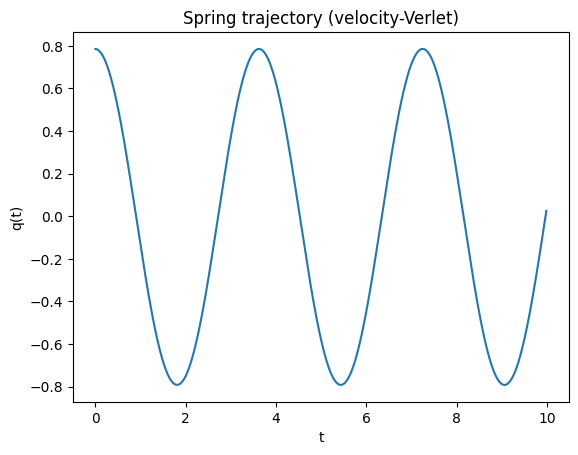

In [24]:
t0, tf, dt = 0.0, 10.0, 0.01
time = np.arange(t0, tf, dt)
trajectory = np.zeros((len(time), 2))

trajectory = np.zeros((len(time), 2))
trajectory[0] = [torch.pi/4, 0.0]

# get initial derivatives
dqdt, dpdt = derivatives_test(trajectory[0])   # dqdt = v, dpdt = m·a

for i in range(1, len(time)):
    q_n, p_n = trajectory[i-1]
    v_n = dqdt
    a_n = dpdt / (m_test * l_test**2)

    q_new = q_n + v_n*dt + 0.5*a_n*dt**2

    dqdt_new, dpdt_new = derivatives_test([q_new, p_n])
    a_new = dpdt_new / (m_test * l_test**2)

    v_new = v_n + 0.5*(a_n + a_new)*dt
    p_new = v_new / (m_test * l_test**2)

    trajectory[i] = [q_new, p_new]
    dqdt, dpdt = v_new, dpdt_new

# ----- plot q(t) -----
plt.figure()
plt.plot(time, trajectory[:, 0])
plt.xlabel('t')
plt.ylabel('q(t)')
plt.title('Spring trajectory (velocity-Verlet)')
plt.show()


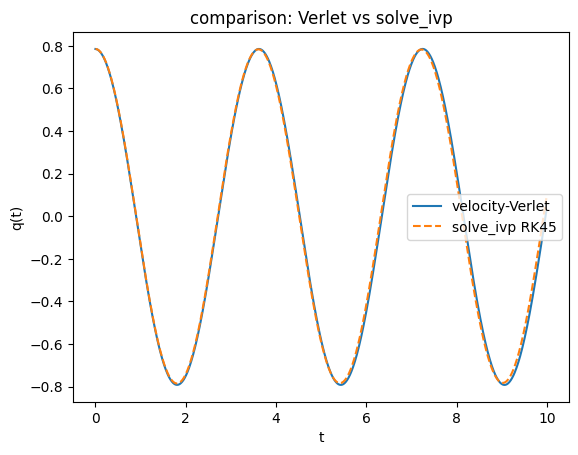

In [25]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# time grid
t0, tf, dt = 0.0, 10.0, 0.01
time = np.arange(t0, tf, dt)

# initial state
q0 = np.pi/4
p0 = 0.0

# define the pendulum ODE
def pendulum(t, state):
    q, p = state
    dqdt = p/(m_test*l_test**2)
    dpdt = -m_test*9.81*l_test*np.sin(q)
    return [dqdt, dpdt]

# integrate with a Runge-Kutta method
sol = solve_ivp(
    pendulum,
    (t0, tf),
    [q0, p0],
    t_eval=time,
    method='RK45'
)

q_ref = sol.y[0]  # reference q(t)

# now plot
plt.figure()
plt.plot(time, trajectory[:,0], label='velocity-Verlet')
plt.plot(time, q_ref, '--', label='solve_ivp RK45')
plt.xlabel('t')
plt.ylabel('q(t)')
plt.title('comparison: Verlet vs solve_ivp')
plt.legend()
plt.show()
